### 1. import packages

In [1]:
# import packages
import os
from torch.autograd import Variable as V
from scipy.misc import imresize
import numpy as np
import torch
import numpy

from functools import partial
import re
import random
import signal
import csv
from collections import OrderedDict
from scipy.misc import imread
from multiprocessing import Pool, cpu_count
from multiprocessing.pool import ThreadPool
from scipy.ndimage.interpolation import zoom

import torchvision
import time

### 2. set global varibles

In [2]:
# Settings

######### global settings  #########
GPU = True                                  # running on GPU is highly suggested
TEST_MODE = False                           # turning on the testmode means the code will run on a small dataset.
CLEAN = True                               # set to "True" if you want to clean the temporary large files after generating result
MODEL = 'resnet18'                          # model arch: resnet18, alexnet, resnet50, densenet161
DATASET = 'places365'                       # model trained on: places365 or imagenet
QUANTILE = 0.005                            # the threshold used for activation
SEG_THRESHOLD = 0.04                        # the threshold used for visualization
SCORE_THRESHOLD = 0.04                      # the threshold used for IoU score (in HTML file)
TOPN = 10                                   # to show top N image with highest activation for each unit
PARALLEL = 1                                # how many process is used for tallying (Experiments show that 1 is the fastest)
CATAGORIES = ["object", "part","scene","texture","color"] # concept categories that are chosen to detect: "object", "part", "scene", "material", "texture", "color"
OUTPUT_FOLDER = "../../../project2/bermanm/netdissect/dissection/" + MODEL + "_" + DATASET # result will be stored in this folder

### 3. set some model-dependent variables

In [3]:
########### sub settings ###########

# set data set and image size
if MODEL != 'alexnet': # if the model is not alexnet, use broden1_224
    DATA_DIRECTORY = '../../../project/rcc/deep_learning_hack/netdissect/broden1_224'
    IMG_SIZE = 224
else: # otherwise use broden1_227
    DATA_DIRECTORY = './data/broden1_227'
    IMG_SIZE = 227

# set number of classes
if DATASET == 'places365':
    NUM_CLASSES = 365
elif DATASET == 'imagenet':
    NUM_CLASSES = 1000
    
if MODEL == 'resnet18':
    FEATURE_NAMES = ['layer4']
    if DATASET == 'places365':
        MODEL_FILE = '../../../project2/bermanm/netdissect/ENL_NetDissect/resnet18_places365.pth.tar' # model data is stored here
        MODEL_PARALLEL = True
    elif DATASET == 'imagenet':
        MODEL_FILE = None
        MODEL_PARALLEL = False
elif MODEL == 'densenet161': # cannot run it now
    FEATURE_NAMES = ['features']
    if DATASET == 'places365':
        MODEL_FILE = 'zoo/whole_densenet161_places365_python36.pth.tar'
        MODEL_PARALLEL = False
elif MODEL == 'resnet50': # cannot run it now
    FEATURE_NAMES = ['layer4']
    if DATASET == 'places365':
        MODEL_FILE = 'zoo/whole_resnet50_places365_python36.pth.tar'
        MODEL_PARALLEL = False

# set parameters depending on whether it is test mod
if TEST_MODE:
    WORKERS = 1
    BATCH_SIZE = 4
    TALLY_BATCH_SIZE = 2
    TALLY_AHEAD = 1
    INDEX_FILE = 'index_sm.csv' # what is this file?
    OUTPUT_FOLDER += "_test"
else:
    WORKERS = 12
    BATCH_SIZE = 128
    TALLY_BATCH_SIZE = 16
    TALLY_AHEAD = 4
    INDEX_FILE = 'index.csv'

### 4. helper - decode_index_dict()

In [4]:
def decode_index_dict(row):
    result = {}
    for key, val in row.items():
        if key in ['image', 'split']:
            result[key] = val
        elif key in ['sw', 'sh', 'iw', 'ih']:
            result[key] = int(val)
        else:
            item = [s for s in val.split(';') if s]
            for i, v in enumerate(item):
                if re.match('^\d+$', v):
                    item[i] = int(v)
            result[key] = item
    return result

### 5. helper -  decode_label_dict() 

In [5]:
def decode_label_dict(row):
    result = {}
    for key, val in row.items():
        if key == 'category':
            result[key] = dict((c, int(n))
                for c, n in [re.match('^([^(]*)\(([^)]*)\)$', f).groups()
                    for f in val.split(';')])
        elif key == 'name':
            result[key] = val
        elif key == 'syns':
            result[key] = val.split(';')
        elif re.match('^\d+$', val):
            result[key] = int(val)
        elif re.match('^\d+\.\d*$', val):
            result[key] = float(val)
        else:
            result[key] = val
    return result

### 6. helper - index_has_all_data()

In [6]:
def index_has_all_data(row, categories):
    for c in categories:
        cat_has = False
        for data in row[c]:
            if data:
                cat_has = True
                break
        if not cat_has:
            return False
    return True


### 7. helper - index_has_any_data()

In [7]:
def index_has_any_data(row, categories):
    for c in categories:
        for data in row[c]:
            if data: return True
    return False

### 8. helper - build_numpy_category_map()

In [8]:
def build_numpy_category_map(map_data, key1='code', key2='number'):
    '''
    Input: set of rows with 'number' fields (or another field name key).
    Output: array such that a[number] = the row with the given number.
    '''
    results = list(numpy.zeros((max([d[key] for d in map_data]) + 1),
            dtype=numpy.int16) for key in (key1, key2))
    for d in map_data:
        results[0][d[key1]] = d[key2]
        results[1][d[key2]] = d[key1]
    return results

### 9. load AbstractSegmentation class
    HACK IT LATER

In [9]:
class AbstractSegmentation:
    def all_names(self, category, j):
        raise NotImplementedError
    def size(self, split=None):
        return 0
    def filename(self, i):
        raise NotImplementedError
    def metadata(self, i):
        return self.filename(i)
    @classmethod
    def resolve_segmentation(cls, m):
        return {}

    def name(self, category, i):
        '''
        Default implemtnation for segmentation_data,
        utilizing all_names.
        '''
        all_names = self.all_names(category, i)
        return all_names[0] if len(all_names) else ''

    def segmentation_data(self, category, i, c=0, full=False):
        '''
        Default implemtnation for segmentation_data,
        utilizing metadata and resolve_segmentation.
        '''
        segs = self.resolve_segmentation(
                self.metadata(i), categories=[category])
        if category not in segs:
            return 0
        data = segs[category]
        if not full and len(data.shape) >= 3:
            return data[0]
        return data


### 11. Load SegmentationData Class
    HACK IT LATER

In [10]:
class SegmentationData(AbstractSegmentation):
    '''
    Represents and loads a multi-channel segmentation represented with
    a series of csv files: index.csv lists the images together with
    any label data avilable in each category; category.csv lists
    the categories of segmentations available; and label.csv lists the
    numbers used to describe each label class. In addition, the categories
    each have a separate c_*.csv file describing a dense coding of labels.
    '''

    def __init__(self, directory, categories=None, require_all=False):
        directory = os.path.expanduser(directory)
        self.directory = directory
        with open(os.path.join(directory, INDEX_FILE)) as f:
            self.image = [decode_index_dict(r) for r in csv.DictReader(f)]
        with open(os.path.join(directory, 'category.csv')) as f:
            self.category = OrderedDict()
            for row in csv.DictReader(f):
                if categories and row['name'] in categories:
                    self.category[row['name']] = row
        categories = self.category.keys()
        with open(os.path.join(directory, 'label.csv')) as f:
            label_data = [decode_label_dict(r) for r in csv.DictReader(f)]
        self.label = build_dense_label_array(label_data)
        # Filter out images with insufficient data
        filter_fn = partial(
                index_has_all_data if require_all else index_has_any_data,
                categories=categories)
        self.image = [row for row in self.image if filter_fn(row)]
        # Build dense remapping arrays for labels, so that you can
        # get dense ranges of labels for each category.
        self.category_map = {}
        self.category_unmap = {}
        self.category_label = {}
        for cat in self.category:
            with open(os.path.join(directory, 'c_%s.csv' % cat)) as f:
                c_data = [decode_label_dict(r) for r in csv.DictReader(f)]
            self.category_unmap[cat], self.category_map[cat] = (
                    build_numpy_category_map(c_data))
            self.category_label[cat] = build_dense_label_array(
                    c_data, key='code')

        self.labelcat = self.onehot(self.primary_categories_per_index())

    def primary_categories_per_index(ds):
        '''
        Returns an array of primary category numbers for each label, where the
        first category listed in ds.category_names is given category number 0.
        '''
        catmap = {}
        categories = ds.category_names()
        for cat in categories:
            imap = ds.category_index_map(cat)
            if len(imap) < ds.label_size(None):
                imap = np.concatenate((imap, np.zeros(
                    ds.label_size(None) - len(imap), dtype=imap.dtype)))
            catmap[cat] = imap
        result = []
        for i in range(ds.label_size(None)):
            maxcov, maxcat = max(
                (ds.coverage(cat, catmap[cat][i]) if catmap[cat][i] else 0, ic)
                for ic, cat in enumerate(categories))
            result.append(maxcat)
        return np.array(result)

    def onehot(self, arr, minlength=None):
        '''
        Expands an array of integers in one-hot encoding by adding a new last
        dimension, leaving zeros everywhere except for the nth dimension, where
        the original array contained the integer n.  The minlength parameter is
        used to indcate the minimum size of the new dimension.
        '''
        length = np.amax(arr) + 1
        if minlength is not None:
            length = max(minlength, length)
        result = np.zeros(arr.shape + (length,))
        result[list(np.indices(arr.shape)) + [arr]] = 1
        return result


    def all_names(self, category, j):
        '''All English synonyms for the given label'''
        if category is not None:
            j = self.category_unmap[category][j]
        return [self.label[j]['name']] + self.label[j]['syns']

    def size(self, split=None):
        '''The number of images in this data set.'''
        if split is None:
            return len(self.image)
        return len([im for im in self.image if im['split'] == split])

    def filename(self, i):
        '''The filename of the ith jpeg (original image).'''
        return os.path.join(self.directory, 'images', self.image[i]['image'])

    def split(self, i):
        '''Which split contains item i.'''
        return self.image[i]['split']

    def metadata(self, i):
        '''Extract metadata for image i, For efficient data loading.'''
        return self.directory, self.image[i]

    meta_categories = ['image', 'split', 'ih', 'iw', 'sh', 'sw']

    @classmethod
    def resolve_segmentation(cls, m, categories=None):
        '''
        Resolves a full segmentation, potentially in a differenct process,
        for efficient multiprocess data loading.
        '''
        directory, row = m
        result = {}
        for cat, d in row.items():
            if cat in cls.meta_categories:
                continue
            if not wants(cat, categories):
                continue
            if all(isinstance(data, int) for data in d):
                result[cat] = d
                continue
            out = numpy.empty((len(d), row['sh'], row['sw']), dtype=numpy.int16)
            for i, channel in enumerate(d):
                if isinstance(channel, int):
                    out[i] = channel
                else:
                    rgb = imread(os.path.join(directory, 'images', channel))
                    out[i] = rgb[:,:,0] + rgb[:,:,1] * 256
            result[cat] = out
        return result, (row['sh'], row['sw'])

    def label_size(self, category=None):
        '''
        Returns the number of distinct labels (plus zero), i.e., one
        more than the maximum label number.  If a category is specified,
        returns the number of distinct labels within that category.
        '''
        if category is None:
            return len(self.label)
        else:
            return len(self.category_unmap[category])

    def name(self, category, j):
        '''
        Returns an English name for the jth label.  If a category is
        specified, returns the name for the category-specific nubmer j.
        If category=None, then treats j as a fully unified index number.
        '''
        if category is not None:
            j = self.category_unmap[category][j]
        return self.label[j]['name']

    def frequency(self, category, j):
        '''
        Returns the number of images for which the label appears.
        '''
        if category is not None:
            return self.category_label[category][j]['frequency']
        return self.label[j]['frequency']

    def coverage(self, category, j):
        '''
        Returns the pixel coverage of the label in units of whole-images.
        '''
        if category is not None:
            return self.category_label[category][j]['coverage']
        return self.label[j]['coverage']

    def category_names(self):
        '''
        Returns the set of category names.
        '''
        return list(self.category.keys())

    def category_frequency(self, category):
        '''
        Returns the number of images touched by a category.
        '''
        return float(self.category[category]['frequency'])

    def primary_categories_per_index(self, categories=None):
        '''
        Returns an array of primary category numbers for each label, where
        catagories are indexed according to the list of categories passed,
        or self.category_names() if none.
        '''
        if categories is None:
            categories = self.category_names()
        # Make lists which are nonzero for labels in a category
        catmap = {}
        for cat in categories:
            imap = self.category_index_map(cat)
            if len(imap) < self.label_size(None):
                imap = numpy.concatenate((imap, numpy.zeros(
                    self.label_size(None) - len(imap), dtype=imap.dtype)))
            catmap[cat] = imap
        # For each label, find the category with maximum coverage.
        result = []
        for i in range(self.label_size(None)):
            maxcov, maxcat = max(
                    (self.coverage(cat, catmap[cat][i])
                        if catmap[cat][i] else 0, ic)
                    for ic, cat in enumerate(categories))
            result.append(maxcat)
        # Return the max-coverage cateogry for each label.
        return numpy.array(result)
    def segmentation_data(self, category, i, c=0, full=False, out=None):
        '''
        Returns a 2-d numpy matrix with segmentation data for the ith image,
        restricted to the given category.  By default, maps all label numbers
        to the category-specific dense mapping described in the c_*.csv
        listing; but can be asked to expose the fully unique indexing by
        using full=True.
        '''
        row = self.image[i]
        data_channels = row.get(category, ())
        if c >= len(data_channels):
            channel = 0  # Deal with unlabeled data in this category
        else:
            channel = data_channels[c]
        if out is None:
            out = numpy.empty((row['sh'], row['sw']), dtype=numpy.int16)
        if isinstance(channel, int):
            if not full:
                channel = self.category_map[category][channel]
            out[:,:] = channel  # Single-label for the whole image
            return out
        png = imread(os.path.join(self.directory, 'images', channel))
        if full:
            # Full case: just combine png channels.
            out[...] = png[:,:,0] + png[:,:,1] * 256
        else:
            # Dense case: combine png channels and apply the category map.
            catmap = self.category_map[category]
            out[...] = catmap[png[:,:,0] + png[:,:,1] * 256]
        return out
    
    def full_segmentation_data(self, i,
            categories=None, max_depth=None, out=None):
        '''
        Returns a 3-d numpy tensor with segmentation data for the ith image,
        with multiple layers represnting multiple lables for each pixel.
        The depth is variable depending on available data but can be
        limited to max_depth.
        '''
        row = self.image[i]
        if categories:
            groups = [d for cat, d in row.items() if cat in categories and d]
        else:
            groups = [d for cat, d in row.items() if d and (
                cat not in self.meta_categories)]
        depth = sum(len(c) for c in groups)
        if max_depth is not None:
            depth = min(depth, max_depth)
        # Allocate an array if not already allocated.
        if out is None:
            out = numpy.empty((depth, row['sh'], row['sw']), dtype=numpy.int16)
        i = 0
        # Stack up the result segmentation one channel at a time
        for group in groups:
            for channel in group:
                if isinstance(channel, int):
                    out[i] = channel
                else:
                    png = imread(
                            os.path.join(self.directory, 'images', channel))
                    out[i] = png[:,:,0] + png[:,:,1] * 256
                i += 1
                if i == depth:
                    return out
        # Return above when we get up to depth
        assert False

    def category_index_map(self, category):
        return numpy.array(self.category_map[category])

### 12. helper - setup_signit()

In [11]:
def setup_sigint():
    import threading
    if not isinstance(threading.current_thread(), threading._MainThread):
        return None
    return signal.signal(signal.SIGINT, signal.SIG_IGN)

### 13. helper - restore_sigint()

In [12]:
def restore_sigint(original):
    import threading
    if not isinstance(threading.current_thread(), threading._MainThread):
        return
    if original is None:
        original = signal.SIG_DFL
    signal.signal(signal.SIGINT, original)

### 14. load SegmentationPrefetcher class
    HACK IT LATER

In [13]:
class SegmentationPrefetcher:
    '''
    SegmentationPrefetcher will prefetch a bunch of segmentation
    images using a multiprocessing pool, so you do not have to wait
    around while the files get opened and decoded.  Just request
    batches of images and segmentations calling fetch_batch().
    '''
    def __init__(self, segmentation, split=None, randomize=False,
            segmentation_shape=None, categories=None, once=False,
            start=None, end=None, batch_size=4, ahead=4, thread=False):
        '''
        Constructor arguments:
        segmentation: The AbstractSegmentation to load.
        split: None for no filtering, or 'train' or 'val' etc.
        randomize: True to randomly shuffle order, or a random seed.
        categories: a list of categories to include in each batch.
        batch_size: number of data items for each batch.
        ahead: the number of data items to prefetch ahead.
        '''
        self.segmentation = segmentation
        self.split = split
        self.randomize = randomize
        self.random = random.Random()
        if randomize is not True:
            self.random.seed(randomize)
        self.categories = categories
        self.once = once
        self.batch_size = batch_size
        self.ahead = ahead
        # Initialize the multiprocessing pool
        n_procs = cpu_count()
        if thread:
            self.pool = ThreadPool(processes=n_procs)
        else:
            original_sigint_handler = setup_sigint()
            self.pool = Pool(processes=n_procs, initializer=setup_sigint)
            restore_sigint(original_sigint_handler)
        # Prefilter the image indexes of interest
        if start is None:
            start = 0
        if end is None:
            end = segmentation.size()
        self.indexes = range(start, end)
        if split:
            self.indexes = [i for i in self.indexes
                    if segmentation.split(i) == split]
        if self.randomize:
            self.random.shuffle(self.indexes)
        self.index = 0
        self.result_queue = []
        self.segmentation_shape = segmentation_shape
        # Get dense catmaps
        self.catmaps = [
                segmentation.category_index_map(cat) if cat != 'image' else None
                for cat in categories]

    def next_job(self):
        if self.index < 0:
            return None
        j = self.indexes[self.index]
        result = (j,
                self.segmentation.__class__,
                self.segmentation.metadata(j),
                self.segmentation.filename(j),
                self.categories,
                self.segmentation_shape)
        self.index += 1
        if self.index >= len(self.indexes):
            if self.once:
                self.index = -1
            else:
                self.index = 0
                if self.randomize:
                    # Reshuffle every time through
                    self.random.shuffle(self.indexes)
        return result

    def batches(self):
        '''Iterator for all batches'''
        while True:
            batch = self.fetch_batch()
            if batch is None:
                raise StopIteration
            yield batch

    def fetch_batch(self):
        '''Returns a single batch as an array of dictionaries.'''
        try:
            self.refill_tasks()
            if len(self.result_queue) == 0:
                return None
            result = self.result_queue.pop(0)
            return result.get(31536000)
        except KeyboardInterrupt:
            print("Caught KeyboardInterrupt, terminating workers")
            self.pool.terminate()
            raise

    def fetch_tensor_batch(self, bgr_mean=None, global_labels=False):
        '''Iterator for batches as arrays of tensors.'''
        batch = self.fetch_batch()
        return self.form_caffe_tensors(batch, bgr_mean, global_labels)

    def tensor_batches(self, bgr_mean=None, global_labels=False):
        '''Returns a single batch as an array of tensors, one per category.'''
        while True:
            batch = self.fetch_tensor_batch(
                    bgr_mean=bgr_mean, global_labels=global_labels)
            if batch is None:
                raise StopIteration
            yield batch

    def form_caffe_tensors(self, batch, bgr_mean=None, global_labels=False):
        # Assemble a batch in [{'cat': data,..},..] format into
        # an array of batch tensors, the first for the image, and the
        # remaining for each category in self.categories, in order.
        # This also applies a random flip if needed
        if batch is None:
            return None
        batches = [[] for c in self.categories]
        for record in batch:
            default_shape = (1, record['sh'], record['sw'])
            for c, cat in enumerate(self.categories):
                if cat == 'image':
                    # Normalize image with right RGB order and mean
                    batches[c].append(normalize_image(
                        record[cat], bgr_mean))
                elif global_labels:
                    batches[c].append(normalize_label(
                        record[cat], default_shape, flatten=True))
                else:
                    catmap = self.catmaps[c]
                    batches[c].append(catmap[normalize_label(
                        record[cat], default_shape, flatten=True)])
        return [numpy.concatenate(tuple(m[numpy.newaxis] for m in b))
                for b in batches]

    def refill_tasks(self):
        # It will call the sequencer to ask for a sequence
        # of batch_size jobs (indexes with categories)
        # Then it will call pool.map_async
        while len(self.result_queue) < self.ahead:
            data = []
            while len(data) < self.batch_size:
                job = self.next_job()
                if job is None:
                    break
                data.append(job)
            if len(data) == 0:
                return
            self.result_queue.append(self.pool.map_async(prefetch_worker, data))

    def close(self):
        while len(self.result_queue):
            result = self.result_queue.pop(0)
            if result is not None:
                result.wait(0.001)
        self.pool.close()
        self.poool.cancel_join_thread()

### 15. helper - build_dense_label_array()

In [14]:
def build_dense_label_array(label_data, key='number', allow_none=False):
    '''
    Input: set of rows with 'number' fields (or another field name key).
    Output: array such that a[number] = the row with the given number.
    '''
    result = [None] * (max([d[key] for d in label_data]) + 1)
    for d in label_data:
        result[d[key]] = d
    # Fill in none
    if not allow_none:
        example = label_data[0]
        def make_empty(k):
            return dict((c, k if c is key else type(v)())
                    for c, v in example.items())
        for i, d in enumerate(result):
            if d is None:
                result[i] = dict(make_empty(i))
    return result

### 16. helper - loadmodel()
    HACK IT LATER

In [15]:
def loadmodel(hook_fn):
    if MODEL_FILE is None:
        model = torchvision.models.__dict__[MODEL](pretrained=True)
    else:
        checkpoint = torch.load(MODEL_FILE)
        if type(checkpoint).__name__ == 'OrderedDict' or type(checkpoint).__name__ == 'dict':
            model = torchvision.models.__dict__[MODEL](num_classes=NUM_CLASSES)
            if MODEL_PARALLEL:
                state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint[
                    'state_dict'].items()}  # the data parallel layer will add 'module' before each layer name
            else:
                state_dict = checkpoint
            model.load_state_dict(state_dict)
        else:
            model = checkpoint
    for name in FEATURE_NAMES:
        model._modules.get(name).register_forward_hook(hook_fn)
    if GPU:
        model.cuda()
    model.eval()
    return model

### 17. helper - prefetch_worker()

In [16]:
def prefetch_worker(d):
    if d is None:
        return None
    j, typ, m, fn, categories, segmentation_shape = d
    segs, shape = typ.resolve_segmentation(m, categories=categories)
    if segmentation_shape is not None:
        for k, v in segs.items():
            segs[k] = scale_segmentation(v, segmentation_shape)
        shape = segmentation_shape
    # Some additional metadata to provide
    segs['sh'], segs['sw'] = shape
    segs['i'] = j
    segs['fn'] = fn
    if categories is None or 'image' in categories:
        segs['image'] = imread(fn)
    return segs

### 18. helper - scale_segmentation

In [17]:
def scale_segmentation(segmentation, dims, crop=False):
    '''
    Zooms a 2d or 3d segmentation to the given dims, using nearest neighbor.
    '''
    shape = numpy.shape(segmentation)
    if len(shape) < 2 or shape[-2:] == dims:
        return segmentation
    peel = (len(shape) == 2)
    if peel:
        segmentation = segmentation[numpy.newaxis]
    levels = segmentation.shape[0]
    result = numpy.zeros((levels, ) + dims,
            dtype=segmentation.dtype)
    ratio = (1,) + tuple(res / float(orig)
            for res, orig in zip(result.shape[1:], segmentation.shape[1:]))
    if not crop:
        safezoom(segmentation, ratio, output=result, order=0)
    else:
        ratio = max(ratio[1:])
        height = int(round(dims[0] / ratio))
        hmargin = (segmentation.shape[0] - height) // 2
        width = int(round(dims[1] / ratio))
        wmargin = (segmentation.shape[1] - height) // 2
        safezoom(segmentation[:, hmargin:hmargin+height,
            wmargin:wmargin+width],
            (1, ratio, ratio), output=result, order=0)
    if peel:
        result = result[0]
    return result

### 19. helper - safezoom()

In [18]:
def safezoom(array, ratio, output=None, order=0):
    '''Like numpy.zoom, but does not crash when the first dimension
    of the array is of size 1, as happens often with segmentations'''
    dtype = array.dtype
    if array.dtype == numpy.float16:
        array = array.astype(numpy.float32)
    if array.shape[0] == 1:
        if output is not None:
            output = output[0,...]
        result = zoom(array[0,...], ratio[1:],
                output=output, order=order)
        if output is None:
            output = result[numpy.newaxis]
    else:
        result = zoom(array, ratio, output=output, order=order)
        if output is None:
            output = result
    return output.astype(dtype)

### 20. helper - wants()

In [19]:
def wants(what, option):
    if option is None:
        return True
    return what in option

### 21. helper - normalize_image()

In [20]:
def normalize_image(rgb_image, bgr_mean):
    """
    Load input image and preprocess for Caffe:
    - cast to float
    - switch channels RGB -> BGR
    - subtract mean
    - transpose to channel x height x width order
    """
    img = numpy.array(rgb_image, dtype=numpy.float32)
    if (img.ndim == 2):
        img = numpy.repeat(img[:,:,None], 3, axis = 2)
    img = img[:,:,::-1]
    if bgr_mean is not None:
        img -= bgr_mean
    img = img.transpose((2,0,1))
    return img

### 22. helper - normalize_label()

In [21]:
def normalize_label(label_data, shape, flatten=False):
    """
    Given a 0, 1, 2, or 3-dimensional label_data and a default
    shape of the form (1, y, x), returns a 3d tensor by 
    """
    dims = len(numpy.shape(label_data))
    if dims <= 2:
        # Scalar data on this channel: fill shape
        if dims == 1:
            if flatten:
                label_data = label_data[0] if len(label_data) else 0
            else:
                return (numpy.ones(shape, dtype=numpy.int16) *
                        numpy.asarray(label_data, dtype=numpy.int16)
                            [:, numpy.newaxis, numpy.newaxis])
        return numpy.full(shape, label_data, dtype=numpy.int16)
    else:
        if dims == 3:
            if flatten:
                label_data = label_data[0]
            else:
                return label_data
        return label_data[numpy.newaxis]

### 23. Hook_feature()

In [22]:
# what is this?
features_blobs = []

# update feature_blobs
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

### 24. Load QuantileVector Class
    Based on the optimal KLL quantile algorithm by Karnin, Lang, and Liberty
    from FOCS 2016.  http://ieee-focs.org/FOCS-2016-Papers/3933a071.pdf
    
    HACK IT LATER

In [23]:
# compute quantiles using less memory
class QuantileVector:
    def __init__(self, depth=1, resolution=24 * 1024, buffersize=None,
            dtype=None, seed=None):
        self.resolution = resolution
        self.depth = depth
        # Default buffersize: 128 samples (and smaller than resolution).
        if buffersize is None:
            buffersize = min(128, (resolution + 7) // 8)
        self.buffersize = buffersize
        self.samplerate = 1.0
        self.data = [numpy.zeros(shape=(depth, resolution), dtype=dtype)]
        self.firstfree = [0]
        self.random = numpy.random.RandomState(seed)
        self.extremes = numpy.empty(shape=(depth, 2), dtype=dtype)
        self.extremes.fill(numpy.NaN)
        self.size = 0
    
    def add(self, incoming):
        assert len(incoming.shape) == 2
        assert incoming.shape[1] == self.depth
        self.size += incoming.shape[0]
        # Convert to a flat numpy array.
        if self.samplerate >= 1.0:
            self._add_every(incoming)
            return
        # If we are sampling, then subsample a large chunk at a time.
        self._scan_extremes(incoming)
        chunksize = numpy.ceil[self.buffersize / self.samplerate]
        for index in range(0, len(incoming), chunksize):
            batch = incoming[index:index+chunksize]
            sample = batch[self.random.binomial(1, self.samplerate, len(batch))]
            self._add_every(sample)
        
    def _add_every(self, incoming):
        supplied = len(incoming)
        index = 0
        while index < supplied:
            ff = self.firstfree[0]
            available = self.data[0].shape[1] - ff
            if available == 0:
                if not self._shift():
                    # If we shifted by subsampling, then subsample.
                    incoming = incoming[index:]
                    if self.samplerate >= 0.5:
                        print('SAMPLING')
                        self._scan_extremes(incoming)
                    incoming = incoming[self.random.binomial(1, 0.5,
                        len(incoming - index))]
                    index = 0
                    supplied = len(incoming)
                ff = self.firstfree[0]
                available = self.data[0].shape[1] - ff
            copycount = min(available, supplied - index)
            self.data[0][:,ff:ff + copycount] = numpy.transpose(
                    incoming[index:index + copycount,:])
            self.firstfree[0] += copycount
            index += copycount

    def _shift(self):
        index = 0
        # If remaining space at the current layer is less than half prev
        # buffer size (rounding up), then we need to shift it up to ensure
        # enough space for future shifting.
        while self.data[index].shape[1] - self.firstfree[index] < (
                -(-self.data[index-1].shape[1] // 2) if index else 1):
            if index + 1 >= len(self.data):
                return self._expand()
            data = self.data[index][:,0:self.firstfree[index]]
            data.sort()
            if index == 0 and self.samplerate >= 1.0:
                self._update_extremes(data[:,0], data[:,-1])
            offset = self.random.binomial(1, 0.5)
            position = self.firstfree[index + 1]
            subset = data[:,offset::2]
            self.data[index + 1][:,position:position + subset.shape[1]] = subset
            self.firstfree[index] = 0
            self.firstfree[index + 1] += subset.shape[1]
            index += 1
        return True

    def _scan_extremes(self, incoming):
        # When sampling, we need to scan every item still to get extremes
        self._update_extremes(
                numpy.nanmin(incoming, axis=0),
                numpy.nanmax(incoming, axis=0))

    def _update_extremes(self, minr, maxr):
        self.extremes[:,0] = numpy.nanmin(
                [self.extremes[:, 0], minr], axis=0)
        self.extremes[:,-1] = numpy.nanmax(
                [self.extremes[:, -1], maxr], axis=0)

    def minmax(self):
        if self.firstfree[0]:
            self._scan_extremes(self.data[0][:,:self.firstfree[0]].transpose())
        return self.extremes.copy()

    def _expand(self):
        cap = self._next_capacity()
        if cap > 0:
            # First, make a new layer of the proper capacity.
            self.data.insert(0, numpy.empty(
                shape=(self.depth, cap), dtype=self.data[-1].dtype))
            self.firstfree.insert(0, 0)
        else:
            # Unless we're so big we are just subsampling.
            assert self.firstfree[0] == 0
            self.samplerate *= 0.5
        for index in range(1, len(self.data)):
            # Scan for existing data that needs to be moved down a level.
            amount = self.firstfree[index]
            if amount == 0:
                continue
            position = self.firstfree[index-1]
            # Move data down if it would leave enough empty space there
            # This is the key invariant: enough empty space to fit half
            # of the previous level's buffer size (rounding up)
            if self.data[index-1].shape[1] - (amount + position) >= (
                    -(-self.data[index-2].shape[1] // 2) if (index-1) else 1):
                self.data[index-1][:,position:position + amount] = (
                        self.data[index][:,:amount])
                self.firstfree[index-1] += amount
                self.firstfree[index] = 0
            else:
                # Scrunch the data if it would not.
                data = self.data[index][:,:amount]
                data.sort()
                if index == 1:
                    self._update_extremes(data[:,0], data[:,-1])
                offset = self.random.binomial(1, 0.5)
                scrunched = data[:,offset::2]
                self.data[index][:,:scrunched.shape[1]] = scrunched
                self.firstfree[index] = scrunched.shape[1]
        return cap > 0

    def _next_capacity(self):
        cap = numpy.ceil(self.resolution * numpy.power(0.67, len(self.data)))
        if cap < 2:
            return 0
        return max(self.buffersize, int(cap))

    def _weighted_summary(self, sort=True):
        if self.firstfree[0]:
            self._scan_extremes(self.data[0][:,:self.firstfree[0]].transpose())
        size = sum(self.firstfree) + 2
        weights = numpy.empty(
            shape=(size), dtype='float32') # floating point
        summary = numpy.empty(
            shape=(self.depth, size), dtype=self.data[-1].dtype)
        weights[0:2] = 0
        summary[:,0:2] = self.extremes
        index = 2
        for level, ff in enumerate(self.firstfree):
            if ff == 0:
                continue
            summary[:,index:index + ff] = self.data[level][:,:ff]
            weights[index:index + ff] = numpy.power(2.0, level)
            index += ff
        assert index == summary.shape[1]
        if sort:
            order = numpy.argsort(summary)
            summary = summary[numpy.arange(self.depth)[:,None], order]
            weights = weights[order]
        return (summary, weights)

    def quantiles(self, quantiles, old_style=False):
        if self.size == 0:
            return numpy.full((self.depth, len(quantiles)), numpy.nan)
        summary, weights = self._weighted_summary()
        cumweights = numpy.cumsum(weights, axis=-1) - weights / 2
        if old_style:
            # To be convenient with numpy.percentile
            cumweights -= cumweights[:,0:1]
            cumweights /= cumweights[:,-1:]
        else:
            cumweights /= numpy.sum(weights, axis=-1, keepdims=True)
        result = numpy.empty(shape=(self.depth, len(quantiles)))
        for d in range(self.depth):
            result[d] = numpy.interp(quantiles, cumweights[d], summary[d])
        return result

    def integrate(self, fun):
        result = None
        for level, ff in enumerate(self.firstfree):
            if ff == 0:
                continue
            term = numpy.sum(
                    fun(self.data[level][:,:ff]) * numpy.power(2.0, level),
                    axis=-1)
            if result is None:
                result = term
            else:
                result += term
        if result is not None:
            result /= self.samplerate
        return result

    def percentiles(self, percentiles):
        return self.quantiles(percentiles, old_style=True)

    def readout(self, count, old_style=True):
        return self.quantiles(
                numpy.linspace(0.0, 1.0, count), old_style=old_style)

### 25. load FeatureOperator class

In [27]:
class FeatureOperator:
    def __init__(self):
            # make a new directory if the give path does not have an output folder
            if not os.path.exists(OUTPUT_FOLDER): 
                os.makedirs(os.path.join(OUTPUT_FOLDER, 'image'))
            # turn data into a SegmentationData class (see previous class definition) 
            self.data = SegmentationData(DATA_DIRECTORY, categories=CATAGORIES)
            # prefetch some segmentation images using a multiprocessing pool
            self.loader = SegmentationPrefetcher(self.data,categories=['image'],once=True,batch_size=BATCH_SIZE)
            self.mean = [109.5388,118.6897,124.6901]
            
    def feature_extraction(self, model=None, memmap=True):
        loader = self.loader
        # extract the max value activaiton for each image
        maxfeatures = [None] * len(FEATURE_NAMES) # len -> how many features? FEATURE_NAMES = ["layer4"]
        wholefeatures = [None] * len(FEATURE_NAMES)
        features_size = [None] * len(FEATURE_NAMES)
        # get path of features_size_file
        features_size_file = os.path.join(OUTPUT_FOLDER, "feature_size.npy")
    
        if memmap:
            skip = True
            # define paths for mmap_files
            mmap_files =  [os.path.join(OUTPUT_FOLDER, "%s.mmap" % feature_name)  for feature_name in FEATURE_NAMES]
            print(mmap_files)
            mmap_max_files = [os.path.join(OUTPUT_FOLDER, "%s_max.mmap" % feature_name) for feature_name in FEATURE_NAMES]
            print(mmap_max_files)
            # if feature size file exists already
            if os.path.exists(features_size_file):
                # load the file -> something similar to a numpy dictionary
                features_size = np.load(features_size_file)
            # if feature size file does not exist
            else:
                skip = False
            # note: zip (kind of) combine two iterables into tuples
            for i, (mmap_file, mmap_max_file) in enumerate(zip(mmap_files,mmap_max_files)):
                if os.path.exists(mmap_file) and os.path.exists(mmap_max_file) and features_size[i] is not None:
                    print('loading features %s' % FEATURE_NAMES[i])
                    # np.memmap: create a memory-map to an array stored in a binary file on disk.
                    wholefeatures[i] = np.memmap(mmap_file, dtype=float,mode='r', shape=tuple(features_size[i]))
                    maxfeatures[i] = np.memmap(mmap_max_file, dtype=float, mode='r', shape=tuple(features_size[i][:2]))
                else:
                    print('file missing, loading from scratch')
                    skip = False
        # skip is false if any of the files is missing
            if skip:
                return wholefeatures, maxfeatures
        
        # now run feature extraction no matter memmap is used or not
        # loader.indexes & loader.batch_size comes from prefetcher class 
        # compute number of batches by divide the total number of samples by the batch size
        num_batches = (len(loader.indexes) + loader.batch_size - 1) / loader.batch_size
        # loader.tensor_batches is a batch of an array of tensors
        for batch_idx,batch in enumerate(loader.tensor_batches(bgr_mean=self.mean)):
            # del: remove an item in the list given an index; here empty the who list
            del features_blobs[:]
            input = batch[0]
            batch_size = len(input)
            print('extracting feature from batch %d / %d' % (batch_idx+1, num_batches))
            #reverse the second intex 
            # note the second subarray is reversed
            input = torch.from_numpy(input[:, ::-1, :, :].copy())
            input.div_(255.0 * 0.224) # ?
            # check if GPU is used
            if GPU:
                input = input.cuda()
            # V = autograd.variable
            input_var = V(input,volatile=True)  
            # feed forward into the model?
            logit = model.forward(input_var)
            while np.isnan(logit.data.max()): # ok the coder doesn't know when this scenario will happen
                print("nan") 
                del features_blobs[:]
                logit = model.forward(input_var)
                
            # initialize maxfeature variable
            if maxfeatures[0] is None:
                for i, feat_batch in enumerate(features_blobs):
                    # I don't understand features_blobs
                    size_features = (len(loader.indexes), feat_batch.shape[1])
                    # if memmap, get the max feature
                    if memmap:
                         maxfeatures[i] = np.memmap(mmap_max_files[i],dtype=float,mode='w+',shape=size_features)
                    # otherwise initialize with all zeros
                    else:
                        maxfeatures[i] = np.zeros(size_features)
            
            # what is feat_batch <- what is feature_blobs?
            # initialize wholefeature variable
            if len(feat_batch.shape) == 4 and wholefeatures[0] is None:
                for i, feat_batch in enumerate(features_blobs):
                    size_features = (len(loader.indexes), 
                                     feat_batch.shape[1], 
                                     feat_batch.shape[2], 
                                     feat_batch.shape[3])
                    features_size[i] = size_features
                    if memmap:
                        wholefeatures[i] = np.memmap(mmap_files[i], dtype=float, mode='w+', shape=size_features)
                    else:
                        wholefeatures[i] = np.zeros(size_features)
            
            np.save(features_size_file, features_size)
            # set start index and end index
            start_idx = batch_idx*BATCH_SIZE
            end_idx = min((batch_idx+1)*BATCH_SIZE, len(loader.indexes))
            
            # get feature variable
            for i, feat_batch in enumerate(features_blobs):
                if len(feat_batch.shape) == 4:
                    wholefeatures[i][start_idx:end_idx] = feat_batch
                    maxfeatures[i][start_idx:end_idx] = np.max(np.max(feat_batch,3),2)
                elif len(feat_batch.shape) == 3:
                    maxfeatures[i][start_idx:end_idx] = np.max(feat_batch, 2)
                elif len(feat_batch.shape) == 2:
                    maxfeatures[i][start_idx:end_idx] = feat_batch
        
        if len(feat_batch.shape) == 2:
            wholefeatures = maxfeatures
        return wholefeatures,maxfeatures
    
    def quantile_threshold(self, features, savepath=''):
        # set path for quantile threshold
        qtpath = os.path.join(OUTPUT_FOLDER, savepath)
        # if the word has been done, simply return
        if savepath and os.path.exists(qtpath):
             return np.load(qtpath)
        print("calculating quantile threshold")
        quant = QuantileVector(depth=features.shape[1], seed=1)
        start_time = time.time()
        last_batch_time = start_time
        # setting batch size ???
        batch_size = 64
        for i in range(0, features.shape[0], batch_size):
            # for each batch
            # keep track of the time
            batch_time = time.time()
            rate = i / (batch_time - start_time + 1e-15)
            batch_rate = batch_size / (batch_time - last_batch_time + 1e-15)
            last_batch_time = batch_time
            print('Processing quantile index %d: %f %f' % (i, rate, batch_rate))
            # fetch elements in the batch
            batch = features[i:i + batch_size]
            batch = np.transpose(batch, axes=(0, 2, 3, 1)).reshape(-1, features.shape[1]) # fine
            # Quantile Vector method: adding batch
            quant.add(batch)
        # QUANTILE = threshold for activation; = 0.005 by default
        print(quant.readout(1000))
        print(1-QUANTILE)
        ret = quant.readout(1000)[:, int(1000 * (1-QUANTILE)-1)]
        if savepath:
            np.save(qtpath, ret)
        return ret
    
    def tally_job(args):
        features, data, threshold, tally_labels, tally_units, tally_units_cat, tally_both, start, end = args
        # number of units
        units = features.shape[1]
        size_RF = (IMG_SIZE / features.shape[2], IMG_SIZE / features.shape[3])
        fieldmap = ((0, 0), size_RF, size_RF)
        pd = SegmentationPrefetcher(data, categories=data.category_names(),
                                    once=True, batch_size=TALLY_BATCH_SIZE,
                                    ahead=TALLY_AHEAD, start=start, end=end)
        # keep track of time 
        count = start
        start_time = time.time()
        last_batch_time = start_time
        for batch in pd.batches():
            batch_time = time.time()
            rate = (count - start) / (batch_time - start_time + 1e-15)
            batch_rate = len(batch) / (batch_time - last_batch_time + 1e-15)
            last_batch_time = batch_time
            print('labelprobe image index %d, items per sec %.4f, %.4f' % (count, rate, batch_rate))
            
            for concept_map in batch:
                count += 1
                # get the index of the image
                img_index = concept_map['i']
                scalars, pixels = [], []
                # for each category
                for cat in data.category_names():
                    # get corresponding 
                    label_group = concept_map[cat]
                    shape = np.shape(label_group)
                    if len(shape) % 2 == 0:
                        label_group = [label_group]
                    if len(shape) < 2:
                        scalars += label_group
                    else:
                        pixels.append(label_group)

                    for scalar in scalars:
                        tally_labels[scalar] += concept_map['sh'] * concept_map['sw']
                    if pixels:
                        pixels = np.concatenate(pixels)
                        tally_label = np.bincount(pixels.ravel())
                        if len(tally_label) > 0:
                            tally_label[0] = 0
                        tally_labels[:len(tally_label)] += tally_label

                # for each individual unit
                for unit_id in range(units):
                    feature_map = features[img_index][unit_id]
                    # if max value exceed threshold for the unit
                    if feature_map.max() > threshold[unit_id]:
                        # imresize? 
                        mask = imresize(feature_map, (concept_map['sh'], concept_map['sw']), mode='F')
                        indexes = np.argwhere(mask > threshold[unit_id])

                        tally_units[unit_id] += len(indexes)
                        if len(pixels) > 0:
                            tally_bt = np.bincount(pixels[:, indexes[:, 0], indexes[:, 1]].ravel())
                            if len(tally_bt) > 0:
                                tally_bt[0] = 0
                            tally_cat = np.dot(tally_bt[None,:], data.labelcat[:len(tally_bt), :])[0]
                            tally_both[unit_id,:len(tally_bt)] += tally_bt
                        for scalar in scalars:
                            tally_cat += data.labelcat[scalar]
                            tally_both[unit_id, scalar] += len(indexes)
                        tally_units_cat[unit_id] += len(indexes) * (tally_cat > 0)

                
        
    def tally(self, features, threshold, savepath=''):
        csvpath = os.path.join(OUTPUT_FOLDER, savepath)
        if savepath and os.path.exists(csvpath):
            return load_csv(csvpath)
        
        # initialize 
        units = features.shape[1]
        labels = len(self.data.label)
        categories = self.data.category_names()
        tally_both = np.zeros((units,labels),dtype=np.float64)
        tally_units = np.zeros(units,dtype=np.float64)
        tally_units_cat = np.zeros((units,len(categories)), dtype=np.float64)
        tally_labels = np.zeros(labels,dtype=np.float64)
        
        # OK seems like something for parallel computing; check it later
        if PARALLEL > 1:
            psize = int(np.ceil(float(self.data.size()) / PARALLEL))
            ranges = [(s, min(self.data.size(), s + psize)) for s in range(0, self.data.size(), psize) if
                      s < self.data.size()]
            params = [(features, self.data, threshold, tally_labels, tally_units, tally_units_cat, tally_both) + r for r in ranges]
            threadpool = pool.ThreadPool(processes=PARALLEL)
            threadpool.map(FeatureOperator.tally_job, params)
        else:
            FeatureOperator.tally_job((features, self.data, threshold, tally_labels, tally_units, tally_units_cat, tally_both, 0, self.data.size()))

        primary_categories = self.data.primary_categories_per_index()
        # compute dot product between 
        tally_units_cat = np.dot(tally_units_cat, self.data.labelcat.T)
        # iou intersection over units
        iou = tally_both / (tally_units_cat + tally_labels[np.newaxis,:] - tally_both + 1e-10)
        pciou = np.array([iou * (primary_categories[np.arange(iou.shape[1])] == ci)[np.newaxis, :] for ci in range(len(self.data.category_names()))])
        label_pciou = pciou.argmax(axis=2)
        name_pciou = [
            [self.data.name(None, j) for j in label_pciou[ci]]
            for ci in range(len(label_pciou))]
        score_pciou = pciou[
            np.arange(pciou.shape[0])[:, np.newaxis],
            np.arange(pciou.shape[1])[np.newaxis, :],
            label_pciou]
        bestcat_pciou = score_pciou.argsort(axis=0)[::-1]
        ordering = score_pciou.max(axis=0).argsort()[::-1]
        rets = [None] * len(ordering)
        
        for i,unit in enumerate(ordering):
            bestcat = bestcat_pciou[0, unit]
            data = {
                'unit': (unit + 1),
                'category': categories[bestcat],
                'label': name_pciou[bestcat][unit],
                'score': score_pciou[bestcat][unit]
            }
            for ci, cat in enumerate(categories):
                label = label_pciou[ci][unit]
                data.update({
                    '%s-label' % cat: name_pciou[ci][unit],
                    '%s-truth' % cat: tally_labels[label],
                    '%s-activation' % cat: tally_units_cat[unit, label],
                    '%s-intersect' % cat: tally_both[unit, label],
                    '%s-iou' % cat: score_pciou[ci][unit]
                })
            rets[i] = data

        if savepath:
            import csv
            csv_fields = sum([[
                '%s-label' % cat,
                '%s-truth' % cat,
                '%s-activation' % cat,
                '%s-intersect' % cat,
                '%s-iou' % cat] for cat in categories],
                ['unit', 'category', 'label', 'score'])
            with open(csvpath, 'w') as f:
                writer = csv.DictWriter(f, csv_fields)
                writer.writeheader()
                for i in range(len(ordering)):
                    writer.writerow(rets[i])
        return rets
            
            

### 27. Define a Feature_Operator variable

In [28]:
fo = FeatureOperator()

###  28. Do feature extraction()

In [29]:
model = loadmodel(hook_feature)
features, maxfeature = fo.feature_extraction(model=model)

['../../../project2/bermanm/netdissect/dissection/resnet18_places365/layer4.mmap']
['../../../project2/bermanm/netdissect/dissection/resnet18_places365/layer4_max.mmap']
loading features layer4


#### Check features and maxfeatures

In [163]:
print(len(features))
print(features[0].shape)
#print(maxfeature[0].shape)
#print(features[0][1 : 1 + 64])
print(maxfeature[0].shape)

1
(63305, 512, 7, 7)
(63305, 512)


### 29. Calculate threshold

In [31]:
# want to have P(a_k > T_k) = 0.005, where k is a unit
for layer_id,layer in enumerate(FEATURE_NAMES):
    print(layer_id, layer)
    thresholds = fo.quantile_threshold(features[layer_id],savepath="quantile.npy")

0 layer4


### History lost :( study Tally again

In [30]:
layer_id = 0
layer = FEATURE_NAMES[0]

In [31]:
savepath = "tally.csv"
csvpath = os.path.join(OUTPUT_FOLDER, savepath)

In [32]:
if savepath and os.path.exists(csvpath):
    print("tally exist")
    tally_result = load_csv(csvpath)

In [33]:
f = features[layer_id]
print(f)

[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 1.31716684e-01]
   ...
   [0.00000000e+00 0.00000000e+00 1.51383251e-01 ... 4.41018790e-01
    1.36240888e+00 1.22327912e+00]
   [1.05288410e+00 1.19605005e+00 1.29995263e+00 ... 1.20202816e+00
    2.18029690e+00 1.83771491e+00]
   [1.84581208e+00 1.43044806e+00 1.54802322e+00 ... 1.28344512e+00
    1.62736440e+00 1.25797927e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [2.10698515e-01 5.89928776e-02 1.88222807e-02 ... 1.24826215e-01
    0.00000000e+00 0.00000000e+00]
   ...
   [6.16111338e-01 2.52829999e-01 0.00000000e+00 ... 0.00

In [34]:
units = f.shape[1]
print(units)

512


In [35]:
labels = len(fo.data.label)
print(labels)

1198


In [36]:
categories = fo.data.category_names()
print(categories)

['color', 'object', 'part', 'scene', 'texture']


In [37]:
tally_both = np.zeros((units,labels),dtype=np.float64) # 512 x 1198

In [38]:
tally_units = np.zeros(units,dtype=np.float64) # 512

In [39]:
tally_units_cat = np.zeros((units,len(categories)), dtype=np.float64) # 512 x 5

In [40]:
tally_labels = np.zeros(labels,dtype=np.float64) # 1198

### Tally job

In [41]:
threshold = thresholds
d = fo.data
start = 0
end = fo.data.size()

In [42]:
size_RF = (IMG_SIZE / f.shape[2], IMG_SIZE / f.shape[3])
print(size_RF)

(32.0, 32.0)


In [43]:
fieldmap = ((0, 0), size_RF, size_RF)
print(fieldmap)

((0, 0), (32.0, 32.0), (32.0, 32.0))


In [44]:
pd = SegmentationPrefetcher(d, categories=d.category_names(),
                                    once=True, batch_size=TALLY_BATCH_SIZE,
                                    ahead=TALLY_AHEAD, start=start, end=end)

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/__main__.py:128: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/__main__.py:128: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/__main__.py:128: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/__main__.py:128: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


In [45]:
count = start

In [57]:
f[0][2]

memmap([[0.43572149, 0.52332854, 0.59500879, 1.0443548 , 1.25218737,
         1.25133681, 0.91424435],
        [0.16593704, 0.2995311 , 0.61378074, 1.26466084, 1.57409823,
         1.57594156, 1.06530654],
        [0.        , 0.        , 0.        , 0.        , 0.23191556,
         0.60445142, 0.56907916],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ]])

In [65]:
d.labelcat[:12, :]

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [70]:
indexes[0]

array([51, 56])

In [74]:
print(tally_bt)

[   0  126   56   47  280  845    7    0    0   86    0    0    0    0
    0    0 1306    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  126    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [77]:
tally_cat = np.dot(tally_bt[None,:], d.labelcat[:len(tally_bt), :])

In [79]:
tally_bt[None, :]

array([[   0,  126,   56,   47,  280,  845,    7,    0,    0,   86,    0,
           0,    0,    0,    0,    0, 1306,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         126,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [80]:
d.labelcat[:len(tally_bt), :]

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [46]:
for batch in pd.batches():
    for concept_map in batch:
        print(concept_map)
        count += 1
        img_index = concept_map['i']
        scalars, pixels = [], []
        for cat in d.category_names():
            #print("category: ", cat)
            label_group = concept_map[cat]
            #print("label_group: ", label_group)
            shape = np.shape(label_group)
            #print("shape: ", shape)
            if len(shape) % 2 == 0:    # When will this happen?
                label_group = [label_group]
            if len(shape) < 2:
                scalars += label_group
            else:
                pixels.append(label_group)
            #print("scalars: ", scalars)
            #print("pixels: ", pixels)
        
        for scalar in scalars:
            tally_labels[scalar] += concept_map['sh'] * concept_map['sw'] # what are sh and sw? (12544)
            #print("update scalar", scalar, tally_labels[scalar])
        if pixels:
            pixels = np.concatenate(pixels)
            tally_label = np.bincount(pixels.ravel())  # count the occurence of each color?
            #print("length of tally_label", len(tally_label))
            #print("bincount tally", tally_label)
            if len(tally_label) > 0:
                tally_label[0] = 0   # ignore 0 color -> white or something?
            tally_labels[:len(tally_label)] += tally_label # update color labels? but what if some colors are missed?
            
        for unit_id in range(units):
            feature_map = f[img_index][unit_id]  # 7 x 7
            #print("feature_map:", feature_map)
            if feature_map.max() > threshold[unit_id]: # when there is a feature > threshold for this unit_id
                print("unit:", unit_id)
                # interpolation
                #print("feature map: ", feature_map)
                mask = imresize(feature_map, (concept_map['sh'], concept_map['sw']), mode='F') # F: 32-bit floating point pixels
                #print("first row of mask: ", mask[0])
                indexes = np.argwhere(mask > threshold[unit_id])
                #print("shape of indexes", indexes.shape)
                
                tally_units[unit_id] += len(indexes) # add number of indexes > threshold
                
                if len(pixels) > 0:
                    tally_bt = np.bincount(pixels[:, indexes[:, 0], indexes[:, 1]].ravel()) # find all related colors
                    
                    if len(tally_bt) > 0:
                        tally_bt[0] = 0
                    tally_cat = np.dot(tally_bt[None,:], d.labelcat[:len(tally_bt), :])[0] # get colors count
                    #print("tally_cat", tally_cat)
                    tally_both[unit_id,:len(tally_bt)] += tally_bt # specified to unit_id
                
                for scalar in scalars:
                    tally_cat += data.labelcat[scalar] # add the corresponding category
                    tally_both[unit_id, scalar] += len(indexes)
                tally_units_cat[unit_id] += len(indexes) * (tally_cat > 0)
        break
    break

{'color': array([[[3, 3, 3, ..., 3, 3, 0],
        [3, 3, 3, ..., 3, 3, 0],
        [8, 8, 8, ..., 3, 3, 0],
        ...,
        [2, 2, 2, ..., 1, 4, 0],
        [2, 2, 2, ..., 2, 2, 0],
        [2, 2, 2, ..., 5, 4, 0]]], dtype=int16), 'object': [], 'part': [], 'scene': [], 'texture': [], 'sh': 112, 'sw': 112, 'i': 0, 'fn': '../../../project/rcc/deep_learning_hack/netdissect/broden1_224/images/opensurfaces/25605.jpg'}
unit: 23
unit: 25
unit: 36
unit: 43
unit: 47
unit: 54
unit: 90
unit: 119
unit: 150
unit: 151
unit: 211
unit: 224
unit: 227
unit: 228
unit: 233
unit: 260
unit: 294
unit: 309
unit: 362
unit: 367
unit: 378
unit: 394
unit: 415
unit: 431
unit: 455
unit: 459
unit: 464
unit: 466
unit: 480


/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/__main__.py:41: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [52]:
tally_units_cat[480]

array([944.,   0.,   0.,   0.,   0.])

In [57]:
tally_both[480].shape

(1198,)

In [59]:
color = concept_map["color"]

In [60]:
color

array([[[3, 3, 3, ..., 3, 3, 0],
        [3, 3, 3, ..., 3, 3, 0],
        [8, 8, 8, ..., 3, 3, 0],
        ...,
        [2, 2, 2, ..., 1, 4, 0],
        [2, 2, 2, ..., 2, 2, 0],
        [2, 2, 2, ..., 5, 4, 0]]], dtype=int16)

### Back to Tally

In [63]:
d.primary_categories_per_index() # as its name suggests

array([4, 0, 0, ..., 1, 1, 1])

In [64]:
primary_categories = d.primary_categories_per_index()

In [65]:
tally_units_cat = np.dot(tally_units_cat, d.labelcat.T)

In [66]:
tally_units_cat.shape

(512, 1198)

In [75]:
print(tally_units_cat[480])

[  0. 944. 944. ...   0.   0.   0.]


In [68]:
print(np.newaxis)

None


In [76]:
tally_labels[np.newaxis, :].shape

(1, 1198)

In [77]:
tally_both.shape

(512, 1198)

In [78]:
iou = tally_both / (tally_units_cat + tally_labels[np.newaxis,:] - tally_both + 1e-10)

In [80]:
d = iou[iou > 0]

In [84]:
iou.shape

(512, 1198)

In [91]:
len(d.category_names())

5

In [107]:
temp = np.array([iou * (primary_categories[np.arange(iou.shape[1])] == ci)[np.newaxis, :] for ci in range(len(d.category_names()))])

In [110]:
temp

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

    

In [109]:
primary_categories[np.arange(iou.shape[1])]

array([4, 0, 0, ..., 1, 1, 1])

In [112]:
pciou = np.array([iou * (primary_categories[np.arange(iou.shape[1])] == ci)[np.newaxis, :] for ci in range(len(d.category_names()))])

In [114]:
pciou.shape

(5, 512, 1198)

In [115]:
label_pciou = pciou.argmax(axis=2) # find largest label per each unit & category

In [128]:
pciou[0, 480, :12]

array([0.        , 0.21144556, 0.01672598, 0.04283548, 0.00583942,
       0.0008881 , 0.00191755, 0.        , 0.0319099 , 0.        ,
       0.        , 0.        ])

In [129]:
label_pciou[0, 480]

1

In [131]:
d.name(None, 1)

'black-c'

In [132]:
len(label_pciou)

5

In [133]:
# get label names
name_pciou = [
            [d.name(None, j) for j in label_pciou[ci]]
            for ci in range(len(label_pciou))]

In [136]:
score_pciou = pciou[
            np.arange(pciou.shape[0])[:, np.newaxis],
            np.arange(pciou.shape[1])[np.newaxis, :],
            label_pciou]

In [138]:
score_pciou.shape

(5, 512)

In [145]:
print(score_pciou[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.102118
 0.         0.21334368 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.15341747 0.         0.         0.         0.         0.
 0.         0.04573805 0.         0.         0.         0.08308605
 0.         0.         0.         0.         0.         0.
 0.30622471 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0509434  0.         0.         0.         0.         0.
 0.         0.         0.         0.      

In [139]:
bestcat_pciou = score_pciou.argsort(axis=0)[::-1]

In [149]:
ordering = score_pciou.max(axis=0).argsort()[::-1]

In [150]:
ordering

array([228, 227, 378,  54,  25, 480, 459, 224,  36, 233, 260, 119, 309,
       294,  23, 151, 367,  47, 394, 464,  90,  43, 431, 466, 455, 211,
       150, 362, 168, 171, 174, 175, 182, 163, 170, 181, 164, 162, 180,
       165, 166, 169, 179, 172, 178, 177, 167, 176, 173, 511, 161, 144,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145,
       160, 146, 147, 148, 149, 152, 153, 154, 183, 156, 157, 158, 159,
       155, 192, 184, 232, 217, 218, 219, 220, 221, 222, 223, 225, 226,
       229, 230, 231, 234, 215, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244, 245, 246, 216, 214, 185, 198, 186, 187, 188, 189, 190,
       191, 130, 193, 194, 195, 196, 197, 199, 213, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 212, 131, 123, 129,  32,  34,
        35,  37,  38,  39,  40,  41,  42,  44,  45,  46,  48,  49,  50,
        51,  52,  53,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        33,  31, 128,  30,   1,   2,   3,   4,   5,   6,   7,   

In [51]:
print(tally_labels)

[    0. 13130.  4991. ...     0.     0.     0.]


#### Check thresholds

### 30. Do Tally

In [29]:
#print(fo.data.label)
#print(fo.data.category_names())
print(features.shape)
print(IMG_SIZE)

AttributeError: 'list' object has no attribute 'shape'

In [32]:
#def tally(self, features, threshold, savepath=''):
savepath = "tally.csv"
threshold = thresholds
csvpath = os.path.join(OUTPUT_FOLDER, savepath)
#if savepath and os.path.exists(csvpath):   
    #load_csv(csvpath)
features = features[0]

# initialize 
units = features.shape[1]
labels = len(fo.data.label)
categories = fo.data.category_names()
tally_both = np.zeros((units,labels),dtype=np.float64)
tally_units = np.zeros(units,dtype=np.float64)
tally_units_cat = np.zeros((units,len(categories)), dtype=np.float64)
tally_labels = np.zeros(labels,dtype=np.float64)

data = fo.data
start = 0
end = fo.data.size()
#FeatureOperator.tally_job((features, fp.data, threshold, tally_labels, tally_units, tally_units_cat, tally_both, 0, fo.data.size()))
#features, data, threshold, tally_labels, tally_units, tally_units_cat, tally_both, start, end = args

units = features.shape[1]
size_RF = (IMG_SIZE / features.shape[2], IMG_SIZE / features.shape[3])
fieldmap = ((0, 0), size_RF, size_RF)
    
        

In [33]:
pd = SegmentationPrefetcher(data, categories=data.category_names(),
                                    once=True, batch_size=TALLY_BATCH_SIZE,
                                    ahead=TALLY_AHEAD, start=start, end=end)

/home/kywch/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:128: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/kywch/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:128: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/kywch/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:128: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/kywch/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:128: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/kywch/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launche

In [ ]:
count = start
start_time = time.time()
last_batch_time = start_time
cbatch = 0
for batch in pd.batches():
    cbatch += 1
    cconcept = 0
    for concept_map in batch:
        cconcept += 1
        print("cbatch = {}, cconcept = {}, length = {}".format(cbatch, cconcept, len(concept_map)))
        
#batch = pd.batches()
#batch_time = time.time()
#rate = (count - start) / (batch_time - start_time + 1e-15)
#batch_rate = len(batch) / (batch_time - last_batch_time + 1e-15)
#last_batch_time = batch_time
#print('labelprobe image index %d, items per sec %.4f, %.4f' % (count, rate, batch_rate))


cbatch = 1, cconcept = 1, length = 9
cbatch = 1, cconcept = 2, length = 9
cbatch = 1, cconcept = 3, length = 9
cbatch = 1, cconcept = 4, length = 9
cbatch = 1, cconcept = 5, length = 9
cbatch = 1, cconcept = 6, length = 9
cbatch = 1, cconcept = 7, length = 9
cbatch = 1, cconcept = 8, length = 9
cbatch = 1, cconcept = 9, length = 9
cbatch = 1, cconcept = 10, length = 9
cbatch = 1, cconcept = 11, length = 9
cbatch = 1, cconcept = 12, length = 9
cbatch = 1, cconcept = 13, length = 9
cbatch = 1, cconcept = 14, length = 9
cbatch = 1, cconcept = 15, length = 9
cbatch = 1, cconcept = 16, length = 9
cbatch = 2, cconcept = 1, length = 9
cbatch = 2, cconcept = 2, length = 9
cbatch = 2, cconcept = 3, length = 9
cbatch = 2, cconcept = 4, length = 9
cbatch = 2, cconcept = 5, length = 9
cbatch = 2, cconcept = 6, length = 9
cbatch = 2, cconcept = 7, length = 9
cbatch = 2, cconcept = 8, length = 9
cbatch = 2, cconcept = 9, length = 9
cbatch = 2, cconcept = 10, length = 9
cbatch = 2, cconcept = 11, len

cbatch = 15, cconcept = 1, length = 9
cbatch = 15, cconcept = 2, length = 9
cbatch = 15, cconcept = 3, length = 9
cbatch = 15, cconcept = 4, length = 9
cbatch = 15, cconcept = 5, length = 9
cbatch = 15, cconcept = 6, length = 9
cbatch = 15, cconcept = 7, length = 9
cbatch = 15, cconcept = 8, length = 9
cbatch = 15, cconcept = 9, length = 9
cbatch = 15, cconcept = 10, length = 9
cbatch = 15, cconcept = 11, length = 9
cbatch = 15, cconcept = 12, length = 9
cbatch = 15, cconcept = 13, length = 9
cbatch = 15, cconcept = 14, length = 9
cbatch = 15, cconcept = 15, length = 9
cbatch = 15, cconcept = 16, length = 9
cbatch = 16, cconcept = 1, length = 9
cbatch = 16, cconcept = 2, length = 9
cbatch = 16, cconcept = 3, length = 9
cbatch = 16, cconcept = 4, length = 9
cbatch = 16, cconcept = 5, length = 9
cbatch = 16, cconcept = 6, length = 9
cbatch = 16, cconcept = 7, length = 9
cbatch = 16, cconcept = 8, length = 9
cbatch = 16, cconcept = 9, length = 9
cbatch = 16, cconcept = 10, length = 9
cbat

cbatch = 30, cconcept = 1, length = 9
cbatch = 30, cconcept = 2, length = 9
cbatch = 30, cconcept = 3, length = 9
cbatch = 30, cconcept = 4, length = 9
cbatch = 30, cconcept = 5, length = 9
cbatch = 30, cconcept = 6, length = 9
cbatch = 30, cconcept = 7, length = 9
cbatch = 30, cconcept = 8, length = 9
cbatch = 30, cconcept = 9, length = 9
cbatch = 30, cconcept = 10, length = 9
cbatch = 30, cconcept = 11, length = 9
cbatch = 30, cconcept = 12, length = 9
cbatch = 30, cconcept = 13, length = 9
cbatch = 30, cconcept = 14, length = 9
cbatch = 30, cconcept = 15, length = 9
cbatch = 30, cconcept = 16, length = 9
cbatch = 31, cconcept = 1, length = 9
cbatch = 31, cconcept = 2, length = 9
cbatch = 31, cconcept = 3, length = 9
cbatch = 31, cconcept = 4, length = 9
cbatch = 31, cconcept = 5, length = 9
cbatch = 31, cconcept = 6, length = 9
cbatch = 31, cconcept = 7, length = 9
cbatch = 31, cconcept = 8, length = 9
cbatch = 31, cconcept = 9, length = 9
cbatch = 31, cconcept = 10, length = 9
cbat

cbatch = 45, cconcept = 1, length = 9
cbatch = 45, cconcept = 2, length = 9
cbatch = 45, cconcept = 3, length = 9
cbatch = 45, cconcept = 4, length = 9
cbatch = 45, cconcept = 5, length = 9
cbatch = 45, cconcept = 6, length = 9
cbatch = 45, cconcept = 7, length = 9
cbatch = 45, cconcept = 8, length = 9
cbatch = 45, cconcept = 9, length = 9
cbatch = 45, cconcept = 10, length = 9
cbatch = 45, cconcept = 11, length = 9
cbatch = 45, cconcept = 12, length = 9
cbatch = 45, cconcept = 13, length = 9
cbatch = 45, cconcept = 14, length = 9
cbatch = 45, cconcept = 15, length = 9
cbatch = 45, cconcept = 16, length = 9
cbatch = 46, cconcept = 1, length = 9
cbatch = 46, cconcept = 2, length = 9
cbatch = 46, cconcept = 3, length = 9
cbatch = 46, cconcept = 4, length = 9
cbatch = 46, cconcept = 5, length = 9
cbatch = 46, cconcept = 6, length = 9
cbatch = 46, cconcept = 7, length = 9
cbatch = 46, cconcept = 8, length = 9
cbatch = 46, cconcept = 9, length = 9
cbatch = 46, cconcept = 10, length = 9
cbat

cbatch = 59, cconcept = 1, length = 9
cbatch = 59, cconcept = 2, length = 9
cbatch = 59, cconcept = 3, length = 9
cbatch = 59, cconcept = 4, length = 9
cbatch = 59, cconcept = 5, length = 9
cbatch = 59, cconcept = 6, length = 9
cbatch = 59, cconcept = 7, length = 9
cbatch = 59, cconcept = 8, length = 9
cbatch = 59, cconcept = 9, length = 9
cbatch = 59, cconcept = 10, length = 9
cbatch = 59, cconcept = 11, length = 9
cbatch = 59, cconcept = 12, length = 9
cbatch = 59, cconcept = 13, length = 9
cbatch = 59, cconcept = 14, length = 9
cbatch = 59, cconcept = 15, length = 9
cbatch = 59, cconcept = 16, length = 9
cbatch = 60, cconcept = 1, length = 9
cbatch = 60, cconcept = 2, length = 9
cbatch = 60, cconcept = 3, length = 9
cbatch = 60, cconcept = 4, length = 9
cbatch = 60, cconcept = 5, length = 9
cbatch = 60, cconcept = 6, length = 9
cbatch = 60, cconcept = 7, length = 9
cbatch = 60, cconcept = 8, length = 9
cbatch = 60, cconcept = 9, length = 9
cbatch = 60, cconcept = 10, length = 9
cbat

cbatch = 74, cconcept = 1, length = 9
cbatch = 74, cconcept = 2, length = 9
cbatch = 74, cconcept = 3, length = 9
cbatch = 74, cconcept = 4, length = 9
cbatch = 74, cconcept = 5, length = 9
cbatch = 74, cconcept = 6, length = 9
cbatch = 74, cconcept = 7, length = 9
cbatch = 74, cconcept = 8, length = 9
cbatch = 74, cconcept = 9, length = 9
cbatch = 74, cconcept = 10, length = 9
cbatch = 74, cconcept = 11, length = 9
cbatch = 74, cconcept = 12, length = 9
cbatch = 74, cconcept = 13, length = 9
cbatch = 74, cconcept = 14, length = 9
cbatch = 74, cconcept = 15, length = 9
cbatch = 74, cconcept = 16, length = 9
cbatch = 75, cconcept = 1, length = 9
cbatch = 75, cconcept = 2, length = 9
cbatch = 75, cconcept = 3, length = 9
cbatch = 75, cconcept = 4, length = 9
cbatch = 75, cconcept = 5, length = 9
cbatch = 75, cconcept = 6, length = 9
cbatch = 75, cconcept = 7, length = 9
cbatch = 75, cconcept = 8, length = 9
cbatch = 75, cconcept = 9, length = 9
cbatch = 75, cconcept = 10, length = 9
cbat

cbatch = 88, cconcept = 1, length = 9
cbatch = 88, cconcept = 2, length = 9
cbatch = 88, cconcept = 3, length = 9
cbatch = 88, cconcept = 4, length = 9
cbatch = 88, cconcept = 5, length = 9
cbatch = 88, cconcept = 6, length = 9
cbatch = 88, cconcept = 7, length = 9
cbatch = 88, cconcept = 8, length = 9
cbatch = 88, cconcept = 9, length = 9
cbatch = 88, cconcept = 10, length = 9
cbatch = 88, cconcept = 11, length = 9
cbatch = 88, cconcept = 12, length = 9
cbatch = 88, cconcept = 13, length = 9
cbatch = 88, cconcept = 14, length = 9
cbatch = 88, cconcept = 15, length = 9
cbatch = 88, cconcept = 16, length = 9
cbatch = 89, cconcept = 1, length = 9
cbatch = 89, cconcept = 2, length = 9
cbatch = 89, cconcept = 3, length = 9
cbatch = 89, cconcept = 4, length = 9
cbatch = 89, cconcept = 5, length = 9
cbatch = 89, cconcept = 6, length = 9
cbatch = 89, cconcept = 7, length = 9
cbatch = 89, cconcept = 8, length = 9
cbatch = 89, cconcept = 9, length = 9
cbatch = 89, cconcept = 10, length = 9
cbat

cbatch = 102, cconcept = 1, length = 9
cbatch = 102, cconcept = 2, length = 9
cbatch = 102, cconcept = 3, length = 9
cbatch = 102, cconcept = 4, length = 9
cbatch = 102, cconcept = 5, length = 9
cbatch = 102, cconcept = 6, length = 9
cbatch = 102, cconcept = 7, length = 9
cbatch = 102, cconcept = 8, length = 9
cbatch = 102, cconcept = 9, length = 9
cbatch = 102, cconcept = 10, length = 9
cbatch = 102, cconcept = 11, length = 9
cbatch = 102, cconcept = 12, length = 9
cbatch = 102, cconcept = 13, length = 9
cbatch = 102, cconcept = 14, length = 9
cbatch = 102, cconcept = 15, length = 9
cbatch = 102, cconcept = 16, length = 9
cbatch = 103, cconcept = 1, length = 9
cbatch = 103, cconcept = 2, length = 9
cbatch = 103, cconcept = 3, length = 9
cbatch = 103, cconcept = 4, length = 9
cbatch = 103, cconcept = 5, length = 9
cbatch = 103, cconcept = 6, length = 9
cbatch = 103, cconcept = 7, length = 9
cbatch = 103, cconcept = 8, length = 9
cbatch = 103, cconcept = 9, length = 9
cbatch = 103, ccon

cbatch = 116, cconcept = 1, length = 9
cbatch = 116, cconcept = 2, length = 9
cbatch = 116, cconcept = 3, length = 9
cbatch = 116, cconcept = 4, length = 9
cbatch = 116, cconcept = 5, length = 9
cbatch = 116, cconcept = 6, length = 9
cbatch = 116, cconcept = 7, length = 9
cbatch = 116, cconcept = 8, length = 9
cbatch = 116, cconcept = 9, length = 9
cbatch = 116, cconcept = 10, length = 9
cbatch = 116, cconcept = 11, length = 9
cbatch = 116, cconcept = 12, length = 9
cbatch = 116, cconcept = 13, length = 9
cbatch = 116, cconcept = 14, length = 9
cbatch = 116, cconcept = 15, length = 9
cbatch = 116, cconcept = 16, length = 9
cbatch = 117, cconcept = 1, length = 9
cbatch = 117, cconcept = 2, length = 9
cbatch = 117, cconcept = 3, length = 9
cbatch = 117, cconcept = 4, length = 9
cbatch = 117, cconcept = 5, length = 9
cbatch = 117, cconcept = 6, length = 9
cbatch = 117, cconcept = 7, length = 9
cbatch = 117, cconcept = 8, length = 9
cbatch = 117, cconcept = 9, length = 9
cbatch = 117, ccon

cbatch = 130, cconcept = 1, length = 9
cbatch = 130, cconcept = 2, length = 9
cbatch = 130, cconcept = 3, length = 9
cbatch = 130, cconcept = 4, length = 9
cbatch = 130, cconcept = 5, length = 9
cbatch = 130, cconcept = 6, length = 9
cbatch = 130, cconcept = 7, length = 9
cbatch = 130, cconcept = 8, length = 9
cbatch = 130, cconcept = 9, length = 9
cbatch = 130, cconcept = 10, length = 9
cbatch = 130, cconcept = 11, length = 9
cbatch = 130, cconcept = 12, length = 9
cbatch = 130, cconcept = 13, length = 9
cbatch = 130, cconcept = 14, length = 9
cbatch = 130, cconcept = 15, length = 9
cbatch = 130, cconcept = 16, length = 9
cbatch = 131, cconcept = 1, length = 9
cbatch = 131, cconcept = 2, length = 9
cbatch = 131, cconcept = 3, length = 9
cbatch = 131, cconcept = 4, length = 9
cbatch = 131, cconcept = 5, length = 9
cbatch = 131, cconcept = 6, length = 9
cbatch = 131, cconcept = 7, length = 9
cbatch = 131, cconcept = 8, length = 9
cbatch = 131, cconcept = 9, length = 9
cbatch = 131, ccon

cbatch = 144, cconcept = 1, length = 9
cbatch = 144, cconcept = 2, length = 9
cbatch = 144, cconcept = 3, length = 9
cbatch = 144, cconcept = 4, length = 9
cbatch = 144, cconcept = 5, length = 9
cbatch = 144, cconcept = 6, length = 9
cbatch = 144, cconcept = 7, length = 9
cbatch = 144, cconcept = 8, length = 9
cbatch = 144, cconcept = 9, length = 9
cbatch = 144, cconcept = 10, length = 9
cbatch = 144, cconcept = 11, length = 9
cbatch = 144, cconcept = 12, length = 9
cbatch = 144, cconcept = 13, length = 9
cbatch = 144, cconcept = 14, length = 9
cbatch = 144, cconcept = 15, length = 9
cbatch = 144, cconcept = 16, length = 9
cbatch = 145, cconcept = 1, length = 9
cbatch = 145, cconcept = 2, length = 9
cbatch = 145, cconcept = 3, length = 9
cbatch = 145, cconcept = 4, length = 9
cbatch = 145, cconcept = 5, length = 9
cbatch = 145, cconcept = 6, length = 9
cbatch = 145, cconcept = 7, length = 9
cbatch = 145, cconcept = 8, length = 9
cbatch = 145, cconcept = 9, length = 9
cbatch = 145, ccon

cbatch = 158, cconcept = 1, length = 9
cbatch = 158, cconcept = 2, length = 9
cbatch = 158, cconcept = 3, length = 9
cbatch = 158, cconcept = 4, length = 9
cbatch = 158, cconcept = 5, length = 9
cbatch = 158, cconcept = 6, length = 9
cbatch = 158, cconcept = 7, length = 9
cbatch = 158, cconcept = 8, length = 9
cbatch = 158, cconcept = 9, length = 9
cbatch = 158, cconcept = 10, length = 9
cbatch = 158, cconcept = 11, length = 9
cbatch = 158, cconcept = 12, length = 9
cbatch = 158, cconcept = 13, length = 9
cbatch = 158, cconcept = 14, length = 9
cbatch = 158, cconcept = 15, length = 9
cbatch = 158, cconcept = 16, length = 9
cbatch = 159, cconcept = 1, length = 9
cbatch = 159, cconcept = 2, length = 9
cbatch = 159, cconcept = 3, length = 9
cbatch = 159, cconcept = 4, length = 9
cbatch = 159, cconcept = 5, length = 9
cbatch = 159, cconcept = 6, length = 9
cbatch = 159, cconcept = 7, length = 9
cbatch = 159, cconcept = 8, length = 9
cbatch = 159, cconcept = 9, length = 9
cbatch = 159, ccon

cbatch = 172, cconcept = 1, length = 9
cbatch = 172, cconcept = 2, length = 9
cbatch = 172, cconcept = 3, length = 9
cbatch = 172, cconcept = 4, length = 9
cbatch = 172, cconcept = 5, length = 9
cbatch = 172, cconcept = 6, length = 9
cbatch = 172, cconcept = 7, length = 9
cbatch = 172, cconcept = 8, length = 9
cbatch = 172, cconcept = 9, length = 9
cbatch = 172, cconcept = 10, length = 9
cbatch = 172, cconcept = 11, length = 9
cbatch = 172, cconcept = 12, length = 9
cbatch = 172, cconcept = 13, length = 9
cbatch = 172, cconcept = 14, length = 9
cbatch = 172, cconcept = 15, length = 9
cbatch = 172, cconcept = 16, length = 9
cbatch = 173, cconcept = 1, length = 9
cbatch = 173, cconcept = 2, length = 9
cbatch = 173, cconcept = 3, length = 9
cbatch = 173, cconcept = 4, length = 9
cbatch = 173, cconcept = 5, length = 9
cbatch = 173, cconcept = 6, length = 9
cbatch = 173, cconcept = 7, length = 9
cbatch = 173, cconcept = 8, length = 9
cbatch = 173, cconcept = 9, length = 9
cbatch = 173, ccon

cbatch = 186, cconcept = 1, length = 9
cbatch = 186, cconcept = 2, length = 9
cbatch = 186, cconcept = 3, length = 9
cbatch = 186, cconcept = 4, length = 9
cbatch = 186, cconcept = 5, length = 9
cbatch = 186, cconcept = 6, length = 9
cbatch = 186, cconcept = 7, length = 9
cbatch = 186, cconcept = 8, length = 9
cbatch = 186, cconcept = 9, length = 9
cbatch = 186, cconcept = 10, length = 9
cbatch = 186, cconcept = 11, length = 9
cbatch = 186, cconcept = 12, length = 9
cbatch = 186, cconcept = 13, length = 9
cbatch = 186, cconcept = 14, length = 9
cbatch = 186, cconcept = 15, length = 9
cbatch = 186, cconcept = 16, length = 9
cbatch = 187, cconcept = 1, length = 9
cbatch = 187, cconcept = 2, length = 9
cbatch = 187, cconcept = 3, length = 9
cbatch = 187, cconcept = 4, length = 9
cbatch = 187, cconcept = 5, length = 9
cbatch = 187, cconcept = 6, length = 9
cbatch = 187, cconcept = 7, length = 9
cbatch = 187, cconcept = 8, length = 9
cbatch = 187, cconcept = 9, length = 9
cbatch = 187, ccon

cbatch = 199, cconcept = 1, length = 9
cbatch = 199, cconcept = 2, length = 9
cbatch = 199, cconcept = 3, length = 9
cbatch = 199, cconcept = 4, length = 9
cbatch = 199, cconcept = 5, length = 9
cbatch = 199, cconcept = 6, length = 9
cbatch = 199, cconcept = 7, length = 9
cbatch = 199, cconcept = 8, length = 9
cbatch = 199, cconcept = 9, length = 9
cbatch = 199, cconcept = 10, length = 9
cbatch = 199, cconcept = 11, length = 9
cbatch = 199, cconcept = 12, length = 9
cbatch = 199, cconcept = 13, length = 9
cbatch = 199, cconcept = 14, length = 9
cbatch = 199, cconcept = 15, length = 9
cbatch = 199, cconcept = 16, length = 9
cbatch = 200, cconcept = 1, length = 9
cbatch = 200, cconcept = 2, length = 9
cbatch = 200, cconcept = 3, length = 9
cbatch = 200, cconcept = 4, length = 9
cbatch = 200, cconcept = 5, length = 9
cbatch = 200, cconcept = 6, length = 9
cbatch = 200, cconcept = 7, length = 9
cbatch = 200, cconcept = 8, length = 9
cbatch = 200, cconcept = 9, length = 9
cbatch = 200, ccon

cbatch = 213, cconcept = 1, length = 9
cbatch = 213, cconcept = 2, length = 9
cbatch = 213, cconcept = 3, length = 9
cbatch = 213, cconcept = 4, length = 9
cbatch = 213, cconcept = 5, length = 9
cbatch = 213, cconcept = 6, length = 9
cbatch = 213, cconcept = 7, length = 9
cbatch = 213, cconcept = 8, length = 9
cbatch = 213, cconcept = 9, length = 9
cbatch = 213, cconcept = 10, length = 9
cbatch = 213, cconcept = 11, length = 9
cbatch = 213, cconcept = 12, length = 9
cbatch = 213, cconcept = 13, length = 9
cbatch = 213, cconcept = 14, length = 9
cbatch = 213, cconcept = 15, length = 9
cbatch = 213, cconcept = 16, length = 9
cbatch = 214, cconcept = 1, length = 9
cbatch = 214, cconcept = 2, length = 9
cbatch = 214, cconcept = 3, length = 9
cbatch = 214, cconcept = 4, length = 9
cbatch = 214, cconcept = 5, length = 9
cbatch = 214, cconcept = 6, length = 9
cbatch = 214, cconcept = 7, length = 9
cbatch = 214, cconcept = 8, length = 9
cbatch = 214, cconcept = 9, length = 9
cbatch = 214, ccon

cbatch = 226, cconcept = 1, length = 9
cbatch = 226, cconcept = 2, length = 9
cbatch = 226, cconcept = 3, length = 9
cbatch = 226, cconcept = 4, length = 9
cbatch = 226, cconcept = 5, length = 9
cbatch = 226, cconcept = 6, length = 9
cbatch = 226, cconcept = 7, length = 9
cbatch = 226, cconcept = 8, length = 9
cbatch = 226, cconcept = 9, length = 9
cbatch = 226, cconcept = 10, length = 9
cbatch = 226, cconcept = 11, length = 9
cbatch = 226, cconcept = 12, length = 9
cbatch = 226, cconcept = 13, length = 9
cbatch = 226, cconcept = 14, length = 9
cbatch = 226, cconcept = 15, length = 9
cbatch = 226, cconcept = 16, length = 9
cbatch = 227, cconcept = 1, length = 9
cbatch = 227, cconcept = 2, length = 9
cbatch = 227, cconcept = 3, length = 9
cbatch = 227, cconcept = 4, length = 9
cbatch = 227, cconcept = 5, length = 9
cbatch = 227, cconcept = 6, length = 9
cbatch = 227, cconcept = 7, length = 9
cbatch = 227, cconcept = 8, length = 9
cbatch = 227, cconcept = 9, length = 9
cbatch = 227, ccon

cbatch = 239, cconcept = 1, length = 9
cbatch = 239, cconcept = 2, length = 9
cbatch = 239, cconcept = 3, length = 9
cbatch = 239, cconcept = 4, length = 9
cbatch = 239, cconcept = 5, length = 9
cbatch = 239, cconcept = 6, length = 9
cbatch = 239, cconcept = 7, length = 9
cbatch = 239, cconcept = 8, length = 9
cbatch = 239, cconcept = 9, length = 9
cbatch = 239, cconcept = 10, length = 9
cbatch = 239, cconcept = 11, length = 9
cbatch = 239, cconcept = 12, length = 9
cbatch = 239, cconcept = 13, length = 9
cbatch = 239, cconcept = 14, length = 9
cbatch = 239, cconcept = 15, length = 9
cbatch = 239, cconcept = 16, length = 9
cbatch = 240, cconcept = 1, length = 9
cbatch = 240, cconcept = 2, length = 9
cbatch = 240, cconcept = 3, length = 9
cbatch = 240, cconcept = 4, length = 9
cbatch = 240, cconcept = 5, length = 9
cbatch = 240, cconcept = 6, length = 9
cbatch = 240, cconcept = 7, length = 9
cbatch = 240, cconcept = 8, length = 9
cbatch = 240, cconcept = 9, length = 9
cbatch = 240, ccon

cbatch = 252, cconcept = 1, length = 9
cbatch = 252, cconcept = 2, length = 9
cbatch = 252, cconcept = 3, length = 9
cbatch = 252, cconcept = 4, length = 9
cbatch = 252, cconcept = 5, length = 9
cbatch = 252, cconcept = 6, length = 9
cbatch = 252, cconcept = 7, length = 9
cbatch = 252, cconcept = 8, length = 9
cbatch = 252, cconcept = 9, length = 9
cbatch = 252, cconcept = 10, length = 9
cbatch = 252, cconcept = 11, length = 9
cbatch = 252, cconcept = 12, length = 9
cbatch = 252, cconcept = 13, length = 9
cbatch = 252, cconcept = 14, length = 9
cbatch = 252, cconcept = 15, length = 9
cbatch = 252, cconcept = 16, length = 9
cbatch = 253, cconcept = 1, length = 9
cbatch = 253, cconcept = 2, length = 9
cbatch = 253, cconcept = 3, length = 9
cbatch = 253, cconcept = 4, length = 9
cbatch = 253, cconcept = 5, length = 9
cbatch = 253, cconcept = 6, length = 9
cbatch = 253, cconcept = 7, length = 9
cbatch = 253, cconcept = 8, length = 9
cbatch = 253, cconcept = 9, length = 9
cbatch = 253, ccon

cbatch = 267, cconcept = 1, length = 9
cbatch = 267, cconcept = 2, length = 9
cbatch = 267, cconcept = 3, length = 9
cbatch = 267, cconcept = 4, length = 9
cbatch = 267, cconcept = 5, length = 9
cbatch = 267, cconcept = 6, length = 9
cbatch = 267, cconcept = 7, length = 9
cbatch = 267, cconcept = 8, length = 9
cbatch = 267, cconcept = 9, length = 9
cbatch = 267, cconcept = 10, length = 9
cbatch = 267, cconcept = 11, length = 9
cbatch = 267, cconcept = 12, length = 9
cbatch = 267, cconcept = 13, length = 9
cbatch = 267, cconcept = 14, length = 9
cbatch = 267, cconcept = 15, length = 9
cbatch = 267, cconcept = 16, length = 9
cbatch = 268, cconcept = 1, length = 9
cbatch = 268, cconcept = 2, length = 9
cbatch = 268, cconcept = 3, length = 9
cbatch = 268, cconcept = 4, length = 9
cbatch = 268, cconcept = 5, length = 9
cbatch = 268, cconcept = 6, length = 9
cbatch = 268, cconcept = 7, length = 9
cbatch = 268, cconcept = 8, length = 9
cbatch = 268, cconcept = 9, length = 9
cbatch = 268, ccon

cbatch = 280, cconcept = 1, length = 9
cbatch = 280, cconcept = 2, length = 9
cbatch = 280, cconcept = 3, length = 9
cbatch = 280, cconcept = 4, length = 9
cbatch = 280, cconcept = 5, length = 9
cbatch = 280, cconcept = 6, length = 9
cbatch = 280, cconcept = 7, length = 9
cbatch = 280, cconcept = 8, length = 9
cbatch = 280, cconcept = 9, length = 9
cbatch = 280, cconcept = 10, length = 9
cbatch = 280, cconcept = 11, length = 9
cbatch = 280, cconcept = 12, length = 9
cbatch = 280, cconcept = 13, length = 9
cbatch = 280, cconcept = 14, length = 9
cbatch = 280, cconcept = 15, length = 9
cbatch = 280, cconcept = 16, length = 9
cbatch = 281, cconcept = 1, length = 9
cbatch = 281, cconcept = 2, length = 9
cbatch = 281, cconcept = 3, length = 9
cbatch = 281, cconcept = 4, length = 9
cbatch = 281, cconcept = 5, length = 9
cbatch = 281, cconcept = 6, length = 9
cbatch = 281, cconcept = 7, length = 9
cbatch = 281, cconcept = 8, length = 9
cbatch = 281, cconcept = 9, length = 9
cbatch = 281, ccon

cbatch = 294, cconcept = 1, length = 9
cbatch = 294, cconcept = 2, length = 9
cbatch = 294, cconcept = 3, length = 9
cbatch = 294, cconcept = 4, length = 9
cbatch = 294, cconcept = 5, length = 9
cbatch = 294, cconcept = 6, length = 9
cbatch = 294, cconcept = 7, length = 9
cbatch = 294, cconcept = 8, length = 9
cbatch = 294, cconcept = 9, length = 9
cbatch = 294, cconcept = 10, length = 9
cbatch = 294, cconcept = 11, length = 9
cbatch = 294, cconcept = 12, length = 9
cbatch = 294, cconcept = 13, length = 9
cbatch = 294, cconcept = 14, length = 9
cbatch = 294, cconcept = 15, length = 9
cbatch = 294, cconcept = 16, length = 9
cbatch = 295, cconcept = 1, length = 9
cbatch = 295, cconcept = 2, length = 9
cbatch = 295, cconcept = 3, length = 9
cbatch = 295, cconcept = 4, length = 9
cbatch = 295, cconcept = 5, length = 9
cbatch = 295, cconcept = 6, length = 9
cbatch = 295, cconcept = 7, length = 9
cbatch = 295, cconcept = 8, length = 9
cbatch = 295, cconcept = 9, length = 9
cbatch = 295, ccon

cbatch = 309, cconcept = 1, length = 9
cbatch = 309, cconcept = 2, length = 9
cbatch = 309, cconcept = 3, length = 9
cbatch = 309, cconcept = 4, length = 9
cbatch = 309, cconcept = 5, length = 9
cbatch = 309, cconcept = 6, length = 9
cbatch = 309, cconcept = 7, length = 9
cbatch = 309, cconcept = 8, length = 9
cbatch = 309, cconcept = 9, length = 9
cbatch = 309, cconcept = 10, length = 9
cbatch = 309, cconcept = 11, length = 9
cbatch = 309, cconcept = 12, length = 9
cbatch = 309, cconcept = 13, length = 9
cbatch = 309, cconcept = 14, length = 9
cbatch = 309, cconcept = 15, length = 9
cbatch = 309, cconcept = 16, length = 9
cbatch = 310, cconcept = 1, length = 9
cbatch = 310, cconcept = 2, length = 9
cbatch = 310, cconcept = 3, length = 9
cbatch = 310, cconcept = 4, length = 9
cbatch = 310, cconcept = 5, length = 9
cbatch = 310, cconcept = 6, length = 9
cbatch = 310, cconcept = 7, length = 9
cbatch = 310, cconcept = 8, length = 9
cbatch = 310, cconcept = 9, length = 9
cbatch = 310, ccon

cbatch = 322, cconcept = 1, length = 9
cbatch = 322, cconcept = 2, length = 9
cbatch = 322, cconcept = 3, length = 9
cbatch = 322, cconcept = 4, length = 9
cbatch = 322, cconcept = 5, length = 9
cbatch = 322, cconcept = 6, length = 9
cbatch = 322, cconcept = 7, length = 9
cbatch = 322, cconcept = 8, length = 9
cbatch = 322, cconcept = 9, length = 9
cbatch = 322, cconcept = 10, length = 9
cbatch = 322, cconcept = 11, length = 9
cbatch = 322, cconcept = 12, length = 9
cbatch = 322, cconcept = 13, length = 9
cbatch = 322, cconcept = 14, length = 9
cbatch = 322, cconcept = 15, length = 9
cbatch = 322, cconcept = 16, length = 9
cbatch = 323, cconcept = 1, length = 9
cbatch = 323, cconcept = 2, length = 9
cbatch = 323, cconcept = 3, length = 9
cbatch = 323, cconcept = 4, length = 9
cbatch = 323, cconcept = 5, length = 9
cbatch = 323, cconcept = 6, length = 9
cbatch = 323, cconcept = 7, length = 9
cbatch = 323, cconcept = 8, length = 9
cbatch = 323, cconcept = 9, length = 9
cbatch = 323, ccon

cbatch = 335, cconcept = 1, length = 9
cbatch = 335, cconcept = 2, length = 9
cbatch = 335, cconcept = 3, length = 9
cbatch = 335, cconcept = 4, length = 9
cbatch = 335, cconcept = 5, length = 9
cbatch = 335, cconcept = 6, length = 9
cbatch = 335, cconcept = 7, length = 9
cbatch = 335, cconcept = 8, length = 9
cbatch = 335, cconcept = 9, length = 9
cbatch = 335, cconcept = 10, length = 9
cbatch = 335, cconcept = 11, length = 9
cbatch = 335, cconcept = 12, length = 9
cbatch = 335, cconcept = 13, length = 9
cbatch = 335, cconcept = 14, length = 9
cbatch = 335, cconcept = 15, length = 9
cbatch = 335, cconcept = 16, length = 9
cbatch = 336, cconcept = 1, length = 9
cbatch = 336, cconcept = 2, length = 9
cbatch = 336, cconcept = 3, length = 9
cbatch = 336, cconcept = 4, length = 9
cbatch = 336, cconcept = 5, length = 9
cbatch = 336, cconcept = 6, length = 9
cbatch = 336, cconcept = 7, length = 9
cbatch = 336, cconcept = 8, length = 9
cbatch = 336, cconcept = 9, length = 9
cbatch = 336, ccon

cbatch = 348, cconcept = 1, length = 9
cbatch = 348, cconcept = 2, length = 9
cbatch = 348, cconcept = 3, length = 9
cbatch = 348, cconcept = 4, length = 9
cbatch = 348, cconcept = 5, length = 9
cbatch = 348, cconcept = 6, length = 9
cbatch = 348, cconcept = 7, length = 9
cbatch = 348, cconcept = 8, length = 9
cbatch = 348, cconcept = 9, length = 9
cbatch = 348, cconcept = 10, length = 9
cbatch = 348, cconcept = 11, length = 9
cbatch = 348, cconcept = 12, length = 9
cbatch = 348, cconcept = 13, length = 9
cbatch = 348, cconcept = 14, length = 9
cbatch = 348, cconcept = 15, length = 9
cbatch = 348, cconcept = 16, length = 9
cbatch = 349, cconcept = 1, length = 9
cbatch = 349, cconcept = 2, length = 9
cbatch = 349, cconcept = 3, length = 9
cbatch = 349, cconcept = 4, length = 9
cbatch = 349, cconcept = 5, length = 9
cbatch = 349, cconcept = 6, length = 9
cbatch = 349, cconcept = 7, length = 9
cbatch = 349, cconcept = 8, length = 9
cbatch = 349, cconcept = 9, length = 9
cbatch = 349, ccon

cbatch = 361, cconcept = 1, length = 9
cbatch = 361, cconcept = 2, length = 9
cbatch = 361, cconcept = 3, length = 9
cbatch = 361, cconcept = 4, length = 9
cbatch = 361, cconcept = 5, length = 9
cbatch = 361, cconcept = 6, length = 9
cbatch = 361, cconcept = 7, length = 9
cbatch = 361, cconcept = 8, length = 9
cbatch = 361, cconcept = 9, length = 9
cbatch = 361, cconcept = 10, length = 9
cbatch = 361, cconcept = 11, length = 9
cbatch = 361, cconcept = 12, length = 9
cbatch = 361, cconcept = 13, length = 9
cbatch = 361, cconcept = 14, length = 9
cbatch = 361, cconcept = 15, length = 9
cbatch = 361, cconcept = 16, length = 9
cbatch = 362, cconcept = 1, length = 9
cbatch = 362, cconcept = 2, length = 9
cbatch = 362, cconcept = 3, length = 9
cbatch = 362, cconcept = 4, length = 9
cbatch = 362, cconcept = 5, length = 9
cbatch = 362, cconcept = 6, length = 9
cbatch = 362, cconcept = 7, length = 9
cbatch = 362, cconcept = 8, length = 9
cbatch = 362, cconcept = 9, length = 9
cbatch = 362, ccon

cbatch = 374, cconcept = 1, length = 9
cbatch = 374, cconcept = 2, length = 9
cbatch = 374, cconcept = 3, length = 9
cbatch = 374, cconcept = 4, length = 9
cbatch = 374, cconcept = 5, length = 9
cbatch = 374, cconcept = 6, length = 9
cbatch = 374, cconcept = 7, length = 9
cbatch = 374, cconcept = 8, length = 9
cbatch = 374, cconcept = 9, length = 9
cbatch = 374, cconcept = 10, length = 9
cbatch = 374, cconcept = 11, length = 9
cbatch = 374, cconcept = 12, length = 9
cbatch = 374, cconcept = 13, length = 9
cbatch = 374, cconcept = 14, length = 9
cbatch = 374, cconcept = 15, length = 9
cbatch = 374, cconcept = 16, length = 9
cbatch = 375, cconcept = 1, length = 9
cbatch = 375, cconcept = 2, length = 9
cbatch = 375, cconcept = 3, length = 9
cbatch = 375, cconcept = 4, length = 9
cbatch = 375, cconcept = 5, length = 9
cbatch = 375, cconcept = 6, length = 9
cbatch = 375, cconcept = 7, length = 9
cbatch = 375, cconcept = 8, length = 9
cbatch = 375, cconcept = 9, length = 9
cbatch = 375, ccon

cbatch = 389, cconcept = 1, length = 9
cbatch = 389, cconcept = 2, length = 9
cbatch = 389, cconcept = 3, length = 9
cbatch = 389, cconcept = 4, length = 9
cbatch = 389, cconcept = 5, length = 9
cbatch = 389, cconcept = 6, length = 9
cbatch = 389, cconcept = 7, length = 9
cbatch = 389, cconcept = 8, length = 9
cbatch = 389, cconcept = 9, length = 9
cbatch = 389, cconcept = 10, length = 9
cbatch = 389, cconcept = 11, length = 9
cbatch = 389, cconcept = 12, length = 9
cbatch = 389, cconcept = 13, length = 9
cbatch = 389, cconcept = 14, length = 9
cbatch = 389, cconcept = 15, length = 9
cbatch = 389, cconcept = 16, length = 9
cbatch = 390, cconcept = 1, length = 9
cbatch = 390, cconcept = 2, length = 9
cbatch = 390, cconcept = 3, length = 9
cbatch = 390, cconcept = 4, length = 9
cbatch = 390, cconcept = 5, length = 9
cbatch = 390, cconcept = 6, length = 9
cbatch = 390, cconcept = 7, length = 9
cbatch = 390, cconcept = 8, length = 9
cbatch = 390, cconcept = 9, length = 9
cbatch = 390, ccon

cbatch = 405, cconcept = 1, length = 9
cbatch = 405, cconcept = 2, length = 9
cbatch = 405, cconcept = 3, length = 9
cbatch = 405, cconcept = 4, length = 9
cbatch = 405, cconcept = 5, length = 9
cbatch = 405, cconcept = 6, length = 9
cbatch = 405, cconcept = 7, length = 9
cbatch = 405, cconcept = 8, length = 9
cbatch = 405, cconcept = 9, length = 9
cbatch = 405, cconcept = 10, length = 9
cbatch = 405, cconcept = 11, length = 9
cbatch = 405, cconcept = 12, length = 9
cbatch = 405, cconcept = 13, length = 9
cbatch = 405, cconcept = 14, length = 9
cbatch = 405, cconcept = 15, length = 9
cbatch = 405, cconcept = 16, length = 9
cbatch = 406, cconcept = 1, length = 9
cbatch = 406, cconcept = 2, length = 9
cbatch = 406, cconcept = 3, length = 9
cbatch = 406, cconcept = 4, length = 9
cbatch = 406, cconcept = 5, length = 9
cbatch = 406, cconcept = 6, length = 9
cbatch = 406, cconcept = 7, length = 9
cbatch = 406, cconcept = 8, length = 9
cbatch = 406, cconcept = 9, length = 9
cbatch = 406, ccon

cbatch = 420, cconcept = 1, length = 9
cbatch = 420, cconcept = 2, length = 9
cbatch = 420, cconcept = 3, length = 9
cbatch = 420, cconcept = 4, length = 9
cbatch = 420, cconcept = 5, length = 9
cbatch = 420, cconcept = 6, length = 9
cbatch = 420, cconcept = 7, length = 9
cbatch = 420, cconcept = 8, length = 9
cbatch = 420, cconcept = 9, length = 9
cbatch = 420, cconcept = 10, length = 9
cbatch = 420, cconcept = 11, length = 9
cbatch = 420, cconcept = 12, length = 9
cbatch = 420, cconcept = 13, length = 9
cbatch = 420, cconcept = 14, length = 9
cbatch = 420, cconcept = 15, length = 9
cbatch = 420, cconcept = 16, length = 9
cbatch = 421, cconcept = 1, length = 9
cbatch = 421, cconcept = 2, length = 9
cbatch = 421, cconcept = 3, length = 9
cbatch = 421, cconcept = 4, length = 9
cbatch = 421, cconcept = 5, length = 9
cbatch = 421, cconcept = 6, length = 9
cbatch = 421, cconcept = 7, length = 9
cbatch = 421, cconcept = 8, length = 9
cbatch = 421, cconcept = 9, length = 9
cbatch = 421, ccon

cbatch = 434, cconcept = 1, length = 9
cbatch = 434, cconcept = 2, length = 9
cbatch = 434, cconcept = 3, length = 9
cbatch = 434, cconcept = 4, length = 9
cbatch = 434, cconcept = 5, length = 9
cbatch = 434, cconcept = 6, length = 9
cbatch = 434, cconcept = 7, length = 9
cbatch = 434, cconcept = 8, length = 9
cbatch = 434, cconcept = 9, length = 9
cbatch = 434, cconcept = 10, length = 9
cbatch = 434, cconcept = 11, length = 9
cbatch = 434, cconcept = 12, length = 9
cbatch = 434, cconcept = 13, length = 9
cbatch = 434, cconcept = 14, length = 9
cbatch = 434, cconcept = 15, length = 9
cbatch = 434, cconcept = 16, length = 9
cbatch = 435, cconcept = 1, length = 9
cbatch = 435, cconcept = 2, length = 9
cbatch = 435, cconcept = 3, length = 9
cbatch = 435, cconcept = 4, length = 9
cbatch = 435, cconcept = 5, length = 9
cbatch = 435, cconcept = 6, length = 9
cbatch = 435, cconcept = 7, length = 9
cbatch = 435, cconcept = 8, length = 9
cbatch = 435, cconcept = 9, length = 9
cbatch = 435, ccon

cbatch = 448, cconcept = 1, length = 9
cbatch = 448, cconcept = 2, length = 9
cbatch = 448, cconcept = 3, length = 9
cbatch = 448, cconcept = 4, length = 9
cbatch = 448, cconcept = 5, length = 9
cbatch = 448, cconcept = 6, length = 9
cbatch = 448, cconcept = 7, length = 9
cbatch = 448, cconcept = 8, length = 9
cbatch = 448, cconcept = 9, length = 9
cbatch = 448, cconcept = 10, length = 9
cbatch = 448, cconcept = 11, length = 9
cbatch = 448, cconcept = 12, length = 9
cbatch = 448, cconcept = 13, length = 9
cbatch = 448, cconcept = 14, length = 9
cbatch = 448, cconcept = 15, length = 9
cbatch = 448, cconcept = 16, length = 9
cbatch = 449, cconcept = 1, length = 9
cbatch = 449, cconcept = 2, length = 9
cbatch = 449, cconcept = 3, length = 9
cbatch = 449, cconcept = 4, length = 9
cbatch = 449, cconcept = 5, length = 9
cbatch = 449, cconcept = 6, length = 9
cbatch = 449, cconcept = 7, length = 9
cbatch = 449, cconcept = 8, length = 9
cbatch = 449, cconcept = 9, length = 9
cbatch = 449, ccon

cbatch = 462, cconcept = 1, length = 9
cbatch = 462, cconcept = 2, length = 9
cbatch = 462, cconcept = 3, length = 9
cbatch = 462, cconcept = 4, length = 9
cbatch = 462, cconcept = 5, length = 9
cbatch = 462, cconcept = 6, length = 9
cbatch = 462, cconcept = 7, length = 9
cbatch = 462, cconcept = 8, length = 9
cbatch = 462, cconcept = 9, length = 9
cbatch = 462, cconcept = 10, length = 9
cbatch = 462, cconcept = 11, length = 9
cbatch = 462, cconcept = 12, length = 9
cbatch = 462, cconcept = 13, length = 9
cbatch = 462, cconcept = 14, length = 9
cbatch = 462, cconcept = 15, length = 9
cbatch = 462, cconcept = 16, length = 9
cbatch = 463, cconcept = 1, length = 9
cbatch = 463, cconcept = 2, length = 9
cbatch = 463, cconcept = 3, length = 9
cbatch = 463, cconcept = 4, length = 9
cbatch = 463, cconcept = 5, length = 9
cbatch = 463, cconcept = 6, length = 9
cbatch = 463, cconcept = 7, length = 9
cbatch = 463, cconcept = 8, length = 9
cbatch = 463, cconcept = 9, length = 9
cbatch = 463, ccon

cbatch = 475, cconcept = 1, length = 9
cbatch = 475, cconcept = 2, length = 9
cbatch = 475, cconcept = 3, length = 9
cbatch = 475, cconcept = 4, length = 9
cbatch = 475, cconcept = 5, length = 9
cbatch = 475, cconcept = 6, length = 9
cbatch = 475, cconcept = 7, length = 9
cbatch = 475, cconcept = 8, length = 9
cbatch = 475, cconcept = 9, length = 9
cbatch = 475, cconcept = 10, length = 9
cbatch = 475, cconcept = 11, length = 9
cbatch = 475, cconcept = 12, length = 9
cbatch = 475, cconcept = 13, length = 9
cbatch = 475, cconcept = 14, length = 9
cbatch = 475, cconcept = 15, length = 9
cbatch = 475, cconcept = 16, length = 9
cbatch = 476, cconcept = 1, length = 9
cbatch = 476, cconcept = 2, length = 9
cbatch = 476, cconcept = 3, length = 9
cbatch = 476, cconcept = 4, length = 9
cbatch = 476, cconcept = 5, length = 9
cbatch = 476, cconcept = 6, length = 9
cbatch = 476, cconcept = 7, length = 9
cbatch = 476, cconcept = 8, length = 9
cbatch = 476, cconcept = 9, length = 9
cbatch = 476, ccon

cbatch = 490, cconcept = 1, length = 9
cbatch = 490, cconcept = 2, length = 9
cbatch = 490, cconcept = 3, length = 9
cbatch = 490, cconcept = 4, length = 9
cbatch = 490, cconcept = 5, length = 9
cbatch = 490, cconcept = 6, length = 9
cbatch = 490, cconcept = 7, length = 9
cbatch = 490, cconcept = 8, length = 9
cbatch = 490, cconcept = 9, length = 9
cbatch = 490, cconcept = 10, length = 9
cbatch = 490, cconcept = 11, length = 9
cbatch = 490, cconcept = 12, length = 9
cbatch = 490, cconcept = 13, length = 9
cbatch = 490, cconcept = 14, length = 9
cbatch = 490, cconcept = 15, length = 9
cbatch = 490, cconcept = 16, length = 9
cbatch = 491, cconcept = 1, length = 9
cbatch = 491, cconcept = 2, length = 9
cbatch = 491, cconcept = 3, length = 9
cbatch = 491, cconcept = 4, length = 9
cbatch = 491, cconcept = 5, length = 9
cbatch = 491, cconcept = 6, length = 9
cbatch = 491, cconcept = 7, length = 9
cbatch = 491, cconcept = 8, length = 9
cbatch = 491, cconcept = 9, length = 9
cbatch = 491, ccon

cbatch = 503, cconcept = 1, length = 9
cbatch = 503, cconcept = 2, length = 9
cbatch = 503, cconcept = 3, length = 9
cbatch = 503, cconcept = 4, length = 9
cbatch = 503, cconcept = 5, length = 9
cbatch = 503, cconcept = 6, length = 9
cbatch = 503, cconcept = 7, length = 9
cbatch = 503, cconcept = 8, length = 9
cbatch = 503, cconcept = 9, length = 9
cbatch = 503, cconcept = 10, length = 9
cbatch = 503, cconcept = 11, length = 9
cbatch = 503, cconcept = 12, length = 9
cbatch = 503, cconcept = 13, length = 9
cbatch = 503, cconcept = 14, length = 9
cbatch = 503, cconcept = 15, length = 9
cbatch = 503, cconcept = 16, length = 9
cbatch = 504, cconcept = 1, length = 9
cbatch = 504, cconcept = 2, length = 9
cbatch = 504, cconcept = 3, length = 9
cbatch = 504, cconcept = 4, length = 9
cbatch = 504, cconcept = 5, length = 9
cbatch = 504, cconcept = 6, length = 9
cbatch = 504, cconcept = 7, length = 9
cbatch = 504, cconcept = 8, length = 9
cbatch = 504, cconcept = 9, length = 9
cbatch = 504, ccon

cbatch = 516, cconcept = 1, length = 9
cbatch = 516, cconcept = 2, length = 9
cbatch = 516, cconcept = 3, length = 9
cbatch = 516, cconcept = 4, length = 9
cbatch = 516, cconcept = 5, length = 9
cbatch = 516, cconcept = 6, length = 9
cbatch = 516, cconcept = 7, length = 9
cbatch = 516, cconcept = 8, length = 9
cbatch = 516, cconcept = 9, length = 9
cbatch = 516, cconcept = 10, length = 9
cbatch = 516, cconcept = 11, length = 9
cbatch = 516, cconcept = 12, length = 9
cbatch = 516, cconcept = 13, length = 9
cbatch = 516, cconcept = 14, length = 9
cbatch = 516, cconcept = 15, length = 9
cbatch = 516, cconcept = 16, length = 9
cbatch = 517, cconcept = 1, length = 9
cbatch = 517, cconcept = 2, length = 9
cbatch = 517, cconcept = 3, length = 9
cbatch = 517, cconcept = 4, length = 9
cbatch = 517, cconcept = 5, length = 9
cbatch = 517, cconcept = 6, length = 9
cbatch = 517, cconcept = 7, length = 9
cbatch = 517, cconcept = 8, length = 9
cbatch = 517, cconcept = 9, length = 9
cbatch = 517, ccon

cbatch = 529, cconcept = 1, length = 9
cbatch = 529, cconcept = 2, length = 9
cbatch = 529, cconcept = 3, length = 9
cbatch = 529, cconcept = 4, length = 9
cbatch = 529, cconcept = 5, length = 9
cbatch = 529, cconcept = 6, length = 9
cbatch = 529, cconcept = 7, length = 9
cbatch = 529, cconcept = 8, length = 9
cbatch = 529, cconcept = 9, length = 9
cbatch = 529, cconcept = 10, length = 9
cbatch = 529, cconcept = 11, length = 9
cbatch = 529, cconcept = 12, length = 9
cbatch = 529, cconcept = 13, length = 9
cbatch = 529, cconcept = 14, length = 9
cbatch = 529, cconcept = 15, length = 9
cbatch = 529, cconcept = 16, length = 9
cbatch = 530, cconcept = 1, length = 9
cbatch = 530, cconcept = 2, length = 9
cbatch = 530, cconcept = 3, length = 9
cbatch = 530, cconcept = 4, length = 9
cbatch = 530, cconcept = 5, length = 9
cbatch = 530, cconcept = 6, length = 9
cbatch = 530, cconcept = 7, length = 9
cbatch = 530, cconcept = 8, length = 9
cbatch = 530, cconcept = 9, length = 9
cbatch = 530, ccon

cbatch = 543, cconcept = 1, length = 9
cbatch = 543, cconcept = 2, length = 9
cbatch = 543, cconcept = 3, length = 9
cbatch = 543, cconcept = 4, length = 9
cbatch = 543, cconcept = 5, length = 9
cbatch = 543, cconcept = 6, length = 9
cbatch = 543, cconcept = 7, length = 9
cbatch = 543, cconcept = 8, length = 9
cbatch = 543, cconcept = 9, length = 9
cbatch = 543, cconcept = 10, length = 9
cbatch = 543, cconcept = 11, length = 9
cbatch = 543, cconcept = 12, length = 9
cbatch = 543, cconcept = 13, length = 9
cbatch = 543, cconcept = 14, length = 9
cbatch = 543, cconcept = 15, length = 9
cbatch = 543, cconcept = 16, length = 9
cbatch = 544, cconcept = 1, length = 9
cbatch = 544, cconcept = 2, length = 9
cbatch = 544, cconcept = 3, length = 9
cbatch = 544, cconcept = 4, length = 9
cbatch = 544, cconcept = 5, length = 9
cbatch = 544, cconcept = 6, length = 9
cbatch = 544, cconcept = 7, length = 9
cbatch = 544, cconcept = 8, length = 9
cbatch = 544, cconcept = 9, length = 9
cbatch = 544, ccon

cbatch = 560, cconcept = 1, length = 9
cbatch = 560, cconcept = 2, length = 9
cbatch = 560, cconcept = 3, length = 9
cbatch = 560, cconcept = 4, length = 9
cbatch = 560, cconcept = 5, length = 9
cbatch = 560, cconcept = 6, length = 9
cbatch = 560, cconcept = 7, length = 9
cbatch = 560, cconcept = 8, length = 9
cbatch = 560, cconcept = 9, length = 9
cbatch = 560, cconcept = 10, length = 9
cbatch = 560, cconcept = 11, length = 9
cbatch = 560, cconcept = 12, length = 9
cbatch = 560, cconcept = 13, length = 9
cbatch = 560, cconcept = 14, length = 9
cbatch = 560, cconcept = 15, length = 9
cbatch = 560, cconcept = 16, length = 9
cbatch = 561, cconcept = 1, length = 9
cbatch = 561, cconcept = 2, length = 9
cbatch = 561, cconcept = 3, length = 9
cbatch = 561, cconcept = 4, length = 9
cbatch = 561, cconcept = 5, length = 9
cbatch = 561, cconcept = 6, length = 9
cbatch = 561, cconcept = 7, length = 9
cbatch = 561, cconcept = 8, length = 9
cbatch = 561, cconcept = 9, length = 9
cbatch = 561, ccon

cbatch = 573, cconcept = 1, length = 9
cbatch = 573, cconcept = 2, length = 9
cbatch = 573, cconcept = 3, length = 9
cbatch = 573, cconcept = 4, length = 9
cbatch = 573, cconcept = 5, length = 9
cbatch = 573, cconcept = 6, length = 9
cbatch = 573, cconcept = 7, length = 9
cbatch = 573, cconcept = 8, length = 9
cbatch = 573, cconcept = 9, length = 9
cbatch = 573, cconcept = 10, length = 9
cbatch = 573, cconcept = 11, length = 9
cbatch = 573, cconcept = 12, length = 9
cbatch = 573, cconcept = 13, length = 9
cbatch = 573, cconcept = 14, length = 9
cbatch = 573, cconcept = 15, length = 9
cbatch = 573, cconcept = 16, length = 9
cbatch = 574, cconcept = 1, length = 9
cbatch = 574, cconcept = 2, length = 9
cbatch = 574, cconcept = 3, length = 9
cbatch = 574, cconcept = 4, length = 9
cbatch = 574, cconcept = 5, length = 9
cbatch = 574, cconcept = 6, length = 9
cbatch = 574, cconcept = 7, length = 9
cbatch = 574, cconcept = 8, length = 9
cbatch = 574, cconcept = 9, length = 9
cbatch = 574, ccon

cbatch = 586, cconcept = 1, length = 9
cbatch = 586, cconcept = 2, length = 9
cbatch = 586, cconcept = 3, length = 9
cbatch = 586, cconcept = 4, length = 9
cbatch = 586, cconcept = 5, length = 9
cbatch = 586, cconcept = 6, length = 9
cbatch = 586, cconcept = 7, length = 9
cbatch = 586, cconcept = 8, length = 9
cbatch = 586, cconcept = 9, length = 9
cbatch = 586, cconcept = 10, length = 9
cbatch = 586, cconcept = 11, length = 9
cbatch = 586, cconcept = 12, length = 9
cbatch = 586, cconcept = 13, length = 9
cbatch = 586, cconcept = 14, length = 9
cbatch = 586, cconcept = 15, length = 9
cbatch = 586, cconcept = 16, length = 9
cbatch = 587, cconcept = 1, length = 9
cbatch = 587, cconcept = 2, length = 9
cbatch = 587, cconcept = 3, length = 9
cbatch = 587, cconcept = 4, length = 9
cbatch = 587, cconcept = 5, length = 9
cbatch = 587, cconcept = 6, length = 9
cbatch = 587, cconcept = 7, length = 9
cbatch = 587, cconcept = 8, length = 9
cbatch = 587, cconcept = 9, length = 9
cbatch = 587, ccon

cbatch = 599, cconcept = 1, length = 9
cbatch = 599, cconcept = 2, length = 9
cbatch = 599, cconcept = 3, length = 9
cbatch = 599, cconcept = 4, length = 9
cbatch = 599, cconcept = 5, length = 9
cbatch = 599, cconcept = 6, length = 9
cbatch = 599, cconcept = 7, length = 9
cbatch = 599, cconcept = 8, length = 9
cbatch = 599, cconcept = 9, length = 9
cbatch = 599, cconcept = 10, length = 9
cbatch = 599, cconcept = 11, length = 9
cbatch = 599, cconcept = 12, length = 9
cbatch = 599, cconcept = 13, length = 9
cbatch = 599, cconcept = 14, length = 9
cbatch = 599, cconcept = 15, length = 9
cbatch = 599, cconcept = 16, length = 9
cbatch = 600, cconcept = 1, length = 9
cbatch = 600, cconcept = 2, length = 9
cbatch = 600, cconcept = 3, length = 9
cbatch = 600, cconcept = 4, length = 9
cbatch = 600, cconcept = 5, length = 9
cbatch = 600, cconcept = 6, length = 9
cbatch = 600, cconcept = 7, length = 9
cbatch = 600, cconcept = 8, length = 9
cbatch = 600, cconcept = 9, length = 9
cbatch = 600, ccon

cbatch = 613, cconcept = 1, length = 9
cbatch = 613, cconcept = 2, length = 9
cbatch = 613, cconcept = 3, length = 9
cbatch = 613, cconcept = 4, length = 9
cbatch = 613, cconcept = 5, length = 9
cbatch = 613, cconcept = 6, length = 9
cbatch = 613, cconcept = 7, length = 9
cbatch = 613, cconcept = 8, length = 9
cbatch = 613, cconcept = 9, length = 9
cbatch = 613, cconcept = 10, length = 9
cbatch = 613, cconcept = 11, length = 9
cbatch = 613, cconcept = 12, length = 9
cbatch = 613, cconcept = 13, length = 9
cbatch = 613, cconcept = 14, length = 9
cbatch = 613, cconcept = 15, length = 9
cbatch = 613, cconcept = 16, length = 9
cbatch = 614, cconcept = 1, length = 9
cbatch = 614, cconcept = 2, length = 9
cbatch = 614, cconcept = 3, length = 9
cbatch = 614, cconcept = 4, length = 9
cbatch = 614, cconcept = 5, length = 9
cbatch = 614, cconcept = 6, length = 9
cbatch = 614, cconcept = 7, length = 9
cbatch = 614, cconcept = 8, length = 9
cbatch = 614, cconcept = 9, length = 9
cbatch = 614, ccon

cbatch = 626, cconcept = 1, length = 9
cbatch = 626, cconcept = 2, length = 9
cbatch = 626, cconcept = 3, length = 9
cbatch = 626, cconcept = 4, length = 9
cbatch = 626, cconcept = 5, length = 9
cbatch = 626, cconcept = 6, length = 9
cbatch = 626, cconcept = 7, length = 9
cbatch = 626, cconcept = 8, length = 9
cbatch = 626, cconcept = 9, length = 9
cbatch = 626, cconcept = 10, length = 9
cbatch = 626, cconcept = 11, length = 9
cbatch = 626, cconcept = 12, length = 9
cbatch = 626, cconcept = 13, length = 9
cbatch = 626, cconcept = 14, length = 9
cbatch = 626, cconcept = 15, length = 9
cbatch = 626, cconcept = 16, length = 9
cbatch = 627, cconcept = 1, length = 9
cbatch = 627, cconcept = 2, length = 9
cbatch = 627, cconcept = 3, length = 9
cbatch = 627, cconcept = 4, length = 9
cbatch = 627, cconcept = 5, length = 9
cbatch = 627, cconcept = 6, length = 9
cbatch = 627, cconcept = 7, length = 9
cbatch = 627, cconcept = 8, length = 9
cbatch = 627, cconcept = 9, length = 9
cbatch = 627, ccon

cbatch = 639, cconcept = 1, length = 9
cbatch = 639, cconcept = 2, length = 9
cbatch = 639, cconcept = 3, length = 9
cbatch = 639, cconcept = 4, length = 9
cbatch = 639, cconcept = 5, length = 9
cbatch = 639, cconcept = 6, length = 9
cbatch = 639, cconcept = 7, length = 9
cbatch = 639, cconcept = 8, length = 9
cbatch = 639, cconcept = 9, length = 9
cbatch = 639, cconcept = 10, length = 9
cbatch = 639, cconcept = 11, length = 9
cbatch = 639, cconcept = 12, length = 9
cbatch = 639, cconcept = 13, length = 9
cbatch = 639, cconcept = 14, length = 9
cbatch = 639, cconcept = 15, length = 9
cbatch = 639, cconcept = 16, length = 9
cbatch = 640, cconcept = 1, length = 9
cbatch = 640, cconcept = 2, length = 9
cbatch = 640, cconcept = 3, length = 9
cbatch = 640, cconcept = 4, length = 9
cbatch = 640, cconcept = 5, length = 9
cbatch = 640, cconcept = 6, length = 9
cbatch = 640, cconcept = 7, length = 9
cbatch = 640, cconcept = 8, length = 9
cbatch = 640, cconcept = 9, length = 9
cbatch = 640, ccon

cbatch = 652, cconcept = 1, length = 9
cbatch = 652, cconcept = 2, length = 9
cbatch = 652, cconcept = 3, length = 9
cbatch = 652, cconcept = 4, length = 9
cbatch = 652, cconcept = 5, length = 9
cbatch = 652, cconcept = 6, length = 9
cbatch = 652, cconcept = 7, length = 9
cbatch = 652, cconcept = 8, length = 9
cbatch = 652, cconcept = 9, length = 9
cbatch = 652, cconcept = 10, length = 9
cbatch = 652, cconcept = 11, length = 9
cbatch = 652, cconcept = 12, length = 9
cbatch = 652, cconcept = 13, length = 9
cbatch = 652, cconcept = 14, length = 9
cbatch = 652, cconcept = 15, length = 9
cbatch = 652, cconcept = 16, length = 9
cbatch = 653, cconcept = 1, length = 9
cbatch = 653, cconcept = 2, length = 9
cbatch = 653, cconcept = 3, length = 9
cbatch = 653, cconcept = 4, length = 9
cbatch = 653, cconcept = 5, length = 9
cbatch = 653, cconcept = 6, length = 9
cbatch = 653, cconcept = 7, length = 9
cbatch = 653, cconcept = 8, length = 9
cbatch = 653, cconcept = 9, length = 9
cbatch = 653, ccon

cbatch = 668, cconcept = 1, length = 9
cbatch = 668, cconcept = 2, length = 9
cbatch = 668, cconcept = 3, length = 9
cbatch = 668, cconcept = 4, length = 9
cbatch = 668, cconcept = 5, length = 9
cbatch = 668, cconcept = 6, length = 9
cbatch = 668, cconcept = 7, length = 9
cbatch = 668, cconcept = 8, length = 9
cbatch = 668, cconcept = 9, length = 9
cbatch = 668, cconcept = 10, length = 9
cbatch = 668, cconcept = 11, length = 9
cbatch = 668, cconcept = 12, length = 9
cbatch = 668, cconcept = 13, length = 9
cbatch = 668, cconcept = 14, length = 9
cbatch = 668, cconcept = 15, length = 9
cbatch = 668, cconcept = 16, length = 9
cbatch = 669, cconcept = 1, length = 9
cbatch = 669, cconcept = 2, length = 9
cbatch = 669, cconcept = 3, length = 9
cbatch = 669, cconcept = 4, length = 9
cbatch = 669, cconcept = 5, length = 9
cbatch = 669, cconcept = 6, length = 9
cbatch = 669, cconcept = 7, length = 9
cbatch = 669, cconcept = 8, length = 9
cbatch = 669, cconcept = 9, length = 9
cbatch = 669, ccon

cbatch = 681, cconcept = 1, length = 9
cbatch = 681, cconcept = 2, length = 9
cbatch = 681, cconcept = 3, length = 9
cbatch = 681, cconcept = 4, length = 9
cbatch = 681, cconcept = 5, length = 9
cbatch = 681, cconcept = 6, length = 9
cbatch = 681, cconcept = 7, length = 9
cbatch = 681, cconcept = 8, length = 9
cbatch = 681, cconcept = 9, length = 9
cbatch = 681, cconcept = 10, length = 9
cbatch = 681, cconcept = 11, length = 9
cbatch = 681, cconcept = 12, length = 9
cbatch = 681, cconcept = 13, length = 9
cbatch = 681, cconcept = 14, length = 9
cbatch = 681, cconcept = 15, length = 9
cbatch = 681, cconcept = 16, length = 9
cbatch = 682, cconcept = 1, length = 9
cbatch = 682, cconcept = 2, length = 9
cbatch = 682, cconcept = 3, length = 9
cbatch = 682, cconcept = 4, length = 9
cbatch = 682, cconcept = 5, length = 9
cbatch = 682, cconcept = 6, length = 9
cbatch = 682, cconcept = 7, length = 9
cbatch = 682, cconcept = 8, length = 9
cbatch = 682, cconcept = 9, length = 9
cbatch = 682, ccon

cbatch = 694, cconcept = 1, length = 9
cbatch = 694, cconcept = 2, length = 9
cbatch = 694, cconcept = 3, length = 9
cbatch = 694, cconcept = 4, length = 9
cbatch = 694, cconcept = 5, length = 9
cbatch = 694, cconcept = 6, length = 9
cbatch = 694, cconcept = 7, length = 9
cbatch = 694, cconcept = 8, length = 9
cbatch = 694, cconcept = 9, length = 9
cbatch = 694, cconcept = 10, length = 9
cbatch = 694, cconcept = 11, length = 9
cbatch = 694, cconcept = 12, length = 9
cbatch = 694, cconcept = 13, length = 9
cbatch = 694, cconcept = 14, length = 9
cbatch = 694, cconcept = 15, length = 9
cbatch = 694, cconcept = 16, length = 9
cbatch = 695, cconcept = 1, length = 9
cbatch = 695, cconcept = 2, length = 9
cbatch = 695, cconcept = 3, length = 9
cbatch = 695, cconcept = 4, length = 9
cbatch = 695, cconcept = 5, length = 9
cbatch = 695, cconcept = 6, length = 9
cbatch = 695, cconcept = 7, length = 9
cbatch = 695, cconcept = 8, length = 9
cbatch = 695, cconcept = 9, length = 9
cbatch = 695, ccon

cbatch = 707, cconcept = 1, length = 9
cbatch = 707, cconcept = 2, length = 9
cbatch = 707, cconcept = 3, length = 9
cbatch = 707, cconcept = 4, length = 9
cbatch = 707, cconcept = 5, length = 9
cbatch = 707, cconcept = 6, length = 9
cbatch = 707, cconcept = 7, length = 9
cbatch = 707, cconcept = 8, length = 9
cbatch = 707, cconcept = 9, length = 9
cbatch = 707, cconcept = 10, length = 9
cbatch = 707, cconcept = 11, length = 9
cbatch = 707, cconcept = 12, length = 9
cbatch = 707, cconcept = 13, length = 9
cbatch = 707, cconcept = 14, length = 9
cbatch = 707, cconcept = 15, length = 9
cbatch = 707, cconcept = 16, length = 9
cbatch = 708, cconcept = 1, length = 9
cbatch = 708, cconcept = 2, length = 9
cbatch = 708, cconcept = 3, length = 9
cbatch = 708, cconcept = 4, length = 9
cbatch = 708, cconcept = 5, length = 9
cbatch = 708, cconcept = 6, length = 9
cbatch = 708, cconcept = 7, length = 9
cbatch = 708, cconcept = 8, length = 9
cbatch = 708, cconcept = 9, length = 9
cbatch = 708, ccon

cbatch = 723, cconcept = 1, length = 9
cbatch = 723, cconcept = 2, length = 9
cbatch = 723, cconcept = 3, length = 9
cbatch = 723, cconcept = 4, length = 9
cbatch = 723, cconcept = 5, length = 9
cbatch = 723, cconcept = 6, length = 9
cbatch = 723, cconcept = 7, length = 9
cbatch = 723, cconcept = 8, length = 9
cbatch = 723, cconcept = 9, length = 9
cbatch = 723, cconcept = 10, length = 9
cbatch = 723, cconcept = 11, length = 9
cbatch = 723, cconcept = 12, length = 9
cbatch = 723, cconcept = 13, length = 9
cbatch = 723, cconcept = 14, length = 9
cbatch = 723, cconcept = 15, length = 9
cbatch = 723, cconcept = 16, length = 9
cbatch = 724, cconcept = 1, length = 9
cbatch = 724, cconcept = 2, length = 9
cbatch = 724, cconcept = 3, length = 9
cbatch = 724, cconcept = 4, length = 9
cbatch = 724, cconcept = 5, length = 9
cbatch = 724, cconcept = 6, length = 9
cbatch = 724, cconcept = 7, length = 9
cbatch = 724, cconcept = 8, length = 9
cbatch = 724, cconcept = 9, length = 9
cbatch = 724, ccon

cbatch = 739, cconcept = 1, length = 9
cbatch = 739, cconcept = 2, length = 9
cbatch = 739, cconcept = 3, length = 9
cbatch = 739, cconcept = 4, length = 9
cbatch = 739, cconcept = 5, length = 9
cbatch = 739, cconcept = 6, length = 9
cbatch = 739, cconcept = 7, length = 9
cbatch = 739, cconcept = 8, length = 9
cbatch = 739, cconcept = 9, length = 9
cbatch = 739, cconcept = 10, length = 9
cbatch = 739, cconcept = 11, length = 9
cbatch = 739, cconcept = 12, length = 9
cbatch = 739, cconcept = 13, length = 9
cbatch = 739, cconcept = 14, length = 9
cbatch = 739, cconcept = 15, length = 9
cbatch = 739, cconcept = 16, length = 9
cbatch = 740, cconcept = 1, length = 9
cbatch = 740, cconcept = 2, length = 9
cbatch = 740, cconcept = 3, length = 9
cbatch = 740, cconcept = 4, length = 9
cbatch = 740, cconcept = 5, length = 9
cbatch = 740, cconcept = 6, length = 9
cbatch = 740, cconcept = 7, length = 9
cbatch = 740, cconcept = 8, length = 9
cbatch = 740, cconcept = 9, length = 9
cbatch = 740, ccon

cbatch = 753, cconcept = 1, length = 9
cbatch = 753, cconcept = 2, length = 9
cbatch = 753, cconcept = 3, length = 9
cbatch = 753, cconcept = 4, length = 9
cbatch = 753, cconcept = 5, length = 9
cbatch = 753, cconcept = 6, length = 9
cbatch = 753, cconcept = 7, length = 9
cbatch = 753, cconcept = 8, length = 9
cbatch = 753, cconcept = 9, length = 9
cbatch = 753, cconcept = 10, length = 9
cbatch = 753, cconcept = 11, length = 9
cbatch = 753, cconcept = 12, length = 9
cbatch = 753, cconcept = 13, length = 9
cbatch = 753, cconcept = 14, length = 9
cbatch = 753, cconcept = 15, length = 9
cbatch = 753, cconcept = 16, length = 9
cbatch = 754, cconcept = 1, length = 9
cbatch = 754, cconcept = 2, length = 9
cbatch = 754, cconcept = 3, length = 9
cbatch = 754, cconcept = 4, length = 9
cbatch = 754, cconcept = 5, length = 9
cbatch = 754, cconcept = 6, length = 9
cbatch = 754, cconcept = 7, length = 9
cbatch = 754, cconcept = 8, length = 9
cbatch = 754, cconcept = 9, length = 9
cbatch = 754, ccon

cbatch = 767, cconcept = 1, length = 9
cbatch = 767, cconcept = 2, length = 9
cbatch = 767, cconcept = 3, length = 9
cbatch = 767, cconcept = 4, length = 9
cbatch = 767, cconcept = 5, length = 9
cbatch = 767, cconcept = 6, length = 9
cbatch = 767, cconcept = 7, length = 9
cbatch = 767, cconcept = 8, length = 9
cbatch = 767, cconcept = 9, length = 9
cbatch = 767, cconcept = 10, length = 9
cbatch = 767, cconcept = 11, length = 9
cbatch = 767, cconcept = 12, length = 9
cbatch = 767, cconcept = 13, length = 9
cbatch = 767, cconcept = 14, length = 9
cbatch = 767, cconcept = 15, length = 9
cbatch = 767, cconcept = 16, length = 9
cbatch = 768, cconcept = 1, length = 9
cbatch = 768, cconcept = 2, length = 9
cbatch = 768, cconcept = 3, length = 9
cbatch = 768, cconcept = 4, length = 9
cbatch = 768, cconcept = 5, length = 9
cbatch = 768, cconcept = 6, length = 9
cbatch = 768, cconcept = 7, length = 9
cbatch = 768, cconcept = 8, length = 9
cbatch = 768, cconcept = 9, length = 9
cbatch = 768, ccon

cbatch = 780, cconcept = 1, length = 9
cbatch = 780, cconcept = 2, length = 9
cbatch = 780, cconcept = 3, length = 9
cbatch = 780, cconcept = 4, length = 9
cbatch = 780, cconcept = 5, length = 9
cbatch = 780, cconcept = 6, length = 9
cbatch = 780, cconcept = 7, length = 9
cbatch = 780, cconcept = 8, length = 9
cbatch = 780, cconcept = 9, length = 9
cbatch = 780, cconcept = 10, length = 9
cbatch = 780, cconcept = 11, length = 9
cbatch = 780, cconcept = 12, length = 9
cbatch = 780, cconcept = 13, length = 9
cbatch = 780, cconcept = 14, length = 9
cbatch = 780, cconcept = 15, length = 9
cbatch = 780, cconcept = 16, length = 9
cbatch = 781, cconcept = 1, length = 9
cbatch = 781, cconcept = 2, length = 9
cbatch = 781, cconcept = 3, length = 9
cbatch = 781, cconcept = 4, length = 9
cbatch = 781, cconcept = 5, length = 9
cbatch = 781, cconcept = 6, length = 9
cbatch = 781, cconcept = 7, length = 9
cbatch = 781, cconcept = 8, length = 9
cbatch = 781, cconcept = 9, length = 9
cbatch = 781, ccon

cbatch = 795, cconcept = 1, length = 9
cbatch = 795, cconcept = 2, length = 9
cbatch = 795, cconcept = 3, length = 9
cbatch = 795, cconcept = 4, length = 9
cbatch = 795, cconcept = 5, length = 9
cbatch = 795, cconcept = 6, length = 9
cbatch = 795, cconcept = 7, length = 9
cbatch = 795, cconcept = 8, length = 9
cbatch = 795, cconcept = 9, length = 9
cbatch = 795, cconcept = 10, length = 9
cbatch = 795, cconcept = 11, length = 9
cbatch = 795, cconcept = 12, length = 9
cbatch = 795, cconcept = 13, length = 9
cbatch = 795, cconcept = 14, length = 9
cbatch = 795, cconcept = 15, length = 9
cbatch = 795, cconcept = 16, length = 9
cbatch = 796, cconcept = 1, length = 9
cbatch = 796, cconcept = 2, length = 9
cbatch = 796, cconcept = 3, length = 9
cbatch = 796, cconcept = 4, length = 9
cbatch = 796, cconcept = 5, length = 9
cbatch = 796, cconcept = 6, length = 9
cbatch = 796, cconcept = 7, length = 9
cbatch = 796, cconcept = 8, length = 9
cbatch = 796, cconcept = 9, length = 9
cbatch = 796, ccon

cbatch = 808, cconcept = 1, length = 9
cbatch = 808, cconcept = 2, length = 9
cbatch = 808, cconcept = 3, length = 9
cbatch = 808, cconcept = 4, length = 9
cbatch = 808, cconcept = 5, length = 9
cbatch = 808, cconcept = 6, length = 9
cbatch = 808, cconcept = 7, length = 9
cbatch = 808, cconcept = 8, length = 9
cbatch = 808, cconcept = 9, length = 9
cbatch = 808, cconcept = 10, length = 9
cbatch = 808, cconcept = 11, length = 9
cbatch = 808, cconcept = 12, length = 9
cbatch = 808, cconcept = 13, length = 9
cbatch = 808, cconcept = 14, length = 9
cbatch = 808, cconcept = 15, length = 9
cbatch = 808, cconcept = 16, length = 9
cbatch = 809, cconcept = 1, length = 9
cbatch = 809, cconcept = 2, length = 9
cbatch = 809, cconcept = 3, length = 9
cbatch = 809, cconcept = 4, length = 9
cbatch = 809, cconcept = 5, length = 9
cbatch = 809, cconcept = 6, length = 9
cbatch = 809, cconcept = 7, length = 9
cbatch = 809, cconcept = 8, length = 9
cbatch = 809, cconcept = 9, length = 9
cbatch = 809, ccon

cbatch = 825, cconcept = 1, length = 9
cbatch = 825, cconcept = 2, length = 9
cbatch = 825, cconcept = 3, length = 9
cbatch = 825, cconcept = 4, length = 9
cbatch = 825, cconcept = 5, length = 9
cbatch = 825, cconcept = 6, length = 9
cbatch = 825, cconcept = 7, length = 9
cbatch = 825, cconcept = 8, length = 9
cbatch = 825, cconcept = 9, length = 9
cbatch = 825, cconcept = 10, length = 9
cbatch = 825, cconcept = 11, length = 9
cbatch = 825, cconcept = 12, length = 9
cbatch = 825, cconcept = 13, length = 9
cbatch = 825, cconcept = 14, length = 9
cbatch = 825, cconcept = 15, length = 9
cbatch = 825, cconcept = 16, length = 9
cbatch = 826, cconcept = 1, length = 9
cbatch = 826, cconcept = 2, length = 9
cbatch = 826, cconcept = 3, length = 9
cbatch = 826, cconcept = 4, length = 9
cbatch = 826, cconcept = 5, length = 9
cbatch = 826, cconcept = 6, length = 9
cbatch = 826, cconcept = 7, length = 9
cbatch = 826, cconcept = 8, length = 9
cbatch = 826, cconcept = 9, length = 9
cbatch = 826, ccon

cbatch = 838, cconcept = 1, length = 9
cbatch = 838, cconcept = 2, length = 9
cbatch = 838, cconcept = 3, length = 9
cbatch = 838, cconcept = 4, length = 9
cbatch = 838, cconcept = 5, length = 9
cbatch = 838, cconcept = 6, length = 9
cbatch = 838, cconcept = 7, length = 9
cbatch = 838, cconcept = 8, length = 9
cbatch = 838, cconcept = 9, length = 9
cbatch = 838, cconcept = 10, length = 9
cbatch = 838, cconcept = 11, length = 9
cbatch = 838, cconcept = 12, length = 9
cbatch = 838, cconcept = 13, length = 9
cbatch = 838, cconcept = 14, length = 9
cbatch = 838, cconcept = 15, length = 9
cbatch = 838, cconcept = 16, length = 9
cbatch = 839, cconcept = 1, length = 9
cbatch = 839, cconcept = 2, length = 9
cbatch = 839, cconcept = 3, length = 9
cbatch = 839, cconcept = 4, length = 9
cbatch = 839, cconcept = 5, length = 9
cbatch = 839, cconcept = 6, length = 9
cbatch = 839, cconcept = 7, length = 9
cbatch = 839, cconcept = 8, length = 9
cbatch = 839, cconcept = 9, length = 9
cbatch = 839, ccon

cbatch = 853, cconcept = 1, length = 9
cbatch = 853, cconcept = 2, length = 9
cbatch = 853, cconcept = 3, length = 9
cbatch = 853, cconcept = 4, length = 9
cbatch = 853, cconcept = 5, length = 9
cbatch = 853, cconcept = 6, length = 9
cbatch = 853, cconcept = 7, length = 9
cbatch = 853, cconcept = 8, length = 9
cbatch = 853, cconcept = 9, length = 9
cbatch = 853, cconcept = 10, length = 9
cbatch = 853, cconcept = 11, length = 9
cbatch = 853, cconcept = 12, length = 9
cbatch = 853, cconcept = 13, length = 9
cbatch = 853, cconcept = 14, length = 9
cbatch = 853, cconcept = 15, length = 9
cbatch = 853, cconcept = 16, length = 9
cbatch = 854, cconcept = 1, length = 9
cbatch = 854, cconcept = 2, length = 9
cbatch = 854, cconcept = 3, length = 9
cbatch = 854, cconcept = 4, length = 9
cbatch = 854, cconcept = 5, length = 9
cbatch = 854, cconcept = 6, length = 9
cbatch = 854, cconcept = 7, length = 9
cbatch = 854, cconcept = 8, length = 9
cbatch = 854, cconcept = 9, length = 9
cbatch = 854, ccon

cbatch = 868, cconcept = 1, length = 9
cbatch = 868, cconcept = 2, length = 9
cbatch = 868, cconcept = 3, length = 9
cbatch = 868, cconcept = 4, length = 9
cbatch = 868, cconcept = 5, length = 9
cbatch = 868, cconcept = 6, length = 9
cbatch = 868, cconcept = 7, length = 9
cbatch = 868, cconcept = 8, length = 9
cbatch = 868, cconcept = 9, length = 9
cbatch = 868, cconcept = 10, length = 9
cbatch = 868, cconcept = 11, length = 9
cbatch = 868, cconcept = 12, length = 9
cbatch = 868, cconcept = 13, length = 9
cbatch = 868, cconcept = 14, length = 9
cbatch = 868, cconcept = 15, length = 9
cbatch = 868, cconcept = 16, length = 9
cbatch = 869, cconcept = 1, length = 9
cbatch = 869, cconcept = 2, length = 9
cbatch = 869, cconcept = 3, length = 9
cbatch = 869, cconcept = 4, length = 9
cbatch = 869, cconcept = 5, length = 9
cbatch = 869, cconcept = 6, length = 9
cbatch = 869, cconcept = 7, length = 9
cbatch = 869, cconcept = 8, length = 9
cbatch = 869, cconcept = 9, length = 9
cbatch = 869, ccon

cbatch = 883, cconcept = 1, length = 9
cbatch = 883, cconcept = 2, length = 9
cbatch = 883, cconcept = 3, length = 9
cbatch = 883, cconcept = 4, length = 9
cbatch = 883, cconcept = 5, length = 9
cbatch = 883, cconcept = 6, length = 9
cbatch = 883, cconcept = 7, length = 9
cbatch = 883, cconcept = 8, length = 9
cbatch = 883, cconcept = 9, length = 9
cbatch = 883, cconcept = 10, length = 9
cbatch = 883, cconcept = 11, length = 9
cbatch = 883, cconcept = 12, length = 9
cbatch = 883, cconcept = 13, length = 9
cbatch = 883, cconcept = 14, length = 9
cbatch = 883, cconcept = 15, length = 9
cbatch = 883, cconcept = 16, length = 9
cbatch = 884, cconcept = 1, length = 9
cbatch = 884, cconcept = 2, length = 9
cbatch = 884, cconcept = 3, length = 9
cbatch = 884, cconcept = 4, length = 9
cbatch = 884, cconcept = 5, length = 9
cbatch = 884, cconcept = 6, length = 9
cbatch = 884, cconcept = 7, length = 9
cbatch = 884, cconcept = 8, length = 9
cbatch = 884, cconcept = 9, length = 9
cbatch = 884, ccon

cbatch = 896, cconcept = 1, length = 9
cbatch = 896, cconcept = 2, length = 9
cbatch = 896, cconcept = 3, length = 9
cbatch = 896, cconcept = 4, length = 9
cbatch = 896, cconcept = 5, length = 9
cbatch = 896, cconcept = 6, length = 9
cbatch = 896, cconcept = 7, length = 9
cbatch = 896, cconcept = 8, length = 9
cbatch = 896, cconcept = 9, length = 9
cbatch = 896, cconcept = 10, length = 9
cbatch = 896, cconcept = 11, length = 9
cbatch = 896, cconcept = 12, length = 9
cbatch = 896, cconcept = 13, length = 9
cbatch = 896, cconcept = 14, length = 9
cbatch = 896, cconcept = 15, length = 9
cbatch = 896, cconcept = 16, length = 9
cbatch = 897, cconcept = 1, length = 9
cbatch = 897, cconcept = 2, length = 9
cbatch = 897, cconcept = 3, length = 9
cbatch = 897, cconcept = 4, length = 9
cbatch = 897, cconcept = 5, length = 9
cbatch = 897, cconcept = 6, length = 9
cbatch = 897, cconcept = 7, length = 9
cbatch = 897, cconcept = 8, length = 9
cbatch = 897, cconcept = 9, length = 9
cbatch = 897, ccon

cbatch = 909, cconcept = 1, length = 9
cbatch = 909, cconcept = 2, length = 9
cbatch = 909, cconcept = 3, length = 9
cbatch = 909, cconcept = 4, length = 9
cbatch = 909, cconcept = 5, length = 9
cbatch = 909, cconcept = 6, length = 9
cbatch = 909, cconcept = 7, length = 9
cbatch = 909, cconcept = 8, length = 9
cbatch = 909, cconcept = 9, length = 9
cbatch = 909, cconcept = 10, length = 9
cbatch = 909, cconcept = 11, length = 9
cbatch = 909, cconcept = 12, length = 9
cbatch = 909, cconcept = 13, length = 9
cbatch = 909, cconcept = 14, length = 9
cbatch = 909, cconcept = 15, length = 9
cbatch = 909, cconcept = 16, length = 9
cbatch = 910, cconcept = 1, length = 9
cbatch = 910, cconcept = 2, length = 9
cbatch = 910, cconcept = 3, length = 9
cbatch = 910, cconcept = 4, length = 9
cbatch = 910, cconcept = 5, length = 9
cbatch = 910, cconcept = 6, length = 9
cbatch = 910, cconcept = 7, length = 9
cbatch = 910, cconcept = 8, length = 9
cbatch = 910, cconcept = 9, length = 9
cbatch = 910, ccon

cbatch = 923, cconcept = 1, length = 9
cbatch = 923, cconcept = 2, length = 9
cbatch = 923, cconcept = 3, length = 9
cbatch = 923, cconcept = 4, length = 9
cbatch = 923, cconcept = 5, length = 9
cbatch = 923, cconcept = 6, length = 9
cbatch = 923, cconcept = 7, length = 9
cbatch = 923, cconcept = 8, length = 9
cbatch = 923, cconcept = 9, length = 9
cbatch = 923, cconcept = 10, length = 9
cbatch = 923, cconcept = 11, length = 9
cbatch = 923, cconcept = 12, length = 9
cbatch = 923, cconcept = 13, length = 9
cbatch = 923, cconcept = 14, length = 9
cbatch = 923, cconcept = 15, length = 9
cbatch = 923, cconcept = 16, length = 9
cbatch = 924, cconcept = 1, length = 9
cbatch = 924, cconcept = 2, length = 9
cbatch = 924, cconcept = 3, length = 9
cbatch = 924, cconcept = 4, length = 9
cbatch = 924, cconcept = 5, length = 9
cbatch = 924, cconcept = 6, length = 9
cbatch = 924, cconcept = 7, length = 9
cbatch = 924, cconcept = 8, length = 9
cbatch = 924, cconcept = 9, length = 9
cbatch = 924, ccon

cbatch = 937, cconcept = 1, length = 9
cbatch = 937, cconcept = 2, length = 9
cbatch = 937, cconcept = 3, length = 9
cbatch = 937, cconcept = 4, length = 9
cbatch = 937, cconcept = 5, length = 9
cbatch = 937, cconcept = 6, length = 9
cbatch = 937, cconcept = 7, length = 9
cbatch = 937, cconcept = 8, length = 9
cbatch = 937, cconcept = 9, length = 9
cbatch = 937, cconcept = 10, length = 9
cbatch = 937, cconcept = 11, length = 9
cbatch = 937, cconcept = 12, length = 9
cbatch = 937, cconcept = 13, length = 9
cbatch = 937, cconcept = 14, length = 9
cbatch = 937, cconcept = 15, length = 9
cbatch = 937, cconcept = 16, length = 9
cbatch = 938, cconcept = 1, length = 9
cbatch = 938, cconcept = 2, length = 9
cbatch = 938, cconcept = 3, length = 9
cbatch = 938, cconcept = 4, length = 9
cbatch = 938, cconcept = 5, length = 9
cbatch = 938, cconcept = 6, length = 9
cbatch = 938, cconcept = 7, length = 9
cbatch = 938, cconcept = 8, length = 9
cbatch = 938, cconcept = 9, length = 9
cbatch = 938, ccon

cbatch = 953, cconcept = 1, length = 9
cbatch = 953, cconcept = 2, length = 9
cbatch = 953, cconcept = 3, length = 9
cbatch = 953, cconcept = 4, length = 9
cbatch = 953, cconcept = 5, length = 9
cbatch = 953, cconcept = 6, length = 9
cbatch = 953, cconcept = 7, length = 9
cbatch = 953, cconcept = 8, length = 9
cbatch = 953, cconcept = 9, length = 9
cbatch = 953, cconcept = 10, length = 9
cbatch = 953, cconcept = 11, length = 9
cbatch = 953, cconcept = 12, length = 9
cbatch = 953, cconcept = 13, length = 9
cbatch = 953, cconcept = 14, length = 9
cbatch = 953, cconcept = 15, length = 9
cbatch = 953, cconcept = 16, length = 9
cbatch = 954, cconcept = 1, length = 9
cbatch = 954, cconcept = 2, length = 9
cbatch = 954, cconcept = 3, length = 9
cbatch = 954, cconcept = 4, length = 9
cbatch = 954, cconcept = 5, length = 9
cbatch = 954, cconcept = 6, length = 9
cbatch = 954, cconcept = 7, length = 9
cbatch = 954, cconcept = 8, length = 9
cbatch = 954, cconcept = 9, length = 9
cbatch = 954, ccon

cbatch = 966, cconcept = 1, length = 9
cbatch = 966, cconcept = 2, length = 9
cbatch = 966, cconcept = 3, length = 9
cbatch = 966, cconcept = 4, length = 9
cbatch = 966, cconcept = 5, length = 9
cbatch = 966, cconcept = 6, length = 9
cbatch = 966, cconcept = 7, length = 9
cbatch = 966, cconcept = 8, length = 9
cbatch = 966, cconcept = 9, length = 9
cbatch = 966, cconcept = 10, length = 9
cbatch = 966, cconcept = 11, length = 9
cbatch = 966, cconcept = 12, length = 9
cbatch = 966, cconcept = 13, length = 9
cbatch = 966, cconcept = 14, length = 9
cbatch = 966, cconcept = 15, length = 9
cbatch = 966, cconcept = 16, length = 9
cbatch = 967, cconcept = 1, length = 9
cbatch = 967, cconcept = 2, length = 9
cbatch = 967, cconcept = 3, length = 9
cbatch = 967, cconcept = 4, length = 9
cbatch = 967, cconcept = 5, length = 9
cbatch = 967, cconcept = 6, length = 9
cbatch = 967, cconcept = 7, length = 9
cbatch = 967, cconcept = 8, length = 9
cbatch = 967, cconcept = 9, length = 9
cbatch = 967, ccon

cbatch = 981, cconcept = 1, length = 9
cbatch = 981, cconcept = 2, length = 9
cbatch = 981, cconcept = 3, length = 9
cbatch = 981, cconcept = 4, length = 9
cbatch = 981, cconcept = 5, length = 9
cbatch = 981, cconcept = 6, length = 9
cbatch = 981, cconcept = 7, length = 9
cbatch = 981, cconcept = 8, length = 9
cbatch = 981, cconcept = 9, length = 9
cbatch = 981, cconcept = 10, length = 9
cbatch = 981, cconcept = 11, length = 9
cbatch = 981, cconcept = 12, length = 9
cbatch = 981, cconcept = 13, length = 9
cbatch = 981, cconcept = 14, length = 9
cbatch = 981, cconcept = 15, length = 9
cbatch = 981, cconcept = 16, length = 9
cbatch = 982, cconcept = 1, length = 9
cbatch = 982, cconcept = 2, length = 9
cbatch = 982, cconcept = 3, length = 9
cbatch = 982, cconcept = 4, length = 9
cbatch = 982, cconcept = 5, length = 9
cbatch = 982, cconcept = 6, length = 9
cbatch = 982, cconcept = 7, length = 9
cbatch = 982, cconcept = 8, length = 9
cbatch = 982, cconcept = 9, length = 9
cbatch = 982, ccon

cbatch = 994, cconcept = 1, length = 9
cbatch = 994, cconcept = 2, length = 9
cbatch = 994, cconcept = 3, length = 9
cbatch = 994, cconcept = 4, length = 9
cbatch = 994, cconcept = 5, length = 9
cbatch = 994, cconcept = 6, length = 9
cbatch = 994, cconcept = 7, length = 9
cbatch = 994, cconcept = 8, length = 9
cbatch = 994, cconcept = 9, length = 9
cbatch = 994, cconcept = 10, length = 9
cbatch = 994, cconcept = 11, length = 9
cbatch = 994, cconcept = 12, length = 9
cbatch = 994, cconcept = 13, length = 9
cbatch = 994, cconcept = 14, length = 9
cbatch = 994, cconcept = 15, length = 9
cbatch = 994, cconcept = 16, length = 9
cbatch = 995, cconcept = 1, length = 9
cbatch = 995, cconcept = 2, length = 9
cbatch = 995, cconcept = 3, length = 9
cbatch = 995, cconcept = 4, length = 9
cbatch = 995, cconcept = 5, length = 9
cbatch = 995, cconcept = 6, length = 9
cbatch = 995, cconcept = 7, length = 9
cbatch = 995, cconcept = 8, length = 9
cbatch = 995, cconcept = 9, length = 9
cbatch = 995, ccon

cbatch = 1008, cconcept = 1, length = 9
cbatch = 1008, cconcept = 2, length = 9
cbatch = 1008, cconcept = 3, length = 9
cbatch = 1008, cconcept = 4, length = 9
cbatch = 1008, cconcept = 5, length = 9
cbatch = 1008, cconcept = 6, length = 9
cbatch = 1008, cconcept = 7, length = 9
cbatch = 1008, cconcept = 8, length = 9
cbatch = 1008, cconcept = 9, length = 9
cbatch = 1008, cconcept = 10, length = 9
cbatch = 1008, cconcept = 11, length = 9
cbatch = 1008, cconcept = 12, length = 9
cbatch = 1008, cconcept = 13, length = 9
cbatch = 1008, cconcept = 14, length = 9
cbatch = 1008, cconcept = 15, length = 9
cbatch = 1008, cconcept = 16, length = 9
cbatch = 1009, cconcept = 1, length = 9
cbatch = 1009, cconcept = 2, length = 9
cbatch = 1009, cconcept = 3, length = 9
cbatch = 1009, cconcept = 4, length = 9
cbatch = 1009, cconcept = 5, length = 9
cbatch = 1009, cconcept = 6, length = 9
cbatch = 1009, cconcept = 7, length = 9
cbatch = 1009, cconcept = 8, length = 9
cbatch = 1009, cconcept = 9, leng

cbatch = 1022, cconcept = 1, length = 9
cbatch = 1022, cconcept = 2, length = 9
cbatch = 1022, cconcept = 3, length = 9
cbatch = 1022, cconcept = 4, length = 9
cbatch = 1022, cconcept = 5, length = 9
cbatch = 1022, cconcept = 6, length = 9
cbatch = 1022, cconcept = 7, length = 9
cbatch = 1022, cconcept = 8, length = 9
cbatch = 1022, cconcept = 9, length = 9
cbatch = 1022, cconcept = 10, length = 9
cbatch = 1022, cconcept = 11, length = 9
cbatch = 1022, cconcept = 12, length = 9
cbatch = 1022, cconcept = 13, length = 9
cbatch = 1022, cconcept = 14, length = 9
cbatch = 1022, cconcept = 15, length = 9
cbatch = 1022, cconcept = 16, length = 9
cbatch = 1023, cconcept = 1, length = 9
cbatch = 1023, cconcept = 2, length = 9
cbatch = 1023, cconcept = 3, length = 9
cbatch = 1023, cconcept = 4, length = 9
cbatch = 1023, cconcept = 5, length = 9
cbatch = 1023, cconcept = 6, length = 9
cbatch = 1023, cconcept = 7, length = 9
cbatch = 1023, cconcept = 8, length = 9
cbatch = 1023, cconcept = 9, leng

cbatch = 1036, cconcept = 1, length = 9
cbatch = 1036, cconcept = 2, length = 9
cbatch = 1036, cconcept = 3, length = 9
cbatch = 1036, cconcept = 4, length = 9
cbatch = 1036, cconcept = 5, length = 9
cbatch = 1036, cconcept = 6, length = 9
cbatch = 1036, cconcept = 7, length = 9
cbatch = 1036, cconcept = 8, length = 9
cbatch = 1036, cconcept = 9, length = 9
cbatch = 1036, cconcept = 10, length = 9
cbatch = 1036, cconcept = 11, length = 9
cbatch = 1036, cconcept = 12, length = 9
cbatch = 1036, cconcept = 13, length = 9
cbatch = 1036, cconcept = 14, length = 9
cbatch = 1036, cconcept = 15, length = 9
cbatch = 1036, cconcept = 16, length = 9
cbatch = 1037, cconcept = 1, length = 9
cbatch = 1037, cconcept = 2, length = 9
cbatch = 1037, cconcept = 3, length = 9
cbatch = 1037, cconcept = 4, length = 9
cbatch = 1037, cconcept = 5, length = 9
cbatch = 1037, cconcept = 6, length = 9
cbatch = 1037, cconcept = 7, length = 9
cbatch = 1037, cconcept = 8, length = 9
cbatch = 1037, cconcept = 9, leng

cbatch = 1051, cconcept = 1, length = 9
cbatch = 1051, cconcept = 2, length = 9
cbatch = 1051, cconcept = 3, length = 9
cbatch = 1051, cconcept = 4, length = 9
cbatch = 1051, cconcept = 5, length = 9
cbatch = 1051, cconcept = 6, length = 9
cbatch = 1051, cconcept = 7, length = 9
cbatch = 1051, cconcept = 8, length = 9
cbatch = 1051, cconcept = 9, length = 9
cbatch = 1051, cconcept = 10, length = 9
cbatch = 1051, cconcept = 11, length = 9
cbatch = 1051, cconcept = 12, length = 9
cbatch = 1051, cconcept = 13, length = 9
cbatch = 1051, cconcept = 14, length = 9
cbatch = 1051, cconcept = 15, length = 9
cbatch = 1051, cconcept = 16, length = 9
cbatch = 1052, cconcept = 1, length = 9
cbatch = 1052, cconcept = 2, length = 9
cbatch = 1052, cconcept = 3, length = 9
cbatch = 1052, cconcept = 4, length = 9
cbatch = 1052, cconcept = 5, length = 9
cbatch = 1052, cconcept = 6, length = 9
cbatch = 1052, cconcept = 7, length = 9
cbatch = 1052, cconcept = 8, length = 9
cbatch = 1052, cconcept = 9, leng

cbatch = 1067, cconcept = 1, length = 9
cbatch = 1067, cconcept = 2, length = 9
cbatch = 1067, cconcept = 3, length = 9
cbatch = 1067, cconcept = 4, length = 9
cbatch = 1067, cconcept = 5, length = 9
cbatch = 1067, cconcept = 6, length = 9
cbatch = 1067, cconcept = 7, length = 9
cbatch = 1067, cconcept = 8, length = 9
cbatch = 1067, cconcept = 9, length = 9
cbatch = 1067, cconcept = 10, length = 9
cbatch = 1067, cconcept = 11, length = 9
cbatch = 1067, cconcept = 12, length = 9
cbatch = 1067, cconcept = 13, length = 9
cbatch = 1067, cconcept = 14, length = 9
cbatch = 1067, cconcept = 15, length = 9
cbatch = 1067, cconcept = 16, length = 9
cbatch = 1068, cconcept = 1, length = 9
cbatch = 1068, cconcept = 2, length = 9
cbatch = 1068, cconcept = 3, length = 9
cbatch = 1068, cconcept = 4, length = 9
cbatch = 1068, cconcept = 5, length = 9
cbatch = 1068, cconcept = 6, length = 9
cbatch = 1068, cconcept = 7, length = 9
cbatch = 1068, cconcept = 8, length = 9
cbatch = 1068, cconcept = 9, leng

cbatch = 1080, cconcept = 1, length = 9
cbatch = 1080, cconcept = 2, length = 9
cbatch = 1080, cconcept = 3, length = 9
cbatch = 1080, cconcept = 4, length = 9
cbatch = 1080, cconcept = 5, length = 9
cbatch = 1080, cconcept = 6, length = 9
cbatch = 1080, cconcept = 7, length = 9
cbatch = 1080, cconcept = 8, length = 9
cbatch = 1080, cconcept = 9, length = 9
cbatch = 1080, cconcept = 10, length = 9
cbatch = 1080, cconcept = 11, length = 9
cbatch = 1080, cconcept = 12, length = 9
cbatch = 1080, cconcept = 13, length = 9
cbatch = 1080, cconcept = 14, length = 9
cbatch = 1080, cconcept = 15, length = 9
cbatch = 1080, cconcept = 16, length = 9
cbatch = 1081, cconcept = 1, length = 9
cbatch = 1081, cconcept = 2, length = 9
cbatch = 1081, cconcept = 3, length = 9
cbatch = 1081, cconcept = 4, length = 9
cbatch = 1081, cconcept = 5, length = 9
cbatch = 1081, cconcept = 6, length = 9
cbatch = 1081, cconcept = 7, length = 9
cbatch = 1081, cconcept = 8, length = 9
cbatch = 1081, cconcept = 9, leng

cbatch = 1096, cconcept = 1, length = 9
cbatch = 1096, cconcept = 2, length = 9
cbatch = 1096, cconcept = 3, length = 9
cbatch = 1096, cconcept = 4, length = 9
cbatch = 1096, cconcept = 5, length = 9
cbatch = 1096, cconcept = 6, length = 9
cbatch = 1096, cconcept = 7, length = 9
cbatch = 1096, cconcept = 8, length = 9
cbatch = 1096, cconcept = 9, length = 9
cbatch = 1096, cconcept = 10, length = 9
cbatch = 1096, cconcept = 11, length = 9
cbatch = 1096, cconcept = 12, length = 9
cbatch = 1096, cconcept = 13, length = 9
cbatch = 1096, cconcept = 14, length = 9
cbatch = 1096, cconcept = 15, length = 9
cbatch = 1096, cconcept = 16, length = 9
cbatch = 1097, cconcept = 1, length = 9
cbatch = 1097, cconcept = 2, length = 9
cbatch = 1097, cconcept = 3, length = 9
cbatch = 1097, cconcept = 4, length = 9
cbatch = 1097, cconcept = 5, length = 9
cbatch = 1097, cconcept = 6, length = 9
cbatch = 1097, cconcept = 7, length = 9
cbatch = 1097, cconcept = 8, length = 9
cbatch = 1097, cconcept = 9, leng

cbatch = 1111, cconcept = 1, length = 9
cbatch = 1111, cconcept = 2, length = 9
cbatch = 1111, cconcept = 3, length = 9
cbatch = 1111, cconcept = 4, length = 9
cbatch = 1111, cconcept = 5, length = 9
cbatch = 1111, cconcept = 6, length = 9
cbatch = 1111, cconcept = 7, length = 9
cbatch = 1111, cconcept = 8, length = 9
cbatch = 1111, cconcept = 9, length = 9
cbatch = 1111, cconcept = 10, length = 9
cbatch = 1111, cconcept = 11, length = 9
cbatch = 1111, cconcept = 12, length = 9
cbatch = 1111, cconcept = 13, length = 9
cbatch = 1111, cconcept = 14, length = 9
cbatch = 1111, cconcept = 15, length = 9
cbatch = 1111, cconcept = 16, length = 9
cbatch = 1112, cconcept = 1, length = 9
cbatch = 1112, cconcept = 2, length = 9
cbatch = 1112, cconcept = 3, length = 9
cbatch = 1112, cconcept = 4, length = 9
cbatch = 1112, cconcept = 5, length = 9
cbatch = 1112, cconcept = 6, length = 9
cbatch = 1112, cconcept = 7, length = 9
cbatch = 1112, cconcept = 8, length = 9
cbatch = 1112, cconcept = 9, leng

cbatch = 1124, cconcept = 1, length = 9
cbatch = 1124, cconcept = 2, length = 9
cbatch = 1124, cconcept = 3, length = 9
cbatch = 1124, cconcept = 4, length = 9
cbatch = 1124, cconcept = 5, length = 9
cbatch = 1124, cconcept = 6, length = 9
cbatch = 1124, cconcept = 7, length = 9
cbatch = 1124, cconcept = 8, length = 9
cbatch = 1124, cconcept = 9, length = 9
cbatch = 1124, cconcept = 10, length = 9
cbatch = 1124, cconcept = 11, length = 9
cbatch = 1124, cconcept = 12, length = 9
cbatch = 1124, cconcept = 13, length = 9
cbatch = 1124, cconcept = 14, length = 9
cbatch = 1124, cconcept = 15, length = 9
cbatch = 1124, cconcept = 16, length = 9
cbatch = 1125, cconcept = 1, length = 9
cbatch = 1125, cconcept = 2, length = 9
cbatch = 1125, cconcept = 3, length = 9
cbatch = 1125, cconcept = 4, length = 9
cbatch = 1125, cconcept = 5, length = 9
cbatch = 1125, cconcept = 6, length = 9
cbatch = 1125, cconcept = 7, length = 9
cbatch = 1125, cconcept = 8, length = 9
cbatch = 1125, cconcept = 9, leng

cbatch = 1137, cconcept = 1, length = 9
cbatch = 1137, cconcept = 2, length = 9
cbatch = 1137, cconcept = 3, length = 9
cbatch = 1137, cconcept = 4, length = 9
cbatch = 1137, cconcept = 5, length = 9
cbatch = 1137, cconcept = 6, length = 9
cbatch = 1137, cconcept = 7, length = 9
cbatch = 1137, cconcept = 8, length = 9
cbatch = 1137, cconcept = 9, length = 9
cbatch = 1137, cconcept = 10, length = 9
cbatch = 1137, cconcept = 11, length = 9
cbatch = 1137, cconcept = 12, length = 9
cbatch = 1137, cconcept = 13, length = 9
cbatch = 1137, cconcept = 14, length = 9
cbatch = 1137, cconcept = 15, length = 9
cbatch = 1137, cconcept = 16, length = 9
cbatch = 1138, cconcept = 1, length = 9
cbatch = 1138, cconcept = 2, length = 9
cbatch = 1138, cconcept = 3, length = 9
cbatch = 1138, cconcept = 4, length = 9
cbatch = 1138, cconcept = 5, length = 9
cbatch = 1138, cconcept = 6, length = 9
cbatch = 1138, cconcept = 7, length = 9
cbatch = 1138, cconcept = 8, length = 9
cbatch = 1138, cconcept = 9, leng

cbatch = 1150, cconcept = 1, length = 9
cbatch = 1150, cconcept = 2, length = 9
cbatch = 1150, cconcept = 3, length = 9
cbatch = 1150, cconcept = 4, length = 9
cbatch = 1150, cconcept = 5, length = 9
cbatch = 1150, cconcept = 6, length = 9
cbatch = 1150, cconcept = 7, length = 9
cbatch = 1150, cconcept = 8, length = 9
cbatch = 1150, cconcept = 9, length = 9
cbatch = 1150, cconcept = 10, length = 9
cbatch = 1150, cconcept = 11, length = 9
cbatch = 1150, cconcept = 12, length = 9
cbatch = 1150, cconcept = 13, length = 9
cbatch = 1150, cconcept = 14, length = 9
cbatch = 1150, cconcept = 15, length = 9
cbatch = 1150, cconcept = 16, length = 9
cbatch = 1151, cconcept = 1, length = 9
cbatch = 1151, cconcept = 2, length = 9
cbatch = 1151, cconcept = 3, length = 9
cbatch = 1151, cconcept = 4, length = 9
cbatch = 1151, cconcept = 5, length = 9
cbatch = 1151, cconcept = 6, length = 9
cbatch = 1151, cconcept = 7, length = 9
cbatch = 1151, cconcept = 8, length = 9
cbatch = 1151, cconcept = 9, leng

cbatch = 1164, cconcept = 1, length = 9
cbatch = 1164, cconcept = 2, length = 9
cbatch = 1164, cconcept = 3, length = 9
cbatch = 1164, cconcept = 4, length = 9
cbatch = 1164, cconcept = 5, length = 9
cbatch = 1164, cconcept = 6, length = 9
cbatch = 1164, cconcept = 7, length = 9
cbatch = 1164, cconcept = 8, length = 9
cbatch = 1164, cconcept = 9, length = 9
cbatch = 1164, cconcept = 10, length = 9
cbatch = 1164, cconcept = 11, length = 9
cbatch = 1164, cconcept = 12, length = 9
cbatch = 1164, cconcept = 13, length = 9
cbatch = 1164, cconcept = 14, length = 9
cbatch = 1164, cconcept = 15, length = 9
cbatch = 1164, cconcept = 16, length = 9
cbatch = 1165, cconcept = 1, length = 9
cbatch = 1165, cconcept = 2, length = 9
cbatch = 1165, cconcept = 3, length = 9
cbatch = 1165, cconcept = 4, length = 9
cbatch = 1165, cconcept = 5, length = 9
cbatch = 1165, cconcept = 6, length = 9
cbatch = 1165, cconcept = 7, length = 9
cbatch = 1165, cconcept = 8, length = 9
cbatch = 1165, cconcept = 9, leng

cbatch = 1178, cconcept = 1, length = 9
cbatch = 1178, cconcept = 2, length = 9
cbatch = 1178, cconcept = 3, length = 9
cbatch = 1178, cconcept = 4, length = 9
cbatch = 1178, cconcept = 5, length = 9
cbatch = 1178, cconcept = 6, length = 9
cbatch = 1178, cconcept = 7, length = 9
cbatch = 1178, cconcept = 8, length = 9
cbatch = 1178, cconcept = 9, length = 9
cbatch = 1178, cconcept = 10, length = 9
cbatch = 1178, cconcept = 11, length = 9
cbatch = 1178, cconcept = 12, length = 9
cbatch = 1178, cconcept = 13, length = 9
cbatch = 1178, cconcept = 14, length = 9
cbatch = 1178, cconcept = 15, length = 9
cbatch = 1178, cconcept = 16, length = 9
cbatch = 1179, cconcept = 1, length = 9
cbatch = 1179, cconcept = 2, length = 9
cbatch = 1179, cconcept = 3, length = 9
cbatch = 1179, cconcept = 4, length = 9
cbatch = 1179, cconcept = 5, length = 9
cbatch = 1179, cconcept = 6, length = 9
cbatch = 1179, cconcept = 7, length = 9
cbatch = 1179, cconcept = 8, length = 9
cbatch = 1179, cconcept = 9, leng

cbatch = 1193, cconcept = 1, length = 9
cbatch = 1193, cconcept = 2, length = 9
cbatch = 1193, cconcept = 3, length = 9
cbatch = 1193, cconcept = 4, length = 9
cbatch = 1193, cconcept = 5, length = 9
cbatch = 1193, cconcept = 6, length = 9
cbatch = 1193, cconcept = 7, length = 9
cbatch = 1193, cconcept = 8, length = 9
cbatch = 1193, cconcept = 9, length = 9
cbatch = 1193, cconcept = 10, length = 9
cbatch = 1193, cconcept = 11, length = 9
cbatch = 1193, cconcept = 12, length = 9
cbatch = 1193, cconcept = 13, length = 9
cbatch = 1193, cconcept = 14, length = 9
cbatch = 1193, cconcept = 15, length = 9
cbatch = 1193, cconcept = 16, length = 9
cbatch = 1194, cconcept = 1, length = 9
cbatch = 1194, cconcept = 2, length = 9
cbatch = 1194, cconcept = 3, length = 9
cbatch = 1194, cconcept = 4, length = 9
cbatch = 1194, cconcept = 5, length = 9
cbatch = 1194, cconcept = 6, length = 9
cbatch = 1194, cconcept = 7, length = 9
cbatch = 1194, cconcept = 8, length = 9
cbatch = 1194, cconcept = 9, leng

cbatch = 1207, cconcept = 1, length = 9
cbatch = 1207, cconcept = 2, length = 9
cbatch = 1207, cconcept = 3, length = 9
cbatch = 1207, cconcept = 4, length = 9
cbatch = 1207, cconcept = 5, length = 9
cbatch = 1207, cconcept = 6, length = 9
cbatch = 1207, cconcept = 7, length = 9
cbatch = 1207, cconcept = 8, length = 9
cbatch = 1207, cconcept = 9, length = 9
cbatch = 1207, cconcept = 10, length = 9
cbatch = 1207, cconcept = 11, length = 9
cbatch = 1207, cconcept = 12, length = 9
cbatch = 1207, cconcept = 13, length = 9
cbatch = 1207, cconcept = 14, length = 9
cbatch = 1207, cconcept = 15, length = 9
cbatch = 1207, cconcept = 16, length = 9
cbatch = 1208, cconcept = 1, length = 9
cbatch = 1208, cconcept = 2, length = 9
cbatch = 1208, cconcept = 3, length = 9
cbatch = 1208, cconcept = 4, length = 9
cbatch = 1208, cconcept = 5, length = 9
cbatch = 1208, cconcept = 6, length = 9
cbatch = 1208, cconcept = 7, length = 9
cbatch = 1208, cconcept = 8, length = 9
cbatch = 1208, cconcept = 9, leng

cbatch = 1222, cconcept = 1, length = 9
cbatch = 1222, cconcept = 2, length = 9
cbatch = 1222, cconcept = 3, length = 9
cbatch = 1222, cconcept = 4, length = 9
cbatch = 1222, cconcept = 5, length = 9
cbatch = 1222, cconcept = 6, length = 9
cbatch = 1222, cconcept = 7, length = 9
cbatch = 1222, cconcept = 8, length = 9
cbatch = 1222, cconcept = 9, length = 9
cbatch = 1222, cconcept = 10, length = 9
cbatch = 1222, cconcept = 11, length = 9
cbatch = 1222, cconcept = 12, length = 9
cbatch = 1222, cconcept = 13, length = 9
cbatch = 1222, cconcept = 14, length = 9
cbatch = 1222, cconcept = 15, length = 9
cbatch = 1222, cconcept = 16, length = 9
cbatch = 1223, cconcept = 1, length = 9
cbatch = 1223, cconcept = 2, length = 9
cbatch = 1223, cconcept = 3, length = 9
cbatch = 1223, cconcept = 4, length = 9
cbatch = 1223, cconcept = 5, length = 9
cbatch = 1223, cconcept = 6, length = 9
cbatch = 1223, cconcept = 7, length = 9
cbatch = 1223, cconcept = 8, length = 9
cbatch = 1223, cconcept = 9, leng

cbatch = 1237, cconcept = 1, length = 9
cbatch = 1237, cconcept = 2, length = 9
cbatch = 1237, cconcept = 3, length = 9
cbatch = 1237, cconcept = 4, length = 9
cbatch = 1237, cconcept = 5, length = 9
cbatch = 1237, cconcept = 6, length = 9
cbatch = 1237, cconcept = 7, length = 9
cbatch = 1237, cconcept = 8, length = 9
cbatch = 1237, cconcept = 9, length = 9
cbatch = 1237, cconcept = 10, length = 9
cbatch = 1237, cconcept = 11, length = 9
cbatch = 1237, cconcept = 12, length = 9
cbatch = 1237, cconcept = 13, length = 9
cbatch = 1237, cconcept = 14, length = 9
cbatch = 1237, cconcept = 15, length = 9
cbatch = 1237, cconcept = 16, length = 9
cbatch = 1238, cconcept = 1, length = 9
cbatch = 1238, cconcept = 2, length = 9
cbatch = 1238, cconcept = 3, length = 9
cbatch = 1238, cconcept = 4, length = 9
cbatch = 1238, cconcept = 5, length = 9
cbatch = 1238, cconcept = 6, length = 9
cbatch = 1238, cconcept = 7, length = 9
cbatch = 1238, cconcept = 8, length = 9
cbatch = 1238, cconcept = 9, leng

cbatch = 1253, cconcept = 1, length = 9
cbatch = 1253, cconcept = 2, length = 9
cbatch = 1253, cconcept = 3, length = 9
cbatch = 1253, cconcept = 4, length = 9
cbatch = 1253, cconcept = 5, length = 9
cbatch = 1253, cconcept = 6, length = 9
cbatch = 1253, cconcept = 7, length = 9
cbatch = 1253, cconcept = 8, length = 9
cbatch = 1253, cconcept = 9, length = 9
cbatch = 1253, cconcept = 10, length = 9
cbatch = 1253, cconcept = 11, length = 9
cbatch = 1253, cconcept = 12, length = 9
cbatch = 1253, cconcept = 13, length = 9
cbatch = 1253, cconcept = 14, length = 9
cbatch = 1253, cconcept = 15, length = 9
cbatch = 1253, cconcept = 16, length = 9
cbatch = 1254, cconcept = 1, length = 9
cbatch = 1254, cconcept = 2, length = 9
cbatch = 1254, cconcept = 3, length = 9
cbatch = 1254, cconcept = 4, length = 9
cbatch = 1254, cconcept = 5, length = 9
cbatch = 1254, cconcept = 6, length = 9
cbatch = 1254, cconcept = 7, length = 9
cbatch = 1254, cconcept = 8, length = 9
cbatch = 1254, cconcept = 9, leng

cbatch = 1268, cconcept = 1, length = 9
cbatch = 1268, cconcept = 2, length = 9
cbatch = 1268, cconcept = 3, length = 9
cbatch = 1268, cconcept = 4, length = 9
cbatch = 1268, cconcept = 5, length = 9
cbatch = 1268, cconcept = 6, length = 9
cbatch = 1268, cconcept = 7, length = 9
cbatch = 1268, cconcept = 8, length = 9
cbatch = 1268, cconcept = 9, length = 9
cbatch = 1268, cconcept = 10, length = 9
cbatch = 1268, cconcept = 11, length = 9
cbatch = 1268, cconcept = 12, length = 9
cbatch = 1268, cconcept = 13, length = 9
cbatch = 1268, cconcept = 14, length = 9
cbatch = 1268, cconcept = 15, length = 9
cbatch = 1268, cconcept = 16, length = 9
cbatch = 1269, cconcept = 1, length = 9
cbatch = 1269, cconcept = 2, length = 9
cbatch = 1269, cconcept = 3, length = 9
cbatch = 1269, cconcept = 4, length = 9
cbatch = 1269, cconcept = 5, length = 9
cbatch = 1269, cconcept = 6, length = 9
cbatch = 1269, cconcept = 7, length = 9
cbatch = 1269, cconcept = 8, length = 9
cbatch = 1269, cconcept = 9, leng

cbatch = 1282, cconcept = 1, length = 9
cbatch = 1282, cconcept = 2, length = 9
cbatch = 1282, cconcept = 3, length = 9
cbatch = 1282, cconcept = 4, length = 9
cbatch = 1282, cconcept = 5, length = 9
cbatch = 1282, cconcept = 6, length = 9
cbatch = 1282, cconcept = 7, length = 9
cbatch = 1282, cconcept = 8, length = 9
cbatch = 1282, cconcept = 9, length = 9
cbatch = 1282, cconcept = 10, length = 9
cbatch = 1282, cconcept = 11, length = 9
cbatch = 1282, cconcept = 12, length = 9
cbatch = 1282, cconcept = 13, length = 9
cbatch = 1282, cconcept = 14, length = 9
cbatch = 1282, cconcept = 15, length = 9
cbatch = 1282, cconcept = 16, length = 9
cbatch = 1283, cconcept = 1, length = 9
cbatch = 1283, cconcept = 2, length = 9
cbatch = 1283, cconcept = 3, length = 9
cbatch = 1283, cconcept = 4, length = 9
cbatch = 1283, cconcept = 5, length = 9
cbatch = 1283, cconcept = 6, length = 9
cbatch = 1283, cconcept = 7, length = 9
cbatch = 1283, cconcept = 8, length = 9
cbatch = 1283, cconcept = 9, leng

cbatch = 1296, cconcept = 1, length = 9
cbatch = 1296, cconcept = 2, length = 9
cbatch = 1296, cconcept = 3, length = 9
cbatch = 1296, cconcept = 4, length = 9
cbatch = 1296, cconcept = 5, length = 9
cbatch = 1296, cconcept = 6, length = 9
cbatch = 1296, cconcept = 7, length = 9
cbatch = 1296, cconcept = 8, length = 9
cbatch = 1296, cconcept = 9, length = 9
cbatch = 1296, cconcept = 10, length = 9
cbatch = 1296, cconcept = 11, length = 9
cbatch = 1296, cconcept = 12, length = 9
cbatch = 1296, cconcept = 13, length = 9
cbatch = 1296, cconcept = 14, length = 9
cbatch = 1296, cconcept = 15, length = 9
cbatch = 1296, cconcept = 16, length = 9
cbatch = 1297, cconcept = 1, length = 9
cbatch = 1297, cconcept = 2, length = 9
cbatch = 1297, cconcept = 3, length = 9
cbatch = 1297, cconcept = 4, length = 9
cbatch = 1297, cconcept = 5, length = 9
cbatch = 1297, cconcept = 6, length = 9
cbatch = 1297, cconcept = 7, length = 9
cbatch = 1297, cconcept = 8, length = 9
cbatch = 1297, cconcept = 9, leng

cbatch = 1310, cconcept = 1, length = 9
cbatch = 1310, cconcept = 2, length = 9
cbatch = 1310, cconcept = 3, length = 9
cbatch = 1310, cconcept = 4, length = 9
cbatch = 1310, cconcept = 5, length = 9
cbatch = 1310, cconcept = 6, length = 9
cbatch = 1310, cconcept = 7, length = 9
cbatch = 1310, cconcept = 8, length = 9
cbatch = 1310, cconcept = 9, length = 9
cbatch = 1310, cconcept = 10, length = 9
cbatch = 1310, cconcept = 11, length = 9
cbatch = 1310, cconcept = 12, length = 9
cbatch = 1310, cconcept = 13, length = 9
cbatch = 1310, cconcept = 14, length = 9
cbatch = 1310, cconcept = 15, length = 9
cbatch = 1310, cconcept = 16, length = 9
cbatch = 1311, cconcept = 1, length = 9
cbatch = 1311, cconcept = 2, length = 9
cbatch = 1311, cconcept = 3, length = 9
cbatch = 1311, cconcept = 4, length = 9
cbatch = 1311, cconcept = 5, length = 9
cbatch = 1311, cconcept = 6, length = 9
cbatch = 1311, cconcept = 7, length = 9
cbatch = 1311, cconcept = 8, length = 9
cbatch = 1311, cconcept = 9, leng

cbatch = 1323, cconcept = 1, length = 9
cbatch = 1323, cconcept = 2, length = 9
cbatch = 1323, cconcept = 3, length = 9
cbatch = 1323, cconcept = 4, length = 9
cbatch = 1323, cconcept = 5, length = 9
cbatch = 1323, cconcept = 6, length = 9
cbatch = 1323, cconcept = 7, length = 9
cbatch = 1323, cconcept = 8, length = 9
cbatch = 1323, cconcept = 9, length = 9
cbatch = 1323, cconcept = 10, length = 9
cbatch = 1323, cconcept = 11, length = 9
cbatch = 1323, cconcept = 12, length = 9
cbatch = 1323, cconcept = 13, length = 9
cbatch = 1323, cconcept = 14, length = 9
cbatch = 1323, cconcept = 15, length = 9
cbatch = 1323, cconcept = 16, length = 9
cbatch = 1324, cconcept = 1, length = 9
cbatch = 1324, cconcept = 2, length = 9
cbatch = 1324, cconcept = 3, length = 9
cbatch = 1324, cconcept = 4, length = 9
cbatch = 1324, cconcept = 5, length = 9
cbatch = 1324, cconcept = 6, length = 9
cbatch = 1324, cconcept = 7, length = 9
cbatch = 1324, cconcept = 8, length = 9
cbatch = 1324, cconcept = 9, leng

cbatch = 1336, cconcept = 1, length = 9
cbatch = 1336, cconcept = 2, length = 9
cbatch = 1336, cconcept = 3, length = 9
cbatch = 1336, cconcept = 4, length = 9
cbatch = 1336, cconcept = 5, length = 9
cbatch = 1336, cconcept = 6, length = 9
cbatch = 1336, cconcept = 7, length = 9
cbatch = 1336, cconcept = 8, length = 9
cbatch = 1336, cconcept = 9, length = 9
cbatch = 1336, cconcept = 10, length = 9
cbatch = 1336, cconcept = 11, length = 9
cbatch = 1336, cconcept = 12, length = 9
cbatch = 1336, cconcept = 13, length = 9
cbatch = 1336, cconcept = 14, length = 9
cbatch = 1336, cconcept = 15, length = 9
cbatch = 1336, cconcept = 16, length = 9
cbatch = 1337, cconcept = 1, length = 9
cbatch = 1337, cconcept = 2, length = 9
cbatch = 1337, cconcept = 3, length = 9
cbatch = 1337, cconcept = 4, length = 9
cbatch = 1337, cconcept = 5, length = 9
cbatch = 1337, cconcept = 6, length = 9
cbatch = 1337, cconcept = 7, length = 9
cbatch = 1337, cconcept = 8, length = 9
cbatch = 1337, cconcept = 9, leng

cbatch = 1352, cconcept = 1, length = 9
cbatch = 1352, cconcept = 2, length = 9
cbatch = 1352, cconcept = 3, length = 9
cbatch = 1352, cconcept = 4, length = 9
cbatch = 1352, cconcept = 5, length = 9
cbatch = 1352, cconcept = 6, length = 9
cbatch = 1352, cconcept = 7, length = 9
cbatch = 1352, cconcept = 8, length = 9
cbatch = 1352, cconcept = 9, length = 9
cbatch = 1352, cconcept = 10, length = 9
cbatch = 1352, cconcept = 11, length = 9
cbatch = 1352, cconcept = 12, length = 9
cbatch = 1352, cconcept = 13, length = 9
cbatch = 1352, cconcept = 14, length = 9
cbatch = 1352, cconcept = 15, length = 9
cbatch = 1352, cconcept = 16, length = 9
cbatch = 1353, cconcept = 1, length = 9
cbatch = 1353, cconcept = 2, length = 9
cbatch = 1353, cconcept = 3, length = 9
cbatch = 1353, cconcept = 4, length = 9
cbatch = 1353, cconcept = 5, length = 9
cbatch = 1353, cconcept = 6, length = 9
cbatch = 1353, cconcept = 7, length = 9
cbatch = 1353, cconcept = 8, length = 9
cbatch = 1353, cconcept = 9, leng

cbatch = 1366, cconcept = 1, length = 9
cbatch = 1366, cconcept = 2, length = 9
cbatch = 1366, cconcept = 3, length = 9
cbatch = 1366, cconcept = 4, length = 9
cbatch = 1366, cconcept = 5, length = 9
cbatch = 1366, cconcept = 6, length = 9
cbatch = 1366, cconcept = 7, length = 9
cbatch = 1366, cconcept = 8, length = 9
cbatch = 1366, cconcept = 9, length = 9
cbatch = 1366, cconcept = 10, length = 9
cbatch = 1366, cconcept = 11, length = 9
cbatch = 1366, cconcept = 12, length = 9
cbatch = 1366, cconcept = 13, length = 9
cbatch = 1366, cconcept = 14, length = 9
cbatch = 1366, cconcept = 15, length = 9
cbatch = 1366, cconcept = 16, length = 9
cbatch = 1367, cconcept = 1, length = 9
cbatch = 1367, cconcept = 2, length = 9
cbatch = 1367, cconcept = 3, length = 9
cbatch = 1367, cconcept = 4, length = 9
cbatch = 1367, cconcept = 5, length = 9
cbatch = 1367, cconcept = 6, length = 9
cbatch = 1367, cconcept = 7, length = 9
cbatch = 1367, cconcept = 8, length = 9
cbatch = 1367, cconcept = 9, leng

cbatch = 1379, cconcept = 1, length = 9
cbatch = 1379, cconcept = 2, length = 9
cbatch = 1379, cconcept = 3, length = 9
cbatch = 1379, cconcept = 4, length = 9
cbatch = 1379, cconcept = 5, length = 9
cbatch = 1379, cconcept = 6, length = 9
cbatch = 1379, cconcept = 7, length = 9
cbatch = 1379, cconcept = 8, length = 9
cbatch = 1379, cconcept = 9, length = 9
cbatch = 1379, cconcept = 10, length = 9
cbatch = 1379, cconcept = 11, length = 9
cbatch = 1379, cconcept = 12, length = 9
cbatch = 1379, cconcept = 13, length = 9
cbatch = 1379, cconcept = 14, length = 9
cbatch = 1379, cconcept = 15, length = 9
cbatch = 1379, cconcept = 16, length = 9
cbatch = 1380, cconcept = 1, length = 9
cbatch = 1380, cconcept = 2, length = 9
cbatch = 1380, cconcept = 3, length = 9
cbatch = 1380, cconcept = 4, length = 9
cbatch = 1380, cconcept = 5, length = 9
cbatch = 1380, cconcept = 6, length = 9
cbatch = 1380, cconcept = 7, length = 9
cbatch = 1380, cconcept = 8, length = 9
cbatch = 1380, cconcept = 9, leng

cbatch = 1392, cconcept = 1, length = 9
cbatch = 1392, cconcept = 2, length = 9
cbatch = 1392, cconcept = 3, length = 9
cbatch = 1392, cconcept = 4, length = 9
cbatch = 1392, cconcept = 5, length = 9
cbatch = 1392, cconcept = 6, length = 9
cbatch = 1392, cconcept = 7, length = 9
cbatch = 1392, cconcept = 8, length = 9
cbatch = 1392, cconcept = 9, length = 9
cbatch = 1392, cconcept = 10, length = 9
cbatch = 1392, cconcept = 11, length = 9
cbatch = 1392, cconcept = 12, length = 9
cbatch = 1392, cconcept = 13, length = 9
cbatch = 1392, cconcept = 14, length = 9
cbatch = 1392, cconcept = 15, length = 9
cbatch = 1392, cconcept = 16, length = 9
cbatch = 1393, cconcept = 1, length = 9
cbatch = 1393, cconcept = 2, length = 9
cbatch = 1393, cconcept = 3, length = 9
cbatch = 1393, cconcept = 4, length = 9
cbatch = 1393, cconcept = 5, length = 9
cbatch = 1393, cconcept = 6, length = 9
cbatch = 1393, cconcept = 7, length = 9
cbatch = 1393, cconcept = 8, length = 9
cbatch = 1393, cconcept = 9, leng

cbatch = 1405, cconcept = 1, length = 9
cbatch = 1405, cconcept = 2, length = 9
cbatch = 1405, cconcept = 3, length = 9
cbatch = 1405, cconcept = 4, length = 9
cbatch = 1405, cconcept = 5, length = 9
cbatch = 1405, cconcept = 6, length = 9
cbatch = 1405, cconcept = 7, length = 9
cbatch = 1405, cconcept = 8, length = 9
cbatch = 1405, cconcept = 9, length = 9
cbatch = 1405, cconcept = 10, length = 9
cbatch = 1405, cconcept = 11, length = 9
cbatch = 1405, cconcept = 12, length = 9
cbatch = 1405, cconcept = 13, length = 9
cbatch = 1405, cconcept = 14, length = 9
cbatch = 1405, cconcept = 15, length = 9
cbatch = 1405, cconcept = 16, length = 9
cbatch = 1406, cconcept = 1, length = 9
cbatch = 1406, cconcept = 2, length = 9
cbatch = 1406, cconcept = 3, length = 9
cbatch = 1406, cconcept = 4, length = 9
cbatch = 1406, cconcept = 5, length = 9
cbatch = 1406, cconcept = 6, length = 9
cbatch = 1406, cconcept = 7, length = 9
cbatch = 1406, cconcept = 8, length = 9
cbatch = 1406, cconcept = 9, leng

cbatch = 1421, cconcept = 1, length = 9
cbatch = 1421, cconcept = 2, length = 9
cbatch = 1421, cconcept = 3, length = 9
cbatch = 1421, cconcept = 4, length = 9
cbatch = 1421, cconcept = 5, length = 9
cbatch = 1421, cconcept = 6, length = 9
cbatch = 1421, cconcept = 7, length = 9
cbatch = 1421, cconcept = 8, length = 9
cbatch = 1421, cconcept = 9, length = 9
cbatch = 1421, cconcept = 10, length = 9
cbatch = 1421, cconcept = 11, length = 9
cbatch = 1421, cconcept = 12, length = 9
cbatch = 1421, cconcept = 13, length = 9
cbatch = 1421, cconcept = 14, length = 9
cbatch = 1421, cconcept = 15, length = 9
cbatch = 1421, cconcept = 16, length = 9
cbatch = 1422, cconcept = 1, length = 9
cbatch = 1422, cconcept = 2, length = 9
cbatch = 1422, cconcept = 3, length = 9
cbatch = 1422, cconcept = 4, length = 9
cbatch = 1422, cconcept = 5, length = 9
cbatch = 1422, cconcept = 6, length = 9
cbatch = 1422, cconcept = 7, length = 9
cbatch = 1422, cconcept = 8, length = 9
cbatch = 1422, cconcept = 9, leng

cbatch = 1435, cconcept = 1, length = 9
cbatch = 1435, cconcept = 2, length = 9
cbatch = 1435, cconcept = 3, length = 9
cbatch = 1435, cconcept = 4, length = 9
cbatch = 1435, cconcept = 5, length = 9
cbatch = 1435, cconcept = 6, length = 9
cbatch = 1435, cconcept = 7, length = 9
cbatch = 1435, cconcept = 8, length = 9
cbatch = 1435, cconcept = 9, length = 9
cbatch = 1435, cconcept = 10, length = 9
cbatch = 1435, cconcept = 11, length = 9
cbatch = 1435, cconcept = 12, length = 9
cbatch = 1435, cconcept = 13, length = 9
cbatch = 1435, cconcept = 14, length = 9
cbatch = 1435, cconcept = 15, length = 9
cbatch = 1435, cconcept = 16, length = 9
cbatch = 1436, cconcept = 1, length = 9
cbatch = 1436, cconcept = 2, length = 9
cbatch = 1436, cconcept = 3, length = 9
cbatch = 1436, cconcept = 4, length = 9
cbatch = 1436, cconcept = 5, length = 9
cbatch = 1436, cconcept = 6, length = 9
cbatch = 1436, cconcept = 7, length = 9
cbatch = 1436, cconcept = 8, length = 9
cbatch = 1436, cconcept = 9, leng

cbatch = 1452, cconcept = 1, length = 9
cbatch = 1452, cconcept = 2, length = 9
cbatch = 1452, cconcept = 3, length = 9
cbatch = 1452, cconcept = 4, length = 9
cbatch = 1452, cconcept = 5, length = 9
cbatch = 1452, cconcept = 6, length = 9
cbatch = 1452, cconcept = 7, length = 9
cbatch = 1452, cconcept = 8, length = 9
cbatch = 1452, cconcept = 9, length = 9
cbatch = 1452, cconcept = 10, length = 9
cbatch = 1452, cconcept = 11, length = 9
cbatch = 1452, cconcept = 12, length = 9
cbatch = 1452, cconcept = 13, length = 9
cbatch = 1452, cconcept = 14, length = 9
cbatch = 1452, cconcept = 15, length = 9
cbatch = 1452, cconcept = 16, length = 9
cbatch = 1453, cconcept = 1, length = 9
cbatch = 1453, cconcept = 2, length = 9
cbatch = 1453, cconcept = 3, length = 9
cbatch = 1453, cconcept = 4, length = 9
cbatch = 1453, cconcept = 5, length = 9
cbatch = 1453, cconcept = 6, length = 9
cbatch = 1453, cconcept = 7, length = 9
cbatch = 1453, cconcept = 8, length = 9
cbatch = 1453, cconcept = 9, leng

cbatch = 1465, cconcept = 1, length = 9
cbatch = 1465, cconcept = 2, length = 9
cbatch = 1465, cconcept = 3, length = 9
cbatch = 1465, cconcept = 4, length = 9
cbatch = 1465, cconcept = 5, length = 9
cbatch = 1465, cconcept = 6, length = 9
cbatch = 1465, cconcept = 7, length = 9
cbatch = 1465, cconcept = 8, length = 9
cbatch = 1465, cconcept = 9, length = 9
cbatch = 1465, cconcept = 10, length = 9
cbatch = 1465, cconcept = 11, length = 9
cbatch = 1465, cconcept = 12, length = 9
cbatch = 1465, cconcept = 13, length = 9
cbatch = 1465, cconcept = 14, length = 9
cbatch = 1465, cconcept = 15, length = 9
cbatch = 1465, cconcept = 16, length = 9
cbatch = 1466, cconcept = 1, length = 9
cbatch = 1466, cconcept = 2, length = 9
cbatch = 1466, cconcept = 3, length = 9
cbatch = 1466, cconcept = 4, length = 9
cbatch = 1466, cconcept = 5, length = 9
cbatch = 1466, cconcept = 6, length = 9
cbatch = 1466, cconcept = 7, length = 9
cbatch = 1466, cconcept = 8, length = 9
cbatch = 1466, cconcept = 9, leng

cbatch = 1478, cconcept = 1, length = 9
cbatch = 1478, cconcept = 2, length = 9
cbatch = 1478, cconcept = 3, length = 9
cbatch = 1478, cconcept = 4, length = 9
cbatch = 1478, cconcept = 5, length = 9
cbatch = 1478, cconcept = 6, length = 9
cbatch = 1478, cconcept = 7, length = 9
cbatch = 1478, cconcept = 8, length = 9
cbatch = 1478, cconcept = 9, length = 9
cbatch = 1478, cconcept = 10, length = 9
cbatch = 1478, cconcept = 11, length = 9
cbatch = 1478, cconcept = 12, length = 9
cbatch = 1478, cconcept = 13, length = 9
cbatch = 1478, cconcept = 14, length = 9
cbatch = 1478, cconcept = 15, length = 9
cbatch = 1478, cconcept = 16, length = 9
cbatch = 1479, cconcept = 1, length = 9
cbatch = 1479, cconcept = 2, length = 9
cbatch = 1479, cconcept = 3, length = 9
cbatch = 1479, cconcept = 4, length = 9
cbatch = 1479, cconcept = 5, length = 9
cbatch = 1479, cconcept = 6, length = 9
cbatch = 1479, cconcept = 7, length = 9
cbatch = 1479, cconcept = 8, length = 9
cbatch = 1479, cconcept = 9, leng

cbatch = 1492, cconcept = 1, length = 9
cbatch = 1492, cconcept = 2, length = 9
cbatch = 1492, cconcept = 3, length = 9
cbatch = 1492, cconcept = 4, length = 9
cbatch = 1492, cconcept = 5, length = 9
cbatch = 1492, cconcept = 6, length = 9
cbatch = 1492, cconcept = 7, length = 9
cbatch = 1492, cconcept = 8, length = 9
cbatch = 1492, cconcept = 9, length = 9
cbatch = 1492, cconcept = 10, length = 9
cbatch = 1492, cconcept = 11, length = 9
cbatch = 1492, cconcept = 12, length = 9
cbatch = 1492, cconcept = 13, length = 9
cbatch = 1492, cconcept = 14, length = 9
cbatch = 1492, cconcept = 15, length = 9
cbatch = 1492, cconcept = 16, length = 9
cbatch = 1493, cconcept = 1, length = 9
cbatch = 1493, cconcept = 2, length = 9
cbatch = 1493, cconcept = 3, length = 9
cbatch = 1493, cconcept = 4, length = 9
cbatch = 1493, cconcept = 5, length = 9
cbatch = 1493, cconcept = 6, length = 9
cbatch = 1493, cconcept = 7, length = 9
cbatch = 1493, cconcept = 8, length = 9
cbatch = 1493, cconcept = 9, leng

cbatch = 1505, cconcept = 1, length = 9
cbatch = 1505, cconcept = 2, length = 9
cbatch = 1505, cconcept = 3, length = 9
cbatch = 1505, cconcept = 4, length = 9
cbatch = 1505, cconcept = 5, length = 9
cbatch = 1505, cconcept = 6, length = 9
cbatch = 1505, cconcept = 7, length = 9
cbatch = 1505, cconcept = 8, length = 9
cbatch = 1505, cconcept = 9, length = 9
cbatch = 1505, cconcept = 10, length = 9
cbatch = 1505, cconcept = 11, length = 9
cbatch = 1505, cconcept = 12, length = 9
cbatch = 1505, cconcept = 13, length = 9
cbatch = 1505, cconcept = 14, length = 9
cbatch = 1505, cconcept = 15, length = 9
cbatch = 1505, cconcept = 16, length = 9
cbatch = 1506, cconcept = 1, length = 9
cbatch = 1506, cconcept = 2, length = 9
cbatch = 1506, cconcept = 3, length = 9
cbatch = 1506, cconcept = 4, length = 9
cbatch = 1506, cconcept = 5, length = 9
cbatch = 1506, cconcept = 6, length = 9
cbatch = 1506, cconcept = 7, length = 9
cbatch = 1506, cconcept = 8, length = 9
cbatch = 1506, cconcept = 9, leng

cbatch = 1519, cconcept = 1, length = 9
cbatch = 1519, cconcept = 2, length = 9
cbatch = 1519, cconcept = 3, length = 9
cbatch = 1519, cconcept = 4, length = 9
cbatch = 1519, cconcept = 5, length = 9
cbatch = 1519, cconcept = 6, length = 9
cbatch = 1519, cconcept = 7, length = 9
cbatch = 1519, cconcept = 8, length = 9
cbatch = 1519, cconcept = 9, length = 9
cbatch = 1519, cconcept = 10, length = 9
cbatch = 1519, cconcept = 11, length = 9
cbatch = 1519, cconcept = 12, length = 9
cbatch = 1519, cconcept = 13, length = 9
cbatch = 1519, cconcept = 14, length = 9
cbatch = 1519, cconcept = 15, length = 9
cbatch = 1519, cconcept = 16, length = 9
cbatch = 1520, cconcept = 1, length = 9
cbatch = 1520, cconcept = 2, length = 9
cbatch = 1520, cconcept = 3, length = 9
cbatch = 1520, cconcept = 4, length = 9
cbatch = 1520, cconcept = 5, length = 9
cbatch = 1520, cconcept = 6, length = 9
cbatch = 1520, cconcept = 7, length = 9
cbatch = 1520, cconcept = 8, length = 9
cbatch = 1520, cconcept = 9, leng

cbatch = 1532, cconcept = 1, length = 9
cbatch = 1532, cconcept = 2, length = 9
cbatch = 1532, cconcept = 3, length = 9
cbatch = 1532, cconcept = 4, length = 9
cbatch = 1532, cconcept = 5, length = 9
cbatch = 1532, cconcept = 6, length = 9
cbatch = 1532, cconcept = 7, length = 9
cbatch = 1532, cconcept = 8, length = 9
cbatch = 1532, cconcept = 9, length = 9
cbatch = 1532, cconcept = 10, length = 9
cbatch = 1532, cconcept = 11, length = 9
cbatch = 1532, cconcept = 12, length = 9
cbatch = 1532, cconcept = 13, length = 9
cbatch = 1532, cconcept = 14, length = 9
cbatch = 1532, cconcept = 15, length = 9
cbatch = 1532, cconcept = 16, length = 9
cbatch = 1533, cconcept = 1, length = 9
cbatch = 1533, cconcept = 2, length = 9
cbatch = 1533, cconcept = 3, length = 9
cbatch = 1533, cconcept = 4, length = 9
cbatch = 1533, cconcept = 5, length = 9
cbatch = 1533, cconcept = 6, length = 9
cbatch = 1533, cconcept = 7, length = 9
cbatch = 1533, cconcept = 8, length = 9
cbatch = 1533, cconcept = 9, leng

cbatch = 1546, cconcept = 1, length = 9
cbatch = 1546, cconcept = 2, length = 9
cbatch = 1546, cconcept = 3, length = 9
cbatch = 1546, cconcept = 4, length = 9
cbatch = 1546, cconcept = 5, length = 9
cbatch = 1546, cconcept = 6, length = 9
cbatch = 1546, cconcept = 7, length = 9
cbatch = 1546, cconcept = 8, length = 9
cbatch = 1546, cconcept = 9, length = 9
cbatch = 1546, cconcept = 10, length = 9
cbatch = 1546, cconcept = 11, length = 9
cbatch = 1546, cconcept = 12, length = 9
cbatch = 1546, cconcept = 13, length = 9
cbatch = 1546, cconcept = 14, length = 9
cbatch = 1546, cconcept = 15, length = 9
cbatch = 1546, cconcept = 16, length = 9
cbatch = 1547, cconcept = 1, length = 9
cbatch = 1547, cconcept = 2, length = 9
cbatch = 1547, cconcept = 3, length = 9
cbatch = 1547, cconcept = 4, length = 9
cbatch = 1547, cconcept = 5, length = 9
cbatch = 1547, cconcept = 6, length = 9
cbatch = 1547, cconcept = 7, length = 9
cbatch = 1547, cconcept = 8, length = 9
cbatch = 1547, cconcept = 9, leng

cbatch = 1560, cconcept = 1, length = 9
cbatch = 1560, cconcept = 2, length = 9
cbatch = 1560, cconcept = 3, length = 9
cbatch = 1560, cconcept = 4, length = 9
cbatch = 1560, cconcept = 5, length = 9
cbatch = 1560, cconcept = 6, length = 9
cbatch = 1560, cconcept = 7, length = 9
cbatch = 1560, cconcept = 8, length = 9
cbatch = 1560, cconcept = 9, length = 9
cbatch = 1560, cconcept = 10, length = 9
cbatch = 1560, cconcept = 11, length = 9
cbatch = 1560, cconcept = 12, length = 9
cbatch = 1560, cconcept = 13, length = 9
cbatch = 1560, cconcept = 14, length = 9
cbatch = 1560, cconcept = 15, length = 9
cbatch = 1560, cconcept = 16, length = 9
cbatch = 1561, cconcept = 1, length = 9
cbatch = 1561, cconcept = 2, length = 9
cbatch = 1561, cconcept = 3, length = 9
cbatch = 1561, cconcept = 4, length = 9
cbatch = 1561, cconcept = 5, length = 9
cbatch = 1561, cconcept = 6, length = 9
cbatch = 1561, cconcept = 7, length = 9
cbatch = 1561, cconcept = 8, length = 9
cbatch = 1561, cconcept = 9, leng

cbatch = 1576, cconcept = 1, length = 9
cbatch = 1576, cconcept = 2, length = 9
cbatch = 1576, cconcept = 3, length = 9
cbatch = 1576, cconcept = 4, length = 9
cbatch = 1576, cconcept = 5, length = 9
cbatch = 1576, cconcept = 6, length = 9
cbatch = 1576, cconcept = 7, length = 9
cbatch = 1576, cconcept = 8, length = 9
cbatch = 1576, cconcept = 9, length = 9
cbatch = 1576, cconcept = 10, length = 9
cbatch = 1576, cconcept = 11, length = 9
cbatch = 1576, cconcept = 12, length = 9
cbatch = 1576, cconcept = 13, length = 9
cbatch = 1576, cconcept = 14, length = 9
cbatch = 1576, cconcept = 15, length = 9
cbatch = 1576, cconcept = 16, length = 9
cbatch = 1577, cconcept = 1, length = 9
cbatch = 1577, cconcept = 2, length = 9
cbatch = 1577, cconcept = 3, length = 9
cbatch = 1577, cconcept = 4, length = 9
cbatch = 1577, cconcept = 5, length = 9
cbatch = 1577, cconcept = 6, length = 9
cbatch = 1577, cconcept = 7, length = 9
cbatch = 1577, cconcept = 8, length = 9
cbatch = 1577, cconcept = 9, leng

cbatch = 1589, cconcept = 1, length = 9
cbatch = 1589, cconcept = 2, length = 9
cbatch = 1589, cconcept = 3, length = 9
cbatch = 1589, cconcept = 4, length = 9
cbatch = 1589, cconcept = 5, length = 9
cbatch = 1589, cconcept = 6, length = 9
cbatch = 1589, cconcept = 7, length = 9
cbatch = 1589, cconcept = 8, length = 9
cbatch = 1589, cconcept = 9, length = 9
cbatch = 1589, cconcept = 10, length = 9
cbatch = 1589, cconcept = 11, length = 9
cbatch = 1589, cconcept = 12, length = 9
cbatch = 1589, cconcept = 13, length = 9
cbatch = 1589, cconcept = 14, length = 9
cbatch = 1589, cconcept = 15, length = 9
cbatch = 1589, cconcept = 16, length = 9
cbatch = 1590, cconcept = 1, length = 9
cbatch = 1590, cconcept = 2, length = 9
cbatch = 1590, cconcept = 3, length = 9
cbatch = 1590, cconcept = 4, length = 9
cbatch = 1590, cconcept = 5, length = 9
cbatch = 1590, cconcept = 6, length = 9
cbatch = 1590, cconcept = 7, length = 9
cbatch = 1590, cconcept = 8, length = 9
cbatch = 1590, cconcept = 9, leng

cbatch = 1602, cconcept = 1, length = 9
cbatch = 1602, cconcept = 2, length = 9
cbatch = 1602, cconcept = 3, length = 9
cbatch = 1602, cconcept = 4, length = 9
cbatch = 1602, cconcept = 5, length = 9
cbatch = 1602, cconcept = 6, length = 9
cbatch = 1602, cconcept = 7, length = 9
cbatch = 1602, cconcept = 8, length = 9
cbatch = 1602, cconcept = 9, length = 9
cbatch = 1602, cconcept = 10, length = 9
cbatch = 1602, cconcept = 11, length = 9
cbatch = 1602, cconcept = 12, length = 9
cbatch = 1602, cconcept = 13, length = 9
cbatch = 1602, cconcept = 14, length = 9
cbatch = 1602, cconcept = 15, length = 9
cbatch = 1602, cconcept = 16, length = 9
cbatch = 1603, cconcept = 1, length = 9
cbatch = 1603, cconcept = 2, length = 9
cbatch = 1603, cconcept = 3, length = 9
cbatch = 1603, cconcept = 4, length = 9
cbatch = 1603, cconcept = 5, length = 9
cbatch = 1603, cconcept = 6, length = 9
cbatch = 1603, cconcept = 7, length = 9
cbatch = 1603, cconcept = 8, length = 9
cbatch = 1603, cconcept = 9, leng

cbatch = 1618, cconcept = 1, length = 9
cbatch = 1618, cconcept = 2, length = 9
cbatch = 1618, cconcept = 3, length = 9
cbatch = 1618, cconcept = 4, length = 9
cbatch = 1618, cconcept = 5, length = 9
cbatch = 1618, cconcept = 6, length = 9
cbatch = 1618, cconcept = 7, length = 9
cbatch = 1618, cconcept = 8, length = 9
cbatch = 1618, cconcept = 9, length = 9
cbatch = 1618, cconcept = 10, length = 9
cbatch = 1618, cconcept = 11, length = 9
cbatch = 1618, cconcept = 12, length = 9
cbatch = 1618, cconcept = 13, length = 9
cbatch = 1618, cconcept = 14, length = 9
cbatch = 1618, cconcept = 15, length = 9
cbatch = 1618, cconcept = 16, length = 9
cbatch = 1619, cconcept = 1, length = 9
cbatch = 1619, cconcept = 2, length = 9
cbatch = 1619, cconcept = 3, length = 9
cbatch = 1619, cconcept = 4, length = 9
cbatch = 1619, cconcept = 5, length = 9
cbatch = 1619, cconcept = 6, length = 9
cbatch = 1619, cconcept = 7, length = 9
cbatch = 1619, cconcept = 8, length = 9
cbatch = 1619, cconcept = 9, leng

cbatch = 1631, cconcept = 1, length = 9
cbatch = 1631, cconcept = 2, length = 9
cbatch = 1631, cconcept = 3, length = 9
cbatch = 1631, cconcept = 4, length = 9
cbatch = 1631, cconcept = 5, length = 9
cbatch = 1631, cconcept = 6, length = 9
cbatch = 1631, cconcept = 7, length = 9
cbatch = 1631, cconcept = 8, length = 9
cbatch = 1631, cconcept = 9, length = 9
cbatch = 1631, cconcept = 10, length = 9
cbatch = 1631, cconcept = 11, length = 9
cbatch = 1631, cconcept = 12, length = 9
cbatch = 1631, cconcept = 13, length = 9
cbatch = 1631, cconcept = 14, length = 9
cbatch = 1631, cconcept = 15, length = 9
cbatch = 1631, cconcept = 16, length = 9
cbatch = 1632, cconcept = 1, length = 9
cbatch = 1632, cconcept = 2, length = 9
cbatch = 1632, cconcept = 3, length = 9
cbatch = 1632, cconcept = 4, length = 9
cbatch = 1632, cconcept = 5, length = 9
cbatch = 1632, cconcept = 6, length = 9
cbatch = 1632, cconcept = 7, length = 9
cbatch = 1632, cconcept = 8, length = 9
cbatch = 1632, cconcept = 9, leng

cbatch = 1645, cconcept = 1, length = 9
cbatch = 1645, cconcept = 2, length = 9
cbatch = 1645, cconcept = 3, length = 9
cbatch = 1645, cconcept = 4, length = 9
cbatch = 1645, cconcept = 5, length = 9
cbatch = 1645, cconcept = 6, length = 9
cbatch = 1645, cconcept = 7, length = 9
cbatch = 1645, cconcept = 8, length = 9
cbatch = 1645, cconcept = 9, length = 9
cbatch = 1645, cconcept = 10, length = 9
cbatch = 1645, cconcept = 11, length = 9
cbatch = 1645, cconcept = 12, length = 9
cbatch = 1645, cconcept = 13, length = 9
cbatch = 1645, cconcept = 14, length = 9
cbatch = 1645, cconcept = 15, length = 9
cbatch = 1645, cconcept = 16, length = 9
cbatch = 1646, cconcept = 1, length = 9
cbatch = 1646, cconcept = 2, length = 9
cbatch = 1646, cconcept = 3, length = 9
cbatch = 1646, cconcept = 4, length = 9
cbatch = 1646, cconcept = 5, length = 9
cbatch = 1646, cconcept = 6, length = 9
cbatch = 1646, cconcept = 7, length = 9
cbatch = 1646, cconcept = 8, length = 9
cbatch = 1646, cconcept = 9, leng

cbatch = 1659, cconcept = 1, length = 9
cbatch = 1659, cconcept = 2, length = 9
cbatch = 1659, cconcept = 3, length = 9
cbatch = 1659, cconcept = 4, length = 9
cbatch = 1659, cconcept = 5, length = 9
cbatch = 1659, cconcept = 6, length = 9
cbatch = 1659, cconcept = 7, length = 9
cbatch = 1659, cconcept = 8, length = 9
cbatch = 1659, cconcept = 9, length = 9
cbatch = 1659, cconcept = 10, length = 9
cbatch = 1659, cconcept = 11, length = 9
cbatch = 1659, cconcept = 12, length = 9
cbatch = 1659, cconcept = 13, length = 9
cbatch = 1659, cconcept = 14, length = 9
cbatch = 1659, cconcept = 15, length = 9
cbatch = 1659, cconcept = 16, length = 9
cbatch = 1660, cconcept = 1, length = 9
cbatch = 1660, cconcept = 2, length = 9
cbatch = 1660, cconcept = 3, length = 9
cbatch = 1660, cconcept = 4, length = 9
cbatch = 1660, cconcept = 5, length = 9
cbatch = 1660, cconcept = 6, length = 9
cbatch = 1660, cconcept = 7, length = 9
cbatch = 1660, cconcept = 8, length = 9
cbatch = 1660, cconcept = 9, leng

cbatch = 1672, cconcept = 1, length = 9
cbatch = 1672, cconcept = 2, length = 9
cbatch = 1672, cconcept = 3, length = 9
cbatch = 1672, cconcept = 4, length = 9
cbatch = 1672, cconcept = 5, length = 9
cbatch = 1672, cconcept = 6, length = 9
cbatch = 1672, cconcept = 7, length = 9
cbatch = 1672, cconcept = 8, length = 9
cbatch = 1672, cconcept = 9, length = 9
cbatch = 1672, cconcept = 10, length = 9
cbatch = 1672, cconcept = 11, length = 9
cbatch = 1672, cconcept = 12, length = 9
cbatch = 1672, cconcept = 13, length = 9
cbatch = 1672, cconcept = 14, length = 9
cbatch = 1672, cconcept = 15, length = 9
cbatch = 1672, cconcept = 16, length = 9
cbatch = 1673, cconcept = 1, length = 9
cbatch = 1673, cconcept = 2, length = 9
cbatch = 1673, cconcept = 3, length = 9
cbatch = 1673, cconcept = 4, length = 9
cbatch = 1673, cconcept = 5, length = 9
cbatch = 1673, cconcept = 6, length = 9
cbatch = 1673, cconcept = 7, length = 9
cbatch = 1673, cconcept = 8, length = 9
cbatch = 1673, cconcept = 9, leng

cbatch = 1687, cconcept = 1, length = 9
cbatch = 1687, cconcept = 2, length = 9
cbatch = 1687, cconcept = 3, length = 9
cbatch = 1687, cconcept = 4, length = 9
cbatch = 1687, cconcept = 5, length = 9
cbatch = 1687, cconcept = 6, length = 9
cbatch = 1687, cconcept = 7, length = 9
cbatch = 1687, cconcept = 8, length = 9
cbatch = 1687, cconcept = 9, length = 9
cbatch = 1687, cconcept = 10, length = 9
cbatch = 1687, cconcept = 11, length = 9
cbatch = 1687, cconcept = 12, length = 9
cbatch = 1687, cconcept = 13, length = 9
cbatch = 1687, cconcept = 14, length = 9
cbatch = 1687, cconcept = 15, length = 9
cbatch = 1687, cconcept = 16, length = 9
cbatch = 1688, cconcept = 1, length = 9
cbatch = 1688, cconcept = 2, length = 9
cbatch = 1688, cconcept = 3, length = 9
cbatch = 1688, cconcept = 4, length = 9
cbatch = 1688, cconcept = 5, length = 9
cbatch = 1688, cconcept = 6, length = 9
cbatch = 1688, cconcept = 7, length = 9
cbatch = 1688, cconcept = 8, length = 9
cbatch = 1688, cconcept = 9, leng

cbatch = 1703, cconcept = 1, length = 9
cbatch = 1703, cconcept = 2, length = 9
cbatch = 1703, cconcept = 3, length = 9
cbatch = 1703, cconcept = 4, length = 9
cbatch = 1703, cconcept = 5, length = 9
cbatch = 1703, cconcept = 6, length = 9
cbatch = 1703, cconcept = 7, length = 9
cbatch = 1703, cconcept = 8, length = 9
cbatch = 1703, cconcept = 9, length = 9
cbatch = 1703, cconcept = 10, length = 9
cbatch = 1703, cconcept = 11, length = 9
cbatch = 1703, cconcept = 12, length = 9
cbatch = 1703, cconcept = 13, length = 9
cbatch = 1703, cconcept = 14, length = 9
cbatch = 1703, cconcept = 15, length = 9
cbatch = 1703, cconcept = 16, length = 9
cbatch = 1704, cconcept = 1, length = 9
cbatch = 1704, cconcept = 2, length = 9
cbatch = 1704, cconcept = 3, length = 9
cbatch = 1704, cconcept = 4, length = 9
cbatch = 1704, cconcept = 5, length = 9
cbatch = 1704, cconcept = 6, length = 9
cbatch = 1704, cconcept = 7, length = 9
cbatch = 1704, cconcept = 8, length = 9
cbatch = 1704, cconcept = 9, leng

cbatch = 1716, cconcept = 1, length = 9
cbatch = 1716, cconcept = 2, length = 9
cbatch = 1716, cconcept = 3, length = 9
cbatch = 1716, cconcept = 4, length = 9
cbatch = 1716, cconcept = 5, length = 9
cbatch = 1716, cconcept = 6, length = 9
cbatch = 1716, cconcept = 7, length = 9
cbatch = 1716, cconcept = 8, length = 9
cbatch = 1716, cconcept = 9, length = 9
cbatch = 1716, cconcept = 10, length = 9
cbatch = 1716, cconcept = 11, length = 9
cbatch = 1716, cconcept = 12, length = 9
cbatch = 1716, cconcept = 13, length = 9
cbatch = 1716, cconcept = 14, length = 9
cbatch = 1716, cconcept = 15, length = 9
cbatch = 1716, cconcept = 16, length = 9
cbatch = 1717, cconcept = 1, length = 9
cbatch = 1717, cconcept = 2, length = 9
cbatch = 1717, cconcept = 3, length = 9
cbatch = 1717, cconcept = 4, length = 9
cbatch = 1717, cconcept = 5, length = 9
cbatch = 1717, cconcept = 6, length = 9
cbatch = 1717, cconcept = 7, length = 9
cbatch = 1717, cconcept = 8, length = 9
cbatch = 1717, cconcept = 9, leng

cbatch = 1730, cconcept = 1, length = 9
cbatch = 1730, cconcept = 2, length = 9
cbatch = 1730, cconcept = 3, length = 9
cbatch = 1730, cconcept = 4, length = 9
cbatch = 1730, cconcept = 5, length = 9
cbatch = 1730, cconcept = 6, length = 9
cbatch = 1730, cconcept = 7, length = 9
cbatch = 1730, cconcept = 8, length = 9
cbatch = 1730, cconcept = 9, length = 9
cbatch = 1730, cconcept = 10, length = 9
cbatch = 1730, cconcept = 11, length = 9
cbatch = 1730, cconcept = 12, length = 9
cbatch = 1730, cconcept = 13, length = 9
cbatch = 1730, cconcept = 14, length = 9
cbatch = 1730, cconcept = 15, length = 9
cbatch = 1730, cconcept = 16, length = 9
cbatch = 1731, cconcept = 1, length = 9
cbatch = 1731, cconcept = 2, length = 9
cbatch = 1731, cconcept = 3, length = 9
cbatch = 1731, cconcept = 4, length = 9
cbatch = 1731, cconcept = 5, length = 9
cbatch = 1731, cconcept = 6, length = 9
cbatch = 1731, cconcept = 7, length = 9
cbatch = 1731, cconcept = 8, length = 9
cbatch = 1731, cconcept = 9, leng

cbatch = 1746, cconcept = 1, length = 9
cbatch = 1746, cconcept = 2, length = 9
cbatch = 1746, cconcept = 3, length = 9
cbatch = 1746, cconcept = 4, length = 9
cbatch = 1746, cconcept = 5, length = 9
cbatch = 1746, cconcept = 6, length = 9
cbatch = 1746, cconcept = 7, length = 9
cbatch = 1746, cconcept = 8, length = 9
cbatch = 1746, cconcept = 9, length = 9
cbatch = 1746, cconcept = 10, length = 9
cbatch = 1746, cconcept = 11, length = 9
cbatch = 1746, cconcept = 12, length = 9
cbatch = 1746, cconcept = 13, length = 9
cbatch = 1746, cconcept = 14, length = 9
cbatch = 1746, cconcept = 15, length = 9
cbatch = 1746, cconcept = 16, length = 9
cbatch = 1747, cconcept = 1, length = 9
cbatch = 1747, cconcept = 2, length = 9
cbatch = 1747, cconcept = 3, length = 9
cbatch = 1747, cconcept = 4, length = 9
cbatch = 1747, cconcept = 5, length = 9
cbatch = 1747, cconcept = 6, length = 9
cbatch = 1747, cconcept = 7, length = 9
cbatch = 1747, cconcept = 8, length = 9
cbatch = 1747, cconcept = 9, leng

cbatch = 1760, cconcept = 1, length = 9
cbatch = 1760, cconcept = 2, length = 9
cbatch = 1760, cconcept = 3, length = 9
cbatch = 1760, cconcept = 4, length = 9
cbatch = 1760, cconcept = 5, length = 9
cbatch = 1760, cconcept = 6, length = 9
cbatch = 1760, cconcept = 7, length = 9
cbatch = 1760, cconcept = 8, length = 9
cbatch = 1760, cconcept = 9, length = 9
cbatch = 1760, cconcept = 10, length = 9
cbatch = 1760, cconcept = 11, length = 9
cbatch = 1760, cconcept = 12, length = 9
cbatch = 1760, cconcept = 13, length = 9
cbatch = 1760, cconcept = 14, length = 9
cbatch = 1760, cconcept = 15, length = 9
cbatch = 1760, cconcept = 16, length = 9
cbatch = 1761, cconcept = 1, length = 9
cbatch = 1761, cconcept = 2, length = 9
cbatch = 1761, cconcept = 3, length = 9
cbatch = 1761, cconcept = 4, length = 9
cbatch = 1761, cconcept = 5, length = 9
cbatch = 1761, cconcept = 6, length = 9
cbatch = 1761, cconcept = 7, length = 9
cbatch = 1761, cconcept = 8, length = 9
cbatch = 1761, cconcept = 9, leng

cbatch = 1773, cconcept = 1, length = 9
cbatch = 1773, cconcept = 2, length = 9
cbatch = 1773, cconcept = 3, length = 9
cbatch = 1773, cconcept = 4, length = 9
cbatch = 1773, cconcept = 5, length = 9
cbatch = 1773, cconcept = 6, length = 9
cbatch = 1773, cconcept = 7, length = 9
cbatch = 1773, cconcept = 8, length = 9
cbatch = 1773, cconcept = 9, length = 9
cbatch = 1773, cconcept = 10, length = 9
cbatch = 1773, cconcept = 11, length = 9
cbatch = 1773, cconcept = 12, length = 9
cbatch = 1773, cconcept = 13, length = 9
cbatch = 1773, cconcept = 14, length = 9
cbatch = 1773, cconcept = 15, length = 9
cbatch = 1773, cconcept = 16, length = 9
cbatch = 1774, cconcept = 1, length = 9
cbatch = 1774, cconcept = 2, length = 9
cbatch = 1774, cconcept = 3, length = 9
cbatch = 1774, cconcept = 4, length = 9
cbatch = 1774, cconcept = 5, length = 9
cbatch = 1774, cconcept = 6, length = 9
cbatch = 1774, cconcept = 7, length = 9
cbatch = 1774, cconcept = 8, length = 9
cbatch = 1774, cconcept = 9, leng

cbatch = 1788, cconcept = 1, length = 9
cbatch = 1788, cconcept = 2, length = 9
cbatch = 1788, cconcept = 3, length = 9
cbatch = 1788, cconcept = 4, length = 9
cbatch = 1788, cconcept = 5, length = 9
cbatch = 1788, cconcept = 6, length = 9
cbatch = 1788, cconcept = 7, length = 9
cbatch = 1788, cconcept = 8, length = 9
cbatch = 1788, cconcept = 9, length = 9
cbatch = 1788, cconcept = 10, length = 9
cbatch = 1788, cconcept = 11, length = 9
cbatch = 1788, cconcept = 12, length = 9
cbatch = 1788, cconcept = 13, length = 9
cbatch = 1788, cconcept = 14, length = 9
cbatch = 1788, cconcept = 15, length = 9
cbatch = 1788, cconcept = 16, length = 9
cbatch = 1789, cconcept = 1, length = 9
cbatch = 1789, cconcept = 2, length = 9
cbatch = 1789, cconcept = 3, length = 9
cbatch = 1789, cconcept = 4, length = 9
cbatch = 1789, cconcept = 5, length = 9
cbatch = 1789, cconcept = 6, length = 9
cbatch = 1789, cconcept = 7, length = 9
cbatch = 1789, cconcept = 8, length = 9
cbatch = 1789, cconcept = 9, leng

cbatch = 1802, cconcept = 1, length = 9
cbatch = 1802, cconcept = 2, length = 9
cbatch = 1802, cconcept = 3, length = 9
cbatch = 1802, cconcept = 4, length = 9
cbatch = 1802, cconcept = 5, length = 9
cbatch = 1802, cconcept = 6, length = 9
cbatch = 1802, cconcept = 7, length = 9
cbatch = 1802, cconcept = 8, length = 9
cbatch = 1802, cconcept = 9, length = 9
cbatch = 1802, cconcept = 10, length = 9
cbatch = 1802, cconcept = 11, length = 9
cbatch = 1802, cconcept = 12, length = 9
cbatch = 1802, cconcept = 13, length = 9
cbatch = 1802, cconcept = 14, length = 9
cbatch = 1802, cconcept = 15, length = 9
cbatch = 1802, cconcept = 16, length = 9
cbatch = 1803, cconcept = 1, length = 9
cbatch = 1803, cconcept = 2, length = 9
cbatch = 1803, cconcept = 3, length = 9
cbatch = 1803, cconcept = 4, length = 9
cbatch = 1803, cconcept = 5, length = 9
cbatch = 1803, cconcept = 6, length = 9
cbatch = 1803, cconcept = 7, length = 9
cbatch = 1803, cconcept = 8, length = 9
cbatch = 1803, cconcept = 9, leng

cbatch = 1819, cconcept = 1, length = 9
cbatch = 1819, cconcept = 2, length = 9
cbatch = 1819, cconcept = 3, length = 9
cbatch = 1819, cconcept = 4, length = 9
cbatch = 1819, cconcept = 5, length = 9
cbatch = 1819, cconcept = 6, length = 9
cbatch = 1819, cconcept = 7, length = 9
cbatch = 1819, cconcept = 8, length = 9
cbatch = 1819, cconcept = 9, length = 9
cbatch = 1819, cconcept = 10, length = 9
cbatch = 1819, cconcept = 11, length = 9
cbatch = 1819, cconcept = 12, length = 9
cbatch = 1819, cconcept = 13, length = 9
cbatch = 1819, cconcept = 14, length = 9
cbatch = 1819, cconcept = 15, length = 9
cbatch = 1819, cconcept = 16, length = 9
cbatch = 1820, cconcept = 1, length = 9
cbatch = 1820, cconcept = 2, length = 9
cbatch = 1820, cconcept = 3, length = 9
cbatch = 1820, cconcept = 4, length = 9
cbatch = 1820, cconcept = 5, length = 9
cbatch = 1820, cconcept = 6, length = 9
cbatch = 1820, cconcept = 7, length = 9
cbatch = 1820, cconcept = 8, length = 9
cbatch = 1820, cconcept = 9, leng

cbatch = 1832, cconcept = 1, length = 9
cbatch = 1832, cconcept = 2, length = 9
cbatch = 1832, cconcept = 3, length = 9
cbatch = 1832, cconcept = 4, length = 9
cbatch = 1832, cconcept = 5, length = 9
cbatch = 1832, cconcept = 6, length = 9
cbatch = 1832, cconcept = 7, length = 9
cbatch = 1832, cconcept = 8, length = 9
cbatch = 1832, cconcept = 9, length = 9
cbatch = 1832, cconcept = 10, length = 9
cbatch = 1832, cconcept = 11, length = 9
cbatch = 1832, cconcept = 12, length = 9
cbatch = 1832, cconcept = 13, length = 9
cbatch = 1832, cconcept = 14, length = 9
cbatch = 1832, cconcept = 15, length = 9
cbatch = 1832, cconcept = 16, length = 9
cbatch = 1833, cconcept = 1, length = 9
cbatch = 1833, cconcept = 2, length = 9
cbatch = 1833, cconcept = 3, length = 9
cbatch = 1833, cconcept = 4, length = 9
cbatch = 1833, cconcept = 5, length = 9
cbatch = 1833, cconcept = 6, length = 9
cbatch = 1833, cconcept = 7, length = 9
cbatch = 1833, cconcept = 8, length = 9
cbatch = 1833, cconcept = 9, leng

cbatch = 1846, cconcept = 1, length = 9
cbatch = 1846, cconcept = 2, length = 9
cbatch = 1846, cconcept = 3, length = 9
cbatch = 1846, cconcept = 4, length = 9
cbatch = 1846, cconcept = 5, length = 9
cbatch = 1846, cconcept = 6, length = 9
cbatch = 1846, cconcept = 7, length = 9
cbatch = 1846, cconcept = 8, length = 9
cbatch = 1846, cconcept = 9, length = 9
cbatch = 1846, cconcept = 10, length = 9
cbatch = 1846, cconcept = 11, length = 9
cbatch = 1846, cconcept = 12, length = 9
cbatch = 1846, cconcept = 13, length = 9
cbatch = 1846, cconcept = 14, length = 9
cbatch = 1846, cconcept = 15, length = 9
cbatch = 1846, cconcept = 16, length = 9
cbatch = 1847, cconcept = 1, length = 9
cbatch = 1847, cconcept = 2, length = 9
cbatch = 1847, cconcept = 3, length = 9
cbatch = 1847, cconcept = 4, length = 9
cbatch = 1847, cconcept = 5, length = 9
cbatch = 1847, cconcept = 6, length = 9
cbatch = 1847, cconcept = 7, length = 9
cbatch = 1847, cconcept = 8, length = 9
cbatch = 1847, cconcept = 9, leng

cbatch = 1861, cconcept = 1, length = 9
cbatch = 1861, cconcept = 2, length = 9
cbatch = 1861, cconcept = 3, length = 9
cbatch = 1861, cconcept = 4, length = 9
cbatch = 1861, cconcept = 5, length = 9
cbatch = 1861, cconcept = 6, length = 9
cbatch = 1861, cconcept = 7, length = 9
cbatch = 1861, cconcept = 8, length = 9
cbatch = 1861, cconcept = 9, length = 9
cbatch = 1861, cconcept = 10, length = 9
cbatch = 1861, cconcept = 11, length = 9
cbatch = 1861, cconcept = 12, length = 9
cbatch = 1861, cconcept = 13, length = 9
cbatch = 1861, cconcept = 14, length = 9
cbatch = 1861, cconcept = 15, length = 9
cbatch = 1861, cconcept = 16, length = 9
cbatch = 1862, cconcept = 1, length = 9
cbatch = 1862, cconcept = 2, length = 9
cbatch = 1862, cconcept = 3, length = 9
cbatch = 1862, cconcept = 4, length = 9
cbatch = 1862, cconcept = 5, length = 9
cbatch = 1862, cconcept = 6, length = 9
cbatch = 1862, cconcept = 7, length = 9
cbatch = 1862, cconcept = 8, length = 9
cbatch = 1862, cconcept = 9, leng

cbatch = 1876, cconcept = 1, length = 9
cbatch = 1876, cconcept = 2, length = 9
cbatch = 1876, cconcept = 3, length = 9
cbatch = 1876, cconcept = 4, length = 9
cbatch = 1876, cconcept = 5, length = 9
cbatch = 1876, cconcept = 6, length = 9
cbatch = 1876, cconcept = 7, length = 9
cbatch = 1876, cconcept = 8, length = 9
cbatch = 1876, cconcept = 9, length = 9
cbatch = 1876, cconcept = 10, length = 9
cbatch = 1876, cconcept = 11, length = 9
cbatch = 1876, cconcept = 12, length = 9
cbatch = 1876, cconcept = 13, length = 9
cbatch = 1876, cconcept = 14, length = 9
cbatch = 1876, cconcept = 15, length = 9
cbatch = 1876, cconcept = 16, length = 9
cbatch = 1877, cconcept = 1, length = 9
cbatch = 1877, cconcept = 2, length = 9
cbatch = 1877, cconcept = 3, length = 9
cbatch = 1877, cconcept = 4, length = 9
cbatch = 1877, cconcept = 5, length = 9
cbatch = 1877, cconcept = 6, length = 9
cbatch = 1877, cconcept = 7, length = 9
cbatch = 1877, cconcept = 8, length = 9
cbatch = 1877, cconcept = 9, leng

cbatch = 1890, cconcept = 1, length = 9
cbatch = 1890, cconcept = 2, length = 9
cbatch = 1890, cconcept = 3, length = 9
cbatch = 1890, cconcept = 4, length = 9
cbatch = 1890, cconcept = 5, length = 9
cbatch = 1890, cconcept = 6, length = 9
cbatch = 1890, cconcept = 7, length = 9
cbatch = 1890, cconcept = 8, length = 9
cbatch = 1890, cconcept = 9, length = 9
cbatch = 1890, cconcept = 10, length = 9
cbatch = 1890, cconcept = 11, length = 9
cbatch = 1890, cconcept = 12, length = 9
cbatch = 1890, cconcept = 13, length = 9
cbatch = 1890, cconcept = 14, length = 9
cbatch = 1890, cconcept = 15, length = 9
cbatch = 1890, cconcept = 16, length = 9
cbatch = 1891, cconcept = 1, length = 9
cbatch = 1891, cconcept = 2, length = 9
cbatch = 1891, cconcept = 3, length = 9
cbatch = 1891, cconcept = 4, length = 9
cbatch = 1891, cconcept = 5, length = 9
cbatch = 1891, cconcept = 6, length = 9
cbatch = 1891, cconcept = 7, length = 9
cbatch = 1891, cconcept = 8, length = 9
cbatch = 1891, cconcept = 9, leng

cbatch = 1904, cconcept = 1, length = 9
cbatch = 1904, cconcept = 2, length = 9
cbatch = 1904, cconcept = 3, length = 9
cbatch = 1904, cconcept = 4, length = 9
cbatch = 1904, cconcept = 5, length = 9
cbatch = 1904, cconcept = 6, length = 9
cbatch = 1904, cconcept = 7, length = 9
cbatch = 1904, cconcept = 8, length = 9
cbatch = 1904, cconcept = 9, length = 9
cbatch = 1904, cconcept = 10, length = 9
cbatch = 1904, cconcept = 11, length = 9
cbatch = 1904, cconcept = 12, length = 9
cbatch = 1904, cconcept = 13, length = 9
cbatch = 1904, cconcept = 14, length = 9
cbatch = 1904, cconcept = 15, length = 9
cbatch = 1904, cconcept = 16, length = 9
cbatch = 1905, cconcept = 1, length = 9
cbatch = 1905, cconcept = 2, length = 9
cbatch = 1905, cconcept = 3, length = 9
cbatch = 1905, cconcept = 4, length = 9
cbatch = 1905, cconcept = 5, length = 9
cbatch = 1905, cconcept = 6, length = 9
cbatch = 1905, cconcept = 7, length = 9
cbatch = 1905, cconcept = 8, length = 9
cbatch = 1905, cconcept = 9, leng

cbatch = 1918, cconcept = 1, length = 9
cbatch = 1918, cconcept = 2, length = 9
cbatch = 1918, cconcept = 3, length = 9
cbatch = 1918, cconcept = 4, length = 9
cbatch = 1918, cconcept = 5, length = 9
cbatch = 1918, cconcept = 6, length = 9
cbatch = 1918, cconcept = 7, length = 9
cbatch = 1918, cconcept = 8, length = 9
cbatch = 1918, cconcept = 9, length = 9
cbatch = 1918, cconcept = 10, length = 9
cbatch = 1918, cconcept = 11, length = 9
cbatch = 1918, cconcept = 12, length = 9
cbatch = 1918, cconcept = 13, length = 9
cbatch = 1918, cconcept = 14, length = 9
cbatch = 1918, cconcept = 15, length = 9
cbatch = 1918, cconcept = 16, length = 9
cbatch = 1919, cconcept = 1, length = 9
cbatch = 1919, cconcept = 2, length = 9
cbatch = 1919, cconcept = 3, length = 9
cbatch = 1919, cconcept = 4, length = 9
cbatch = 1919, cconcept = 5, length = 9
cbatch = 1919, cconcept = 6, length = 9
cbatch = 1919, cconcept = 7, length = 9
cbatch = 1919, cconcept = 8, length = 9
cbatch = 1919, cconcept = 9, leng

cbatch = 1934, cconcept = 1, length = 9
cbatch = 1934, cconcept = 2, length = 9
cbatch = 1934, cconcept = 3, length = 9
cbatch = 1934, cconcept = 4, length = 9
cbatch = 1934, cconcept = 5, length = 9
cbatch = 1934, cconcept = 6, length = 9
cbatch = 1934, cconcept = 7, length = 9
cbatch = 1934, cconcept = 8, length = 9
cbatch = 1934, cconcept = 9, length = 9
cbatch = 1934, cconcept = 10, length = 9
cbatch = 1934, cconcept = 11, length = 9
cbatch = 1934, cconcept = 12, length = 9
cbatch = 1934, cconcept = 13, length = 9
cbatch = 1934, cconcept = 14, length = 9
cbatch = 1934, cconcept = 15, length = 9
cbatch = 1934, cconcept = 16, length = 9
cbatch = 1935, cconcept = 1, length = 9
cbatch = 1935, cconcept = 2, length = 9
cbatch = 1935, cconcept = 3, length = 9
cbatch = 1935, cconcept = 4, length = 9
cbatch = 1935, cconcept = 5, length = 9
cbatch = 1935, cconcept = 6, length = 9
cbatch = 1935, cconcept = 7, length = 9
cbatch = 1935, cconcept = 8, length = 9
cbatch = 1935, cconcept = 9, leng

cbatch = 1949, cconcept = 1, length = 9
cbatch = 1949, cconcept = 2, length = 9
cbatch = 1949, cconcept = 3, length = 9
cbatch = 1949, cconcept = 4, length = 9
cbatch = 1949, cconcept = 5, length = 9
cbatch = 1949, cconcept = 6, length = 9
cbatch = 1949, cconcept = 7, length = 9
cbatch = 1949, cconcept = 8, length = 9
cbatch = 1949, cconcept = 9, length = 9
cbatch = 1949, cconcept = 10, length = 9
cbatch = 1949, cconcept = 11, length = 9
cbatch = 1949, cconcept = 12, length = 9
cbatch = 1949, cconcept = 13, length = 9
cbatch = 1949, cconcept = 14, length = 9
cbatch = 1949, cconcept = 15, length = 9
cbatch = 1949, cconcept = 16, length = 9
cbatch = 1950, cconcept = 1, length = 9
cbatch = 1950, cconcept = 2, length = 9
cbatch = 1950, cconcept = 3, length = 9
cbatch = 1950, cconcept = 4, length = 9
cbatch = 1950, cconcept = 5, length = 9
cbatch = 1950, cconcept = 6, length = 9
cbatch = 1950, cconcept = 7, length = 9
cbatch = 1950, cconcept = 8, length = 9
cbatch = 1950, cconcept = 9, leng

cbatch = 1965, cconcept = 1, length = 9
cbatch = 1965, cconcept = 2, length = 9
cbatch = 1965, cconcept = 3, length = 9
cbatch = 1965, cconcept = 4, length = 9
cbatch = 1965, cconcept = 5, length = 9
cbatch = 1965, cconcept = 6, length = 9
cbatch = 1965, cconcept = 7, length = 9
cbatch = 1965, cconcept = 8, length = 9
cbatch = 1965, cconcept = 9, length = 9
cbatch = 1965, cconcept = 10, length = 9
cbatch = 1965, cconcept = 11, length = 9
cbatch = 1965, cconcept = 12, length = 9
cbatch = 1965, cconcept = 13, length = 9
cbatch = 1965, cconcept = 14, length = 9
cbatch = 1965, cconcept = 15, length = 9
cbatch = 1965, cconcept = 16, length = 9
cbatch = 1966, cconcept = 1, length = 9
cbatch = 1966, cconcept = 2, length = 9
cbatch = 1966, cconcept = 3, length = 9
cbatch = 1966, cconcept = 4, length = 9
cbatch = 1966, cconcept = 5, length = 9
cbatch = 1966, cconcept = 6, length = 9
cbatch = 1966, cconcept = 7, length = 9
cbatch = 1966, cconcept = 8, length = 9
cbatch = 1966, cconcept = 9, leng

cbatch = 1981, cconcept = 1, length = 9
cbatch = 1981, cconcept = 2, length = 9
cbatch = 1981, cconcept = 3, length = 9
cbatch = 1981, cconcept = 4, length = 9
cbatch = 1981, cconcept = 5, length = 9
cbatch = 1981, cconcept = 6, length = 9
cbatch = 1981, cconcept = 7, length = 9
cbatch = 1981, cconcept = 8, length = 9
cbatch = 1981, cconcept = 9, length = 9
cbatch = 1981, cconcept = 10, length = 9
cbatch = 1981, cconcept = 11, length = 9
cbatch = 1981, cconcept = 12, length = 9
cbatch = 1981, cconcept = 13, length = 9
cbatch = 1981, cconcept = 14, length = 9
cbatch = 1981, cconcept = 15, length = 9
cbatch = 1981, cconcept = 16, length = 9
cbatch = 1982, cconcept = 1, length = 9
cbatch = 1982, cconcept = 2, length = 9
cbatch = 1982, cconcept = 3, length = 9
cbatch = 1982, cconcept = 4, length = 9
cbatch = 1982, cconcept = 5, length = 9
cbatch = 1982, cconcept = 6, length = 9
cbatch = 1982, cconcept = 7, length = 9
cbatch = 1982, cconcept = 8, length = 9
cbatch = 1982, cconcept = 9, leng

cbatch = 1997, cconcept = 1, length = 9
cbatch = 1997, cconcept = 2, length = 9
cbatch = 1997, cconcept = 3, length = 9
cbatch = 1997, cconcept = 4, length = 9
cbatch = 1997, cconcept = 5, length = 9
cbatch = 1997, cconcept = 6, length = 9
cbatch = 1997, cconcept = 7, length = 9
cbatch = 1997, cconcept = 8, length = 9
cbatch = 1997, cconcept = 9, length = 9
cbatch = 1997, cconcept = 10, length = 9
cbatch = 1997, cconcept = 11, length = 9
cbatch = 1997, cconcept = 12, length = 9
cbatch = 1997, cconcept = 13, length = 9
cbatch = 1997, cconcept = 14, length = 9
cbatch = 1997, cconcept = 15, length = 9
cbatch = 1997, cconcept = 16, length = 9
cbatch = 1998, cconcept = 1, length = 9
cbatch = 1998, cconcept = 2, length = 9
cbatch = 1998, cconcept = 3, length = 9
cbatch = 1998, cconcept = 4, length = 9
cbatch = 1998, cconcept = 5, length = 9
cbatch = 1998, cconcept = 6, length = 9
cbatch = 1998, cconcept = 7, length = 9
cbatch = 1998, cconcept = 8, length = 9
cbatch = 1998, cconcept = 9, leng

cbatch = 2013, cconcept = 1, length = 9
cbatch = 2013, cconcept = 2, length = 9
cbatch = 2013, cconcept = 3, length = 9
cbatch = 2013, cconcept = 4, length = 9
cbatch = 2013, cconcept = 5, length = 9
cbatch = 2013, cconcept = 6, length = 9
cbatch = 2013, cconcept = 7, length = 9
cbatch = 2013, cconcept = 8, length = 9
cbatch = 2013, cconcept = 9, length = 9
cbatch = 2013, cconcept = 10, length = 9
cbatch = 2013, cconcept = 11, length = 9
cbatch = 2013, cconcept = 12, length = 9
cbatch = 2013, cconcept = 13, length = 9
cbatch = 2013, cconcept = 14, length = 9
cbatch = 2013, cconcept = 15, length = 9
cbatch = 2013, cconcept = 16, length = 9
cbatch = 2014, cconcept = 1, length = 9
cbatch = 2014, cconcept = 2, length = 9
cbatch = 2014, cconcept = 3, length = 9
cbatch = 2014, cconcept = 4, length = 9
cbatch = 2014, cconcept = 5, length = 9
cbatch = 2014, cconcept = 6, length = 9
cbatch = 2014, cconcept = 7, length = 9
cbatch = 2014, cconcept = 8, length = 9
cbatch = 2014, cconcept = 9, leng

cbatch = 2026, cconcept = 1, length = 9
cbatch = 2026, cconcept = 2, length = 9
cbatch = 2026, cconcept = 3, length = 9
cbatch = 2026, cconcept = 4, length = 9
cbatch = 2026, cconcept = 5, length = 9
cbatch = 2026, cconcept = 6, length = 9
cbatch = 2026, cconcept = 7, length = 9
cbatch = 2026, cconcept = 8, length = 9
cbatch = 2026, cconcept = 9, length = 9
cbatch = 2026, cconcept = 10, length = 9
cbatch = 2026, cconcept = 11, length = 9
cbatch = 2026, cconcept = 12, length = 9
cbatch = 2026, cconcept = 13, length = 9
cbatch = 2026, cconcept = 14, length = 9
cbatch = 2026, cconcept = 15, length = 9
cbatch = 2026, cconcept = 16, length = 9
cbatch = 2027, cconcept = 1, length = 9
cbatch = 2027, cconcept = 2, length = 9
cbatch = 2027, cconcept = 3, length = 9
cbatch = 2027, cconcept = 4, length = 9
cbatch = 2027, cconcept = 5, length = 9
cbatch = 2027, cconcept = 6, length = 9
cbatch = 2027, cconcept = 7, length = 9
cbatch = 2027, cconcept = 8, length = 9
cbatch = 2027, cconcept = 9, leng

cbatch = 2039, cconcept = 1, length = 9
cbatch = 2039, cconcept = 2, length = 9
cbatch = 2039, cconcept = 3, length = 9
cbatch = 2039, cconcept = 4, length = 9
cbatch = 2039, cconcept = 5, length = 9
cbatch = 2039, cconcept = 6, length = 9
cbatch = 2039, cconcept = 7, length = 9
cbatch = 2039, cconcept = 8, length = 9
cbatch = 2039, cconcept = 9, length = 9
cbatch = 2039, cconcept = 10, length = 9
cbatch = 2039, cconcept = 11, length = 9
cbatch = 2039, cconcept = 12, length = 9
cbatch = 2039, cconcept = 13, length = 9
cbatch = 2039, cconcept = 14, length = 9
cbatch = 2039, cconcept = 15, length = 9
cbatch = 2039, cconcept = 16, length = 9
cbatch = 2040, cconcept = 1, length = 9
cbatch = 2040, cconcept = 2, length = 9
cbatch = 2040, cconcept = 3, length = 9
cbatch = 2040, cconcept = 4, length = 9
cbatch = 2040, cconcept = 5, length = 9
cbatch = 2040, cconcept = 6, length = 9
cbatch = 2040, cconcept = 7, length = 9
cbatch = 2040, cconcept = 8, length = 9
cbatch = 2040, cconcept = 9, leng

cbatch = 2055, cconcept = 1, length = 9
cbatch = 2055, cconcept = 2, length = 9
cbatch = 2055, cconcept = 3, length = 9
cbatch = 2055, cconcept = 4, length = 9
cbatch = 2055, cconcept = 5, length = 9
cbatch = 2055, cconcept = 6, length = 9
cbatch = 2055, cconcept = 7, length = 9
cbatch = 2055, cconcept = 8, length = 9
cbatch = 2055, cconcept = 9, length = 9
cbatch = 2055, cconcept = 10, length = 9
cbatch = 2055, cconcept = 11, length = 9
cbatch = 2055, cconcept = 12, length = 9
cbatch = 2055, cconcept = 13, length = 9
cbatch = 2055, cconcept = 14, length = 9
cbatch = 2055, cconcept = 15, length = 9
cbatch = 2055, cconcept = 16, length = 9
cbatch = 2056, cconcept = 1, length = 9
cbatch = 2056, cconcept = 2, length = 9
cbatch = 2056, cconcept = 3, length = 9
cbatch = 2056, cconcept = 4, length = 9
cbatch = 2056, cconcept = 5, length = 9
cbatch = 2056, cconcept = 6, length = 9
cbatch = 2056, cconcept = 7, length = 9
cbatch = 2056, cconcept = 8, length = 9
cbatch = 2056, cconcept = 9, leng

cbatch = 2070, cconcept = 1, length = 9
cbatch = 2070, cconcept = 2, length = 9
cbatch = 2070, cconcept = 3, length = 9
cbatch = 2070, cconcept = 4, length = 9
cbatch = 2070, cconcept = 5, length = 9
cbatch = 2070, cconcept = 6, length = 9
cbatch = 2070, cconcept = 7, length = 9
cbatch = 2070, cconcept = 8, length = 9
cbatch = 2070, cconcept = 9, length = 9
cbatch = 2070, cconcept = 10, length = 9
cbatch = 2070, cconcept = 11, length = 9
cbatch = 2070, cconcept = 12, length = 9
cbatch = 2070, cconcept = 13, length = 9
cbatch = 2070, cconcept = 14, length = 9
cbatch = 2070, cconcept = 15, length = 9
cbatch = 2070, cconcept = 16, length = 9
cbatch = 2071, cconcept = 1, length = 9
cbatch = 2071, cconcept = 2, length = 9
cbatch = 2071, cconcept = 3, length = 9
cbatch = 2071, cconcept = 4, length = 9
cbatch = 2071, cconcept = 5, length = 9
cbatch = 2071, cconcept = 6, length = 9
cbatch = 2071, cconcept = 7, length = 9
cbatch = 2071, cconcept = 8, length = 9
cbatch = 2071, cconcept = 9, leng

cbatch = 2083, cconcept = 1, length = 9
cbatch = 2083, cconcept = 2, length = 9
cbatch = 2083, cconcept = 3, length = 9
cbatch = 2083, cconcept = 4, length = 9
cbatch = 2083, cconcept = 5, length = 9
cbatch = 2083, cconcept = 6, length = 9
cbatch = 2083, cconcept = 7, length = 9
cbatch = 2083, cconcept = 8, length = 9
cbatch = 2083, cconcept = 9, length = 9
cbatch = 2083, cconcept = 10, length = 9
cbatch = 2083, cconcept = 11, length = 9
cbatch = 2083, cconcept = 12, length = 9
cbatch = 2083, cconcept = 13, length = 9
cbatch = 2083, cconcept = 14, length = 9
cbatch = 2083, cconcept = 15, length = 9
cbatch = 2083, cconcept = 16, length = 9
cbatch = 2084, cconcept = 1, length = 9
cbatch = 2084, cconcept = 2, length = 9
cbatch = 2084, cconcept = 3, length = 9
cbatch = 2084, cconcept = 4, length = 9
cbatch = 2084, cconcept = 5, length = 9
cbatch = 2084, cconcept = 6, length = 9
cbatch = 2084, cconcept = 7, length = 9
cbatch = 2084, cconcept = 8, length = 9
cbatch = 2084, cconcept = 9, leng

cbatch = 2097, cconcept = 1, length = 9
cbatch = 2097, cconcept = 2, length = 9
cbatch = 2097, cconcept = 3, length = 9
cbatch = 2097, cconcept = 4, length = 9
cbatch = 2097, cconcept = 5, length = 9
cbatch = 2097, cconcept = 6, length = 9
cbatch = 2097, cconcept = 7, length = 9
cbatch = 2097, cconcept = 8, length = 9
cbatch = 2097, cconcept = 9, length = 9
cbatch = 2097, cconcept = 10, length = 9
cbatch = 2097, cconcept = 11, length = 9
cbatch = 2097, cconcept = 12, length = 9
cbatch = 2097, cconcept = 13, length = 9
cbatch = 2097, cconcept = 14, length = 9
cbatch = 2097, cconcept = 15, length = 9
cbatch = 2097, cconcept = 16, length = 9
cbatch = 2098, cconcept = 1, length = 9
cbatch = 2098, cconcept = 2, length = 9
cbatch = 2098, cconcept = 3, length = 9
cbatch = 2098, cconcept = 4, length = 9
cbatch = 2098, cconcept = 5, length = 9
cbatch = 2098, cconcept = 6, length = 9
cbatch = 2098, cconcept = 7, length = 9
cbatch = 2098, cconcept = 8, length = 9
cbatch = 2098, cconcept = 9, leng

cbatch = 2111, cconcept = 1, length = 9
cbatch = 2111, cconcept = 2, length = 9
cbatch = 2111, cconcept = 3, length = 9
cbatch = 2111, cconcept = 4, length = 9
cbatch = 2111, cconcept = 5, length = 9
cbatch = 2111, cconcept = 6, length = 9
cbatch = 2111, cconcept = 7, length = 9
cbatch = 2111, cconcept = 8, length = 9
cbatch = 2111, cconcept = 9, length = 9
cbatch = 2111, cconcept = 10, length = 9
cbatch = 2111, cconcept = 11, length = 9
cbatch = 2111, cconcept = 12, length = 9
cbatch = 2111, cconcept = 13, length = 9
cbatch = 2111, cconcept = 14, length = 9
cbatch = 2111, cconcept = 15, length = 9
cbatch = 2111, cconcept = 16, length = 9
cbatch = 2112, cconcept = 1, length = 9
cbatch = 2112, cconcept = 2, length = 9
cbatch = 2112, cconcept = 3, length = 9
cbatch = 2112, cconcept = 4, length = 9
cbatch = 2112, cconcept = 5, length = 9
cbatch = 2112, cconcept = 6, length = 9
cbatch = 2112, cconcept = 7, length = 9
cbatch = 2112, cconcept = 8, length = 9
cbatch = 2112, cconcept = 9, leng

cbatch = 2126, cconcept = 1, length = 9
cbatch = 2126, cconcept = 2, length = 9
cbatch = 2126, cconcept = 3, length = 9
cbatch = 2126, cconcept = 4, length = 9
cbatch = 2126, cconcept = 5, length = 9
cbatch = 2126, cconcept = 6, length = 9
cbatch = 2126, cconcept = 7, length = 9
cbatch = 2126, cconcept = 8, length = 9
cbatch = 2126, cconcept = 9, length = 9
cbatch = 2126, cconcept = 10, length = 9
cbatch = 2126, cconcept = 11, length = 9
cbatch = 2126, cconcept = 12, length = 9
cbatch = 2126, cconcept = 13, length = 9
cbatch = 2126, cconcept = 14, length = 9
cbatch = 2126, cconcept = 15, length = 9
cbatch = 2126, cconcept = 16, length = 9
cbatch = 2127, cconcept = 1, length = 9
cbatch = 2127, cconcept = 2, length = 9
cbatch = 2127, cconcept = 3, length = 9
cbatch = 2127, cconcept = 4, length = 9
cbatch = 2127, cconcept = 5, length = 9
cbatch = 2127, cconcept = 6, length = 9
cbatch = 2127, cconcept = 7, length = 9
cbatch = 2127, cconcept = 8, length = 9
cbatch = 2127, cconcept = 9, leng

cbatch = 2139, cconcept = 1, length = 9
cbatch = 2139, cconcept = 2, length = 9
cbatch = 2139, cconcept = 3, length = 9
cbatch = 2139, cconcept = 4, length = 9
cbatch = 2139, cconcept = 5, length = 9
cbatch = 2139, cconcept = 6, length = 9
cbatch = 2139, cconcept = 7, length = 9
cbatch = 2139, cconcept = 8, length = 9
cbatch = 2139, cconcept = 9, length = 9
cbatch = 2139, cconcept = 10, length = 9
cbatch = 2139, cconcept = 11, length = 9
cbatch = 2139, cconcept = 12, length = 9
cbatch = 2139, cconcept = 13, length = 9
cbatch = 2139, cconcept = 14, length = 9
cbatch = 2139, cconcept = 15, length = 9
cbatch = 2139, cconcept = 16, length = 9
cbatch = 2140, cconcept = 1, length = 9
cbatch = 2140, cconcept = 2, length = 9
cbatch = 2140, cconcept = 3, length = 9
cbatch = 2140, cconcept = 4, length = 9
cbatch = 2140, cconcept = 5, length = 9
cbatch = 2140, cconcept = 6, length = 9
cbatch = 2140, cconcept = 7, length = 9
cbatch = 2140, cconcept = 8, length = 9
cbatch = 2140, cconcept = 9, leng

cbatch = 2152, cconcept = 1, length = 9
cbatch = 2152, cconcept = 2, length = 9
cbatch = 2152, cconcept = 3, length = 9
cbatch = 2152, cconcept = 4, length = 9
cbatch = 2152, cconcept = 5, length = 9
cbatch = 2152, cconcept = 6, length = 9
cbatch = 2152, cconcept = 7, length = 9
cbatch = 2152, cconcept = 8, length = 9
cbatch = 2152, cconcept = 9, length = 9
cbatch = 2152, cconcept = 10, length = 9
cbatch = 2152, cconcept = 11, length = 9
cbatch = 2152, cconcept = 12, length = 9
cbatch = 2152, cconcept = 13, length = 9
cbatch = 2152, cconcept = 14, length = 9
cbatch = 2152, cconcept = 15, length = 9
cbatch = 2152, cconcept = 16, length = 9
cbatch = 2153, cconcept = 1, length = 9
cbatch = 2153, cconcept = 2, length = 9
cbatch = 2153, cconcept = 3, length = 9
cbatch = 2153, cconcept = 4, length = 9
cbatch = 2153, cconcept = 5, length = 9
cbatch = 2153, cconcept = 6, length = 9
cbatch = 2153, cconcept = 7, length = 9
cbatch = 2153, cconcept = 8, length = 9
cbatch = 2153, cconcept = 9, leng

cbatch = 2165, cconcept = 1, length = 9
cbatch = 2165, cconcept = 2, length = 9
cbatch = 2165, cconcept = 3, length = 9
cbatch = 2165, cconcept = 4, length = 9
cbatch = 2165, cconcept = 5, length = 9
cbatch = 2165, cconcept = 6, length = 9
cbatch = 2165, cconcept = 7, length = 9
cbatch = 2165, cconcept = 8, length = 9
cbatch = 2165, cconcept = 9, length = 9
cbatch = 2165, cconcept = 10, length = 9
cbatch = 2165, cconcept = 11, length = 9
cbatch = 2165, cconcept = 12, length = 9
cbatch = 2165, cconcept = 13, length = 9
cbatch = 2165, cconcept = 14, length = 9
cbatch = 2165, cconcept = 15, length = 9
cbatch = 2165, cconcept = 16, length = 9
cbatch = 2166, cconcept = 1, length = 9
cbatch = 2166, cconcept = 2, length = 9
cbatch = 2166, cconcept = 3, length = 9
cbatch = 2166, cconcept = 4, length = 9
cbatch = 2166, cconcept = 5, length = 9
cbatch = 2166, cconcept = 6, length = 9
cbatch = 2166, cconcept = 7, length = 9
cbatch = 2166, cconcept = 8, length = 9
cbatch = 2166, cconcept = 9, leng

cbatch = 2179, cconcept = 1, length = 9
cbatch = 2179, cconcept = 2, length = 9
cbatch = 2179, cconcept = 3, length = 9
cbatch = 2179, cconcept = 4, length = 9
cbatch = 2179, cconcept = 5, length = 9
cbatch = 2179, cconcept = 6, length = 9
cbatch = 2179, cconcept = 7, length = 9
cbatch = 2179, cconcept = 8, length = 9
cbatch = 2179, cconcept = 9, length = 9
cbatch = 2179, cconcept = 10, length = 9
cbatch = 2179, cconcept = 11, length = 9
cbatch = 2179, cconcept = 12, length = 9
cbatch = 2179, cconcept = 13, length = 9
cbatch = 2179, cconcept = 14, length = 9
cbatch = 2179, cconcept = 15, length = 9
cbatch = 2179, cconcept = 16, length = 9
cbatch = 2180, cconcept = 1, length = 9
cbatch = 2180, cconcept = 2, length = 9
cbatch = 2180, cconcept = 3, length = 9
cbatch = 2180, cconcept = 4, length = 9
cbatch = 2180, cconcept = 5, length = 9
cbatch = 2180, cconcept = 6, length = 9
cbatch = 2180, cconcept = 7, length = 9
cbatch = 2180, cconcept = 8, length = 9
cbatch = 2180, cconcept = 9, leng

cbatch = 2194, cconcept = 1, length = 9
cbatch = 2194, cconcept = 2, length = 9
cbatch = 2194, cconcept = 3, length = 9
cbatch = 2194, cconcept = 4, length = 9
cbatch = 2194, cconcept = 5, length = 9
cbatch = 2194, cconcept = 6, length = 9
cbatch = 2194, cconcept = 7, length = 9
cbatch = 2194, cconcept = 8, length = 9
cbatch = 2194, cconcept = 9, length = 9
cbatch = 2194, cconcept = 10, length = 9
cbatch = 2194, cconcept = 11, length = 9
cbatch = 2194, cconcept = 12, length = 9
cbatch = 2194, cconcept = 13, length = 9
cbatch = 2194, cconcept = 14, length = 9
cbatch = 2194, cconcept = 15, length = 9
cbatch = 2194, cconcept = 16, length = 9
cbatch = 2195, cconcept = 1, length = 9
cbatch = 2195, cconcept = 2, length = 9
cbatch = 2195, cconcept = 3, length = 9
cbatch = 2195, cconcept = 4, length = 9
cbatch = 2195, cconcept = 5, length = 9
cbatch = 2195, cconcept = 6, length = 9
cbatch = 2195, cconcept = 7, length = 9
cbatch = 2195, cconcept = 8, length = 9
cbatch = 2195, cconcept = 9, leng

cbatch = 2208, cconcept = 1, length = 9
cbatch = 2208, cconcept = 2, length = 9
cbatch = 2208, cconcept = 3, length = 9
cbatch = 2208, cconcept = 4, length = 9
cbatch = 2208, cconcept = 5, length = 9
cbatch = 2208, cconcept = 6, length = 9
cbatch = 2208, cconcept = 7, length = 9
cbatch = 2208, cconcept = 8, length = 9
cbatch = 2208, cconcept = 9, length = 9
cbatch = 2208, cconcept = 10, length = 9
cbatch = 2208, cconcept = 11, length = 9
cbatch = 2208, cconcept = 12, length = 9
cbatch = 2208, cconcept = 13, length = 9
cbatch = 2208, cconcept = 14, length = 9
cbatch = 2208, cconcept = 15, length = 9
cbatch = 2208, cconcept = 16, length = 9
cbatch = 2209, cconcept = 1, length = 9
cbatch = 2209, cconcept = 2, length = 9
cbatch = 2209, cconcept = 3, length = 9
cbatch = 2209, cconcept = 4, length = 9
cbatch = 2209, cconcept = 5, length = 9
cbatch = 2209, cconcept = 6, length = 9
cbatch = 2209, cconcept = 7, length = 9
cbatch = 2209, cconcept = 8, length = 9
cbatch = 2209, cconcept = 9, leng

cbatch = 2221, cconcept = 1, length = 9
cbatch = 2221, cconcept = 2, length = 9
cbatch = 2221, cconcept = 3, length = 9
cbatch = 2221, cconcept = 4, length = 9
cbatch = 2221, cconcept = 5, length = 9
cbatch = 2221, cconcept = 6, length = 9
cbatch = 2221, cconcept = 7, length = 9
cbatch = 2221, cconcept = 8, length = 9
cbatch = 2221, cconcept = 9, length = 9
cbatch = 2221, cconcept = 10, length = 9
cbatch = 2221, cconcept = 11, length = 9
cbatch = 2221, cconcept = 12, length = 9
cbatch = 2221, cconcept = 13, length = 9
cbatch = 2221, cconcept = 14, length = 9
cbatch = 2221, cconcept = 15, length = 9
cbatch = 2221, cconcept = 16, length = 9
cbatch = 2222, cconcept = 1, length = 9
cbatch = 2222, cconcept = 2, length = 9
cbatch = 2222, cconcept = 3, length = 9
cbatch = 2222, cconcept = 4, length = 9
cbatch = 2222, cconcept = 5, length = 9
cbatch = 2222, cconcept = 6, length = 9
cbatch = 2222, cconcept = 7, length = 9
cbatch = 2222, cconcept = 8, length = 9
cbatch = 2222, cconcept = 9, leng

cbatch = 2236, cconcept = 1, length = 9
cbatch = 2236, cconcept = 2, length = 9
cbatch = 2236, cconcept = 3, length = 9
cbatch = 2236, cconcept = 4, length = 9
cbatch = 2236, cconcept = 5, length = 9
cbatch = 2236, cconcept = 6, length = 9
cbatch = 2236, cconcept = 7, length = 9
cbatch = 2236, cconcept = 8, length = 9
cbatch = 2236, cconcept = 9, length = 9
cbatch = 2236, cconcept = 10, length = 9
cbatch = 2236, cconcept = 11, length = 9
cbatch = 2236, cconcept = 12, length = 9
cbatch = 2236, cconcept = 13, length = 9
cbatch = 2236, cconcept = 14, length = 9
cbatch = 2236, cconcept = 15, length = 9
cbatch = 2236, cconcept = 16, length = 9
cbatch = 2237, cconcept = 1, length = 9
cbatch = 2237, cconcept = 2, length = 9
cbatch = 2237, cconcept = 3, length = 9
cbatch = 2237, cconcept = 4, length = 9
cbatch = 2237, cconcept = 5, length = 9
cbatch = 2237, cconcept = 6, length = 9
cbatch = 2237, cconcept = 7, length = 9
cbatch = 2237, cconcept = 8, length = 9
cbatch = 2237, cconcept = 9, leng

cbatch = 2251, cconcept = 1, length = 9
cbatch = 2251, cconcept = 2, length = 9
cbatch = 2251, cconcept = 3, length = 9
cbatch = 2251, cconcept = 4, length = 9
cbatch = 2251, cconcept = 5, length = 9
cbatch = 2251, cconcept = 6, length = 9
cbatch = 2251, cconcept = 7, length = 9
cbatch = 2251, cconcept = 8, length = 9
cbatch = 2251, cconcept = 9, length = 9
cbatch = 2251, cconcept = 10, length = 9
cbatch = 2251, cconcept = 11, length = 9
cbatch = 2251, cconcept = 12, length = 9
cbatch = 2251, cconcept = 13, length = 9
cbatch = 2251, cconcept = 14, length = 9
cbatch = 2251, cconcept = 15, length = 9
cbatch = 2251, cconcept = 16, length = 9
cbatch = 2252, cconcept = 1, length = 9
cbatch = 2252, cconcept = 2, length = 9
cbatch = 2252, cconcept = 3, length = 9
cbatch = 2252, cconcept = 4, length = 9
cbatch = 2252, cconcept = 5, length = 9
cbatch = 2252, cconcept = 6, length = 9
cbatch = 2252, cconcept = 7, length = 9
cbatch = 2252, cconcept = 8, length = 9
cbatch = 2252, cconcept = 9, leng

cbatch = 2264, cconcept = 1, length = 9
cbatch = 2264, cconcept = 2, length = 9
cbatch = 2264, cconcept = 3, length = 9
cbatch = 2264, cconcept = 4, length = 9
cbatch = 2264, cconcept = 5, length = 9
cbatch = 2264, cconcept = 6, length = 9
cbatch = 2264, cconcept = 7, length = 9
cbatch = 2264, cconcept = 8, length = 9
cbatch = 2264, cconcept = 9, length = 9
cbatch = 2264, cconcept = 10, length = 9
cbatch = 2264, cconcept = 11, length = 9
cbatch = 2264, cconcept = 12, length = 9
cbatch = 2264, cconcept = 13, length = 9
cbatch = 2264, cconcept = 14, length = 9
cbatch = 2264, cconcept = 15, length = 9
cbatch = 2264, cconcept = 16, length = 9
cbatch = 2265, cconcept = 1, length = 9
cbatch = 2265, cconcept = 2, length = 9
cbatch = 2265, cconcept = 3, length = 9
cbatch = 2265, cconcept = 4, length = 9
cbatch = 2265, cconcept = 5, length = 9
cbatch = 2265, cconcept = 6, length = 9
cbatch = 2265, cconcept = 7, length = 9
cbatch = 2265, cconcept = 8, length = 9
cbatch = 2265, cconcept = 9, leng

cbatch = 2278, cconcept = 1, length = 9
cbatch = 2278, cconcept = 2, length = 9
cbatch = 2278, cconcept = 3, length = 9
cbatch = 2278, cconcept = 4, length = 9
cbatch = 2278, cconcept = 5, length = 9
cbatch = 2278, cconcept = 6, length = 9
cbatch = 2278, cconcept = 7, length = 9
cbatch = 2278, cconcept = 8, length = 9
cbatch = 2278, cconcept = 9, length = 9
cbatch = 2278, cconcept = 10, length = 9
cbatch = 2278, cconcept = 11, length = 9
cbatch = 2278, cconcept = 12, length = 9
cbatch = 2278, cconcept = 13, length = 9
cbatch = 2278, cconcept = 14, length = 9
cbatch = 2278, cconcept = 15, length = 9
cbatch = 2278, cconcept = 16, length = 9
cbatch = 2279, cconcept = 1, length = 9
cbatch = 2279, cconcept = 2, length = 9
cbatch = 2279, cconcept = 3, length = 9
cbatch = 2279, cconcept = 4, length = 9
cbatch = 2279, cconcept = 5, length = 9
cbatch = 2279, cconcept = 6, length = 9
cbatch = 2279, cconcept = 7, length = 9
cbatch = 2279, cconcept = 8, length = 9
cbatch = 2279, cconcept = 9, leng

cbatch = 2291, cconcept = 1, length = 9
cbatch = 2291, cconcept = 2, length = 9
cbatch = 2291, cconcept = 3, length = 9
cbatch = 2291, cconcept = 4, length = 9
cbatch = 2291, cconcept = 5, length = 9
cbatch = 2291, cconcept = 6, length = 9
cbatch = 2291, cconcept = 7, length = 9
cbatch = 2291, cconcept = 8, length = 9
cbatch = 2291, cconcept = 9, length = 9
cbatch = 2291, cconcept = 10, length = 9
cbatch = 2291, cconcept = 11, length = 9
cbatch = 2291, cconcept = 12, length = 9
cbatch = 2291, cconcept = 13, length = 9
cbatch = 2291, cconcept = 14, length = 9
cbatch = 2291, cconcept = 15, length = 9
cbatch = 2291, cconcept = 16, length = 9
cbatch = 2292, cconcept = 1, length = 9
cbatch = 2292, cconcept = 2, length = 9
cbatch = 2292, cconcept = 3, length = 9
cbatch = 2292, cconcept = 4, length = 9
cbatch = 2292, cconcept = 5, length = 9
cbatch = 2292, cconcept = 6, length = 9
cbatch = 2292, cconcept = 7, length = 9
cbatch = 2292, cconcept = 8, length = 9
cbatch = 2292, cconcept = 9, leng

cbatch = 2305, cconcept = 1, length = 9
cbatch = 2305, cconcept = 2, length = 9
cbatch = 2305, cconcept = 3, length = 9
cbatch = 2305, cconcept = 4, length = 9
cbatch = 2305, cconcept = 5, length = 9
cbatch = 2305, cconcept = 6, length = 9
cbatch = 2305, cconcept = 7, length = 9
cbatch = 2305, cconcept = 8, length = 9
cbatch = 2305, cconcept = 9, length = 9
cbatch = 2305, cconcept = 10, length = 9
cbatch = 2305, cconcept = 11, length = 9
cbatch = 2305, cconcept = 12, length = 9
cbatch = 2305, cconcept = 13, length = 9
cbatch = 2305, cconcept = 14, length = 9
cbatch = 2305, cconcept = 15, length = 9
cbatch = 2305, cconcept = 16, length = 9
cbatch = 2306, cconcept = 1, length = 9
cbatch = 2306, cconcept = 2, length = 9
cbatch = 2306, cconcept = 3, length = 9
cbatch = 2306, cconcept = 4, length = 9
cbatch = 2306, cconcept = 5, length = 9
cbatch = 2306, cconcept = 6, length = 9
cbatch = 2306, cconcept = 7, length = 9
cbatch = 2306, cconcept = 8, length = 9
cbatch = 2306, cconcept = 9, leng

cbatch = 2319, cconcept = 1, length = 9
cbatch = 2319, cconcept = 2, length = 9
cbatch = 2319, cconcept = 3, length = 9
cbatch = 2319, cconcept = 4, length = 9
cbatch = 2319, cconcept = 5, length = 9
cbatch = 2319, cconcept = 6, length = 9
cbatch = 2319, cconcept = 7, length = 9
cbatch = 2319, cconcept = 8, length = 9
cbatch = 2319, cconcept = 9, length = 9
cbatch = 2319, cconcept = 10, length = 9
cbatch = 2319, cconcept = 11, length = 9
cbatch = 2319, cconcept = 12, length = 9
cbatch = 2319, cconcept = 13, length = 9
cbatch = 2319, cconcept = 14, length = 9
cbatch = 2319, cconcept = 15, length = 9
cbatch = 2319, cconcept = 16, length = 9
cbatch = 2320, cconcept = 1, length = 9
cbatch = 2320, cconcept = 2, length = 9
cbatch = 2320, cconcept = 3, length = 9
cbatch = 2320, cconcept = 4, length = 9
cbatch = 2320, cconcept = 5, length = 9
cbatch = 2320, cconcept = 6, length = 9
cbatch = 2320, cconcept = 7, length = 9
cbatch = 2320, cconcept = 8, length = 9
cbatch = 2320, cconcept = 9, leng

cbatch = 2335, cconcept = 1, length = 9
cbatch = 2335, cconcept = 2, length = 9
cbatch = 2335, cconcept = 3, length = 9
cbatch = 2335, cconcept = 4, length = 9
cbatch = 2335, cconcept = 5, length = 9
cbatch = 2335, cconcept = 6, length = 9
cbatch = 2335, cconcept = 7, length = 9
cbatch = 2335, cconcept = 8, length = 9
cbatch = 2335, cconcept = 9, length = 9
cbatch = 2335, cconcept = 10, length = 9
cbatch = 2335, cconcept = 11, length = 9
cbatch = 2335, cconcept = 12, length = 9
cbatch = 2335, cconcept = 13, length = 9
cbatch = 2335, cconcept = 14, length = 9
cbatch = 2335, cconcept = 15, length = 9
cbatch = 2335, cconcept = 16, length = 9
cbatch = 2336, cconcept = 1, length = 9
cbatch = 2336, cconcept = 2, length = 9
cbatch = 2336, cconcept = 3, length = 9
cbatch = 2336, cconcept = 4, length = 9
cbatch = 2336, cconcept = 5, length = 9
cbatch = 2336, cconcept = 6, length = 9
cbatch = 2336, cconcept = 7, length = 9
cbatch = 2336, cconcept = 8, length = 9
cbatch = 2336, cconcept = 9, leng

cbatch = 2350, cconcept = 1, length = 9
cbatch = 2350, cconcept = 2, length = 9
cbatch = 2350, cconcept = 3, length = 9
cbatch = 2350, cconcept = 4, length = 9
cbatch = 2350, cconcept = 5, length = 9
cbatch = 2350, cconcept = 6, length = 9
cbatch = 2350, cconcept = 7, length = 9
cbatch = 2350, cconcept = 8, length = 9
cbatch = 2350, cconcept = 9, length = 9
cbatch = 2350, cconcept = 10, length = 9
cbatch = 2350, cconcept = 11, length = 9
cbatch = 2350, cconcept = 12, length = 9
cbatch = 2350, cconcept = 13, length = 9
cbatch = 2350, cconcept = 14, length = 9
cbatch = 2350, cconcept = 15, length = 9
cbatch = 2350, cconcept = 16, length = 9
cbatch = 2351, cconcept = 1, length = 9
cbatch = 2351, cconcept = 2, length = 9
cbatch = 2351, cconcept = 3, length = 9
cbatch = 2351, cconcept = 4, length = 9
cbatch = 2351, cconcept = 5, length = 9
cbatch = 2351, cconcept = 6, length = 9
cbatch = 2351, cconcept = 7, length = 9
cbatch = 2351, cconcept = 8, length = 9
cbatch = 2351, cconcept = 9, leng

cbatch = 2366, cconcept = 1, length = 9
cbatch = 2366, cconcept = 2, length = 9
cbatch = 2366, cconcept = 3, length = 9
cbatch = 2366, cconcept = 4, length = 9
cbatch = 2366, cconcept = 5, length = 9
cbatch = 2366, cconcept = 6, length = 9
cbatch = 2366, cconcept = 7, length = 9
cbatch = 2366, cconcept = 8, length = 9
cbatch = 2366, cconcept = 9, length = 9
cbatch = 2366, cconcept = 10, length = 9
cbatch = 2366, cconcept = 11, length = 9
cbatch = 2366, cconcept = 12, length = 9
cbatch = 2366, cconcept = 13, length = 9
cbatch = 2366, cconcept = 14, length = 9
cbatch = 2366, cconcept = 15, length = 9
cbatch = 2366, cconcept = 16, length = 9
cbatch = 2367, cconcept = 1, length = 9
cbatch = 2367, cconcept = 2, length = 9
cbatch = 2367, cconcept = 3, length = 9
cbatch = 2367, cconcept = 4, length = 9
cbatch = 2367, cconcept = 5, length = 9
cbatch = 2367, cconcept = 6, length = 9
cbatch = 2367, cconcept = 7, length = 9
cbatch = 2367, cconcept = 8, length = 9
cbatch = 2367, cconcept = 9, leng

cbatch = 2379, cconcept = 1, length = 9
cbatch = 2379, cconcept = 2, length = 9
cbatch = 2379, cconcept = 3, length = 9
cbatch = 2379, cconcept = 4, length = 9
cbatch = 2379, cconcept = 5, length = 9
cbatch = 2379, cconcept = 6, length = 9
cbatch = 2379, cconcept = 7, length = 9
cbatch = 2379, cconcept = 8, length = 9
cbatch = 2379, cconcept = 9, length = 9
cbatch = 2379, cconcept = 10, length = 9
cbatch = 2379, cconcept = 11, length = 9
cbatch = 2379, cconcept = 12, length = 9
cbatch = 2379, cconcept = 13, length = 9
cbatch = 2379, cconcept = 14, length = 9
cbatch = 2379, cconcept = 15, length = 9
cbatch = 2379, cconcept = 16, length = 9
cbatch = 2380, cconcept = 1, length = 9
cbatch = 2380, cconcept = 2, length = 9
cbatch = 2380, cconcept = 3, length = 9
cbatch = 2380, cconcept = 4, length = 9
cbatch = 2380, cconcept = 5, length = 9
cbatch = 2380, cconcept = 6, length = 9
cbatch = 2380, cconcept = 7, length = 9
cbatch = 2380, cconcept = 8, length = 9
cbatch = 2380, cconcept = 9, leng

cbatch = 2394, cconcept = 1, length = 9
cbatch = 2394, cconcept = 2, length = 9
cbatch = 2394, cconcept = 3, length = 9
cbatch = 2394, cconcept = 4, length = 9
cbatch = 2394, cconcept = 5, length = 9
cbatch = 2394, cconcept = 6, length = 9
cbatch = 2394, cconcept = 7, length = 9
cbatch = 2394, cconcept = 8, length = 9
cbatch = 2394, cconcept = 9, length = 9
cbatch = 2394, cconcept = 10, length = 9
cbatch = 2394, cconcept = 11, length = 9
cbatch = 2394, cconcept = 12, length = 9
cbatch = 2394, cconcept = 13, length = 9
cbatch = 2394, cconcept = 14, length = 9
cbatch = 2394, cconcept = 15, length = 9
cbatch = 2394, cconcept = 16, length = 9
cbatch = 2395, cconcept = 1, length = 9
cbatch = 2395, cconcept = 2, length = 9
cbatch = 2395, cconcept = 3, length = 9
cbatch = 2395, cconcept = 4, length = 9
cbatch = 2395, cconcept = 5, length = 9
cbatch = 2395, cconcept = 6, length = 9
cbatch = 2395, cconcept = 7, length = 9
cbatch = 2395, cconcept = 8, length = 9
cbatch = 2395, cconcept = 9, leng

cbatch = 2407, cconcept = 1, length = 9
cbatch = 2407, cconcept = 2, length = 9
cbatch = 2407, cconcept = 3, length = 9
cbatch = 2407, cconcept = 4, length = 9
cbatch = 2407, cconcept = 5, length = 9
cbatch = 2407, cconcept = 6, length = 9
cbatch = 2407, cconcept = 7, length = 9
cbatch = 2407, cconcept = 8, length = 9
cbatch = 2407, cconcept = 9, length = 9
cbatch = 2407, cconcept = 10, length = 9
cbatch = 2407, cconcept = 11, length = 9
cbatch = 2407, cconcept = 12, length = 9
cbatch = 2407, cconcept = 13, length = 9
cbatch = 2407, cconcept = 14, length = 9
cbatch = 2407, cconcept = 15, length = 9
cbatch = 2407, cconcept = 16, length = 9
cbatch = 2408, cconcept = 1, length = 9
cbatch = 2408, cconcept = 2, length = 9
cbatch = 2408, cconcept = 3, length = 9
cbatch = 2408, cconcept = 4, length = 9
cbatch = 2408, cconcept = 5, length = 9
cbatch = 2408, cconcept = 6, length = 9
cbatch = 2408, cconcept = 7, length = 9
cbatch = 2408, cconcept = 8, length = 9
cbatch = 2408, cconcept = 9, leng

cbatch = 2422, cconcept = 1, length = 9
cbatch = 2422, cconcept = 2, length = 9
cbatch = 2422, cconcept = 3, length = 9
cbatch = 2422, cconcept = 4, length = 9
cbatch = 2422, cconcept = 5, length = 9
cbatch = 2422, cconcept = 6, length = 9
cbatch = 2422, cconcept = 7, length = 9
cbatch = 2422, cconcept = 8, length = 9
cbatch = 2422, cconcept = 9, length = 9
cbatch = 2422, cconcept = 10, length = 9
cbatch = 2422, cconcept = 11, length = 9
cbatch = 2422, cconcept = 12, length = 9
cbatch = 2422, cconcept = 13, length = 9
cbatch = 2422, cconcept = 14, length = 9
cbatch = 2422, cconcept = 15, length = 9
cbatch = 2422, cconcept = 16, length = 9
cbatch = 2423, cconcept = 1, length = 9
cbatch = 2423, cconcept = 2, length = 9
cbatch = 2423, cconcept = 3, length = 9
cbatch = 2423, cconcept = 4, length = 9
cbatch = 2423, cconcept = 5, length = 9
cbatch = 2423, cconcept = 6, length = 9
cbatch = 2423, cconcept = 7, length = 9
cbatch = 2423, cconcept = 8, length = 9
cbatch = 2423, cconcept = 9, leng

cbatch = 2436, cconcept = 1, length = 9
cbatch = 2436, cconcept = 2, length = 9
cbatch = 2436, cconcept = 3, length = 9
cbatch = 2436, cconcept = 4, length = 9
cbatch = 2436, cconcept = 5, length = 9
cbatch = 2436, cconcept = 6, length = 9
cbatch = 2436, cconcept = 7, length = 9
cbatch = 2436, cconcept = 8, length = 9
cbatch = 2436, cconcept = 9, length = 9
cbatch = 2436, cconcept = 10, length = 9
cbatch = 2436, cconcept = 11, length = 9
cbatch = 2436, cconcept = 12, length = 9
cbatch = 2436, cconcept = 13, length = 9
cbatch = 2436, cconcept = 14, length = 9
cbatch = 2436, cconcept = 15, length = 9
cbatch = 2436, cconcept = 16, length = 9
cbatch = 2437, cconcept = 1, length = 9
cbatch = 2437, cconcept = 2, length = 9
cbatch = 2437, cconcept = 3, length = 9
cbatch = 2437, cconcept = 4, length = 9
cbatch = 2437, cconcept = 5, length = 9
cbatch = 2437, cconcept = 6, length = 9
cbatch = 2437, cconcept = 7, length = 9
cbatch = 2437, cconcept = 8, length = 9
cbatch = 2437, cconcept = 9, leng

cbatch = 2450, cconcept = 1, length = 9
cbatch = 2450, cconcept = 2, length = 9
cbatch = 2450, cconcept = 3, length = 9
cbatch = 2450, cconcept = 4, length = 9
cbatch = 2450, cconcept = 5, length = 9
cbatch = 2450, cconcept = 6, length = 9
cbatch = 2450, cconcept = 7, length = 9
cbatch = 2450, cconcept = 8, length = 9
cbatch = 2450, cconcept = 9, length = 9
cbatch = 2450, cconcept = 10, length = 9
cbatch = 2450, cconcept = 11, length = 9
cbatch = 2450, cconcept = 12, length = 9
cbatch = 2450, cconcept = 13, length = 9
cbatch = 2450, cconcept = 14, length = 9
cbatch = 2450, cconcept = 15, length = 9
cbatch = 2450, cconcept = 16, length = 9
cbatch = 2451, cconcept = 1, length = 9
cbatch = 2451, cconcept = 2, length = 9
cbatch = 2451, cconcept = 3, length = 9
cbatch = 2451, cconcept = 4, length = 9
cbatch = 2451, cconcept = 5, length = 9
cbatch = 2451, cconcept = 6, length = 9
cbatch = 2451, cconcept = 7, length = 9
cbatch = 2451, cconcept = 8, length = 9
cbatch = 2451, cconcept = 9, leng

cbatch = 2464, cconcept = 1, length = 9
cbatch = 2464, cconcept = 2, length = 9
cbatch = 2464, cconcept = 3, length = 9
cbatch = 2464, cconcept = 4, length = 9
cbatch = 2464, cconcept = 5, length = 9
cbatch = 2464, cconcept = 6, length = 9
cbatch = 2464, cconcept = 7, length = 9
cbatch = 2464, cconcept = 8, length = 9
cbatch = 2464, cconcept = 9, length = 9
cbatch = 2464, cconcept = 10, length = 9
cbatch = 2464, cconcept = 11, length = 9
cbatch = 2464, cconcept = 12, length = 9
cbatch = 2464, cconcept = 13, length = 9
cbatch = 2464, cconcept = 14, length = 9
cbatch = 2464, cconcept = 15, length = 9
cbatch = 2464, cconcept = 16, length = 9
cbatch = 2465, cconcept = 1, length = 9
cbatch = 2465, cconcept = 2, length = 9
cbatch = 2465, cconcept = 3, length = 9
cbatch = 2465, cconcept = 4, length = 9
cbatch = 2465, cconcept = 5, length = 9
cbatch = 2465, cconcept = 6, length = 9
cbatch = 2465, cconcept = 7, length = 9
cbatch = 2465, cconcept = 8, length = 9
cbatch = 2465, cconcept = 9, leng

cbatch = 2478, cconcept = 1, length = 9
cbatch = 2478, cconcept = 2, length = 9
cbatch = 2478, cconcept = 3, length = 9
cbatch = 2478, cconcept = 4, length = 9
cbatch = 2478, cconcept = 5, length = 9
cbatch = 2478, cconcept = 6, length = 9
cbatch = 2478, cconcept = 7, length = 9
cbatch = 2478, cconcept = 8, length = 9
cbatch = 2478, cconcept = 9, length = 9
cbatch = 2478, cconcept = 10, length = 9
cbatch = 2478, cconcept = 11, length = 9
cbatch = 2478, cconcept = 12, length = 9
cbatch = 2478, cconcept = 13, length = 9
cbatch = 2478, cconcept = 14, length = 9
cbatch = 2478, cconcept = 15, length = 9
cbatch = 2478, cconcept = 16, length = 9
cbatch = 2479, cconcept = 1, length = 9
cbatch = 2479, cconcept = 2, length = 9
cbatch = 2479, cconcept = 3, length = 9
cbatch = 2479, cconcept = 4, length = 9
cbatch = 2479, cconcept = 5, length = 9
cbatch = 2479, cconcept = 6, length = 9
cbatch = 2479, cconcept = 7, length = 9
cbatch = 2479, cconcept = 8, length = 9
cbatch = 2479, cconcept = 9, leng

cbatch = 2493, cconcept = 1, length = 9
cbatch = 2493, cconcept = 2, length = 9
cbatch = 2493, cconcept = 3, length = 9
cbatch = 2493, cconcept = 4, length = 9
cbatch = 2493, cconcept = 5, length = 9
cbatch = 2493, cconcept = 6, length = 9
cbatch = 2493, cconcept = 7, length = 9
cbatch = 2493, cconcept = 8, length = 9
cbatch = 2493, cconcept = 9, length = 9
cbatch = 2493, cconcept = 10, length = 9
cbatch = 2493, cconcept = 11, length = 9
cbatch = 2493, cconcept = 12, length = 9
cbatch = 2493, cconcept = 13, length = 9
cbatch = 2493, cconcept = 14, length = 9
cbatch = 2493, cconcept = 15, length = 9
cbatch = 2493, cconcept = 16, length = 9
cbatch = 2494, cconcept = 1, length = 9
cbatch = 2494, cconcept = 2, length = 9
cbatch = 2494, cconcept = 3, length = 9
cbatch = 2494, cconcept = 4, length = 9
cbatch = 2494, cconcept = 5, length = 9
cbatch = 2494, cconcept = 6, length = 9
cbatch = 2494, cconcept = 7, length = 9
cbatch = 2494, cconcept = 8, length = 9
cbatch = 2494, cconcept = 9, leng

cbatch = 2506, cconcept = 1, length = 9
cbatch = 2506, cconcept = 2, length = 9
cbatch = 2506, cconcept = 3, length = 9
cbatch = 2506, cconcept = 4, length = 9
cbatch = 2506, cconcept = 5, length = 9
cbatch = 2506, cconcept = 6, length = 9
cbatch = 2506, cconcept = 7, length = 9
cbatch = 2506, cconcept = 8, length = 9
cbatch = 2506, cconcept = 9, length = 9
cbatch = 2506, cconcept = 10, length = 9
cbatch = 2506, cconcept = 11, length = 9
cbatch = 2506, cconcept = 12, length = 9
cbatch = 2506, cconcept = 13, length = 9
cbatch = 2506, cconcept = 14, length = 9
cbatch = 2506, cconcept = 15, length = 9
cbatch = 2506, cconcept = 16, length = 9
cbatch = 2507, cconcept = 1, length = 9
cbatch = 2507, cconcept = 2, length = 9
cbatch = 2507, cconcept = 3, length = 9
cbatch = 2507, cconcept = 4, length = 9
cbatch = 2507, cconcept = 5, length = 9
cbatch = 2507, cconcept = 6, length = 9
cbatch = 2507, cconcept = 7, length = 9
cbatch = 2507, cconcept = 8, length = 9
cbatch = 2507, cconcept = 9, leng

cbatch = 2520, cconcept = 1, length = 9
cbatch = 2520, cconcept = 2, length = 9
cbatch = 2520, cconcept = 3, length = 9
cbatch = 2520, cconcept = 4, length = 9
cbatch = 2520, cconcept = 5, length = 9
cbatch = 2520, cconcept = 6, length = 9
cbatch = 2520, cconcept = 7, length = 9
cbatch = 2520, cconcept = 8, length = 9
cbatch = 2520, cconcept = 9, length = 9
cbatch = 2520, cconcept = 10, length = 9
cbatch = 2520, cconcept = 11, length = 9
cbatch = 2520, cconcept = 12, length = 9
cbatch = 2520, cconcept = 13, length = 9
cbatch = 2520, cconcept = 14, length = 9
cbatch = 2520, cconcept = 15, length = 9
cbatch = 2520, cconcept = 16, length = 9
cbatch = 2521, cconcept = 1, length = 9
cbatch = 2521, cconcept = 2, length = 9
cbatch = 2521, cconcept = 3, length = 9
cbatch = 2521, cconcept = 4, length = 9
cbatch = 2521, cconcept = 5, length = 9
cbatch = 2521, cconcept = 6, length = 9
cbatch = 2521, cconcept = 7, length = 9
cbatch = 2521, cconcept = 8, length = 9
cbatch = 2521, cconcept = 9, leng

cbatch = 2534, cconcept = 1, length = 9
cbatch = 2534, cconcept = 2, length = 9
cbatch = 2534, cconcept = 3, length = 9
cbatch = 2534, cconcept = 4, length = 9
cbatch = 2534, cconcept = 5, length = 9
cbatch = 2534, cconcept = 6, length = 9
cbatch = 2534, cconcept = 7, length = 9
cbatch = 2534, cconcept = 8, length = 9
cbatch = 2534, cconcept = 9, length = 9
cbatch = 2534, cconcept = 10, length = 9
cbatch = 2534, cconcept = 11, length = 9
cbatch = 2534, cconcept = 12, length = 9
cbatch = 2534, cconcept = 13, length = 9
cbatch = 2534, cconcept = 14, length = 9
cbatch = 2534, cconcept = 15, length = 9
cbatch = 2534, cconcept = 16, length = 9
cbatch = 2535, cconcept = 1, length = 9
cbatch = 2535, cconcept = 2, length = 9
cbatch = 2535, cconcept = 3, length = 9
cbatch = 2535, cconcept = 4, length = 9
cbatch = 2535, cconcept = 5, length = 9
cbatch = 2535, cconcept = 6, length = 9
cbatch = 2535, cconcept = 7, length = 9
cbatch = 2535, cconcept = 8, length = 9
cbatch = 2535, cconcept = 9, leng

cbatch = 2549, cconcept = 1, length = 9
cbatch = 2549, cconcept = 2, length = 9
cbatch = 2549, cconcept = 3, length = 9
cbatch = 2549, cconcept = 4, length = 9
cbatch = 2549, cconcept = 5, length = 9
cbatch = 2549, cconcept = 6, length = 9
cbatch = 2549, cconcept = 7, length = 9
cbatch = 2549, cconcept = 8, length = 9
cbatch = 2549, cconcept = 9, length = 9
cbatch = 2549, cconcept = 10, length = 9
cbatch = 2549, cconcept = 11, length = 9
cbatch = 2549, cconcept = 12, length = 9
cbatch = 2549, cconcept = 13, length = 9
cbatch = 2549, cconcept = 14, length = 9
cbatch = 2549, cconcept = 15, length = 9
cbatch = 2549, cconcept = 16, length = 9
cbatch = 2550, cconcept = 1, length = 9
cbatch = 2550, cconcept = 2, length = 9
cbatch = 2550, cconcept = 3, length = 9
cbatch = 2550, cconcept = 4, length = 9
cbatch = 2550, cconcept = 5, length = 9
cbatch = 2550, cconcept = 6, length = 9
cbatch = 2550, cconcept = 7, length = 9
cbatch = 2550, cconcept = 8, length = 9
cbatch = 2550, cconcept = 9, leng

cbatch = 2563, cconcept = 1, length = 9
cbatch = 2563, cconcept = 2, length = 9
cbatch = 2563, cconcept = 3, length = 9
cbatch = 2563, cconcept = 4, length = 9
cbatch = 2563, cconcept = 5, length = 9
cbatch = 2563, cconcept = 6, length = 9
cbatch = 2563, cconcept = 7, length = 9
cbatch = 2563, cconcept = 8, length = 9
cbatch = 2563, cconcept = 9, length = 9
cbatch = 2563, cconcept = 10, length = 9
cbatch = 2563, cconcept = 11, length = 9
cbatch = 2563, cconcept = 12, length = 9
cbatch = 2563, cconcept = 13, length = 9
cbatch = 2563, cconcept = 14, length = 9
cbatch = 2563, cconcept = 15, length = 9
cbatch = 2563, cconcept = 16, length = 9
cbatch = 2564, cconcept = 1, length = 9
cbatch = 2564, cconcept = 2, length = 9
cbatch = 2564, cconcept = 3, length = 9
cbatch = 2564, cconcept = 4, length = 9
cbatch = 2564, cconcept = 5, length = 9
cbatch = 2564, cconcept = 6, length = 9
cbatch = 2564, cconcept = 7, length = 9
cbatch = 2564, cconcept = 8, length = 9
cbatch = 2564, cconcept = 9, leng

cbatch = 2576, cconcept = 1, length = 9
cbatch = 2576, cconcept = 2, length = 9
cbatch = 2576, cconcept = 3, length = 9
cbatch = 2576, cconcept = 4, length = 9
cbatch = 2576, cconcept = 5, length = 9
cbatch = 2576, cconcept = 6, length = 9
cbatch = 2576, cconcept = 7, length = 9
cbatch = 2576, cconcept = 8, length = 9
cbatch = 2576, cconcept = 9, length = 9
cbatch = 2576, cconcept = 10, length = 9
cbatch = 2576, cconcept = 11, length = 9
cbatch = 2576, cconcept = 12, length = 9
cbatch = 2576, cconcept = 13, length = 9
cbatch = 2576, cconcept = 14, length = 9
cbatch = 2576, cconcept = 15, length = 9
cbatch = 2576, cconcept = 16, length = 9
cbatch = 2577, cconcept = 1, length = 9
cbatch = 2577, cconcept = 2, length = 9
cbatch = 2577, cconcept = 3, length = 9
cbatch = 2577, cconcept = 4, length = 9
cbatch = 2577, cconcept = 5, length = 9
cbatch = 2577, cconcept = 6, length = 9
cbatch = 2577, cconcept = 7, length = 9
cbatch = 2577, cconcept = 8, length = 9
cbatch = 2577, cconcept = 9, leng

cbatch = 2590, cconcept = 1, length = 9
cbatch = 2590, cconcept = 2, length = 9
cbatch = 2590, cconcept = 3, length = 9
cbatch = 2590, cconcept = 4, length = 9
cbatch = 2590, cconcept = 5, length = 9
cbatch = 2590, cconcept = 6, length = 9
cbatch = 2590, cconcept = 7, length = 9
cbatch = 2590, cconcept = 8, length = 9
cbatch = 2590, cconcept = 9, length = 9
cbatch = 2590, cconcept = 10, length = 9
cbatch = 2590, cconcept = 11, length = 9
cbatch = 2590, cconcept = 12, length = 9
cbatch = 2590, cconcept = 13, length = 9
cbatch = 2590, cconcept = 14, length = 9
cbatch = 2590, cconcept = 15, length = 9
cbatch = 2590, cconcept = 16, length = 9
cbatch = 2591, cconcept = 1, length = 9
cbatch = 2591, cconcept = 2, length = 9
cbatch = 2591, cconcept = 3, length = 9
cbatch = 2591, cconcept = 4, length = 9
cbatch = 2591, cconcept = 5, length = 9
cbatch = 2591, cconcept = 6, length = 9
cbatch = 2591, cconcept = 7, length = 9
cbatch = 2591, cconcept = 8, length = 9
cbatch = 2591, cconcept = 9, leng

cbatch = 2605, cconcept = 1, length = 9
cbatch = 2605, cconcept = 2, length = 9
cbatch = 2605, cconcept = 3, length = 9
cbatch = 2605, cconcept = 4, length = 9
cbatch = 2605, cconcept = 5, length = 9
cbatch = 2605, cconcept = 6, length = 9
cbatch = 2605, cconcept = 7, length = 9
cbatch = 2605, cconcept = 8, length = 9
cbatch = 2605, cconcept = 9, length = 9
cbatch = 2605, cconcept = 10, length = 9
cbatch = 2605, cconcept = 11, length = 9
cbatch = 2605, cconcept = 12, length = 9
cbatch = 2605, cconcept = 13, length = 9
cbatch = 2605, cconcept = 14, length = 9
cbatch = 2605, cconcept = 15, length = 9
cbatch = 2605, cconcept = 16, length = 9
cbatch = 2606, cconcept = 1, length = 9
cbatch = 2606, cconcept = 2, length = 9
cbatch = 2606, cconcept = 3, length = 9
cbatch = 2606, cconcept = 4, length = 9
cbatch = 2606, cconcept = 5, length = 9
cbatch = 2606, cconcept = 6, length = 9
cbatch = 2606, cconcept = 7, length = 9
cbatch = 2606, cconcept = 8, length = 9
cbatch = 2606, cconcept = 9, leng

cbatch = 2618, cconcept = 1, length = 9
cbatch = 2618, cconcept = 2, length = 9
cbatch = 2618, cconcept = 3, length = 9
cbatch = 2618, cconcept = 4, length = 9
cbatch = 2618, cconcept = 5, length = 9
cbatch = 2618, cconcept = 6, length = 9
cbatch = 2618, cconcept = 7, length = 9
cbatch = 2618, cconcept = 8, length = 9
cbatch = 2618, cconcept = 9, length = 9
cbatch = 2618, cconcept = 10, length = 9
cbatch = 2618, cconcept = 11, length = 9
cbatch = 2618, cconcept = 12, length = 9
cbatch = 2618, cconcept = 13, length = 9
cbatch = 2618, cconcept = 14, length = 9
cbatch = 2618, cconcept = 15, length = 9
cbatch = 2618, cconcept = 16, length = 9
cbatch = 2619, cconcept = 1, length = 9
cbatch = 2619, cconcept = 2, length = 9
cbatch = 2619, cconcept = 3, length = 9
cbatch = 2619, cconcept = 4, length = 9
cbatch = 2619, cconcept = 5, length = 9
cbatch = 2619, cconcept = 6, length = 9
cbatch = 2619, cconcept = 7, length = 9
cbatch = 2619, cconcept = 8, length = 9
cbatch = 2619, cconcept = 9, leng

cbatch = 2633, cconcept = 1, length = 9
cbatch = 2633, cconcept = 2, length = 9
cbatch = 2633, cconcept = 3, length = 9
cbatch = 2633, cconcept = 4, length = 9
cbatch = 2633, cconcept = 5, length = 9
cbatch = 2633, cconcept = 6, length = 9
cbatch = 2633, cconcept = 7, length = 9
cbatch = 2633, cconcept = 8, length = 9
cbatch = 2633, cconcept = 9, length = 9
cbatch = 2633, cconcept = 10, length = 9
cbatch = 2633, cconcept = 11, length = 9
cbatch = 2633, cconcept = 12, length = 9
cbatch = 2633, cconcept = 13, length = 9
cbatch = 2633, cconcept = 14, length = 9
cbatch = 2633, cconcept = 15, length = 9
cbatch = 2633, cconcept = 16, length = 9
cbatch = 2634, cconcept = 1, length = 9
cbatch = 2634, cconcept = 2, length = 9
cbatch = 2634, cconcept = 3, length = 9
cbatch = 2634, cconcept = 4, length = 9
cbatch = 2634, cconcept = 5, length = 9
cbatch = 2634, cconcept = 6, length = 9
cbatch = 2634, cconcept = 7, length = 9
cbatch = 2634, cconcept = 8, length = 9
cbatch = 2634, cconcept = 9, leng

cbatch = 2647, cconcept = 1, length = 9
cbatch = 2647, cconcept = 2, length = 9
cbatch = 2647, cconcept = 3, length = 9
cbatch = 2647, cconcept = 4, length = 9
cbatch = 2647, cconcept = 5, length = 9
cbatch = 2647, cconcept = 6, length = 9
cbatch = 2647, cconcept = 7, length = 9
cbatch = 2647, cconcept = 8, length = 9
cbatch = 2647, cconcept = 9, length = 9
cbatch = 2647, cconcept = 10, length = 9
cbatch = 2647, cconcept = 11, length = 9
cbatch = 2647, cconcept = 12, length = 9
cbatch = 2647, cconcept = 13, length = 9
cbatch = 2647, cconcept = 14, length = 9
cbatch = 2647, cconcept = 15, length = 9
cbatch = 2647, cconcept = 16, length = 9
cbatch = 2648, cconcept = 1, length = 9
cbatch = 2648, cconcept = 2, length = 9
cbatch = 2648, cconcept = 3, length = 9
cbatch = 2648, cconcept = 4, length = 9
cbatch = 2648, cconcept = 5, length = 9
cbatch = 2648, cconcept = 6, length = 9
cbatch = 2648, cconcept = 7, length = 9
cbatch = 2648, cconcept = 8, length = 9
cbatch = 2648, cconcept = 9, leng

cbatch = 2661, cconcept = 1, length = 9
cbatch = 2661, cconcept = 2, length = 9
cbatch = 2661, cconcept = 3, length = 9
cbatch = 2661, cconcept = 4, length = 9
cbatch = 2661, cconcept = 5, length = 9
cbatch = 2661, cconcept = 6, length = 9
cbatch = 2661, cconcept = 7, length = 9
cbatch = 2661, cconcept = 8, length = 9
cbatch = 2661, cconcept = 9, length = 9
cbatch = 2661, cconcept = 10, length = 9
cbatch = 2661, cconcept = 11, length = 9
cbatch = 2661, cconcept = 12, length = 9
cbatch = 2661, cconcept = 13, length = 9
cbatch = 2661, cconcept = 14, length = 9
cbatch = 2661, cconcept = 15, length = 9
cbatch = 2661, cconcept = 16, length = 9
cbatch = 2662, cconcept = 1, length = 9
cbatch = 2662, cconcept = 2, length = 9
cbatch = 2662, cconcept = 3, length = 9
cbatch = 2662, cconcept = 4, length = 9
cbatch = 2662, cconcept = 5, length = 9
cbatch = 2662, cconcept = 6, length = 9
cbatch = 2662, cconcept = 7, length = 9
cbatch = 2662, cconcept = 8, length = 9
cbatch = 2662, cconcept = 9, leng

cbatch = 2676, cconcept = 1, length = 9
cbatch = 2676, cconcept = 2, length = 9
cbatch = 2676, cconcept = 3, length = 9
cbatch = 2676, cconcept = 4, length = 9
cbatch = 2676, cconcept = 5, length = 9
cbatch = 2676, cconcept = 6, length = 9
cbatch = 2676, cconcept = 7, length = 9
cbatch = 2676, cconcept = 8, length = 9
cbatch = 2676, cconcept = 9, length = 9
cbatch = 2676, cconcept = 10, length = 9
cbatch = 2676, cconcept = 11, length = 9
cbatch = 2676, cconcept = 12, length = 9
cbatch = 2676, cconcept = 13, length = 9
cbatch = 2676, cconcept = 14, length = 9
cbatch = 2676, cconcept = 15, length = 9
cbatch = 2676, cconcept = 16, length = 9
cbatch = 2677, cconcept = 1, length = 9
cbatch = 2677, cconcept = 2, length = 9
cbatch = 2677, cconcept = 3, length = 9
cbatch = 2677, cconcept = 4, length = 9
cbatch = 2677, cconcept = 5, length = 9
cbatch = 2677, cconcept = 6, length = 9
cbatch = 2677, cconcept = 7, length = 9
cbatch = 2677, cconcept = 8, length = 9
cbatch = 2677, cconcept = 9, leng

cbatch = 2689, cconcept = 1, length = 9
cbatch = 2689, cconcept = 2, length = 9
cbatch = 2689, cconcept = 3, length = 9
cbatch = 2689, cconcept = 4, length = 9
cbatch = 2689, cconcept = 5, length = 9
cbatch = 2689, cconcept = 6, length = 9
cbatch = 2689, cconcept = 7, length = 9
cbatch = 2689, cconcept = 8, length = 9
cbatch = 2689, cconcept = 9, length = 9
cbatch = 2689, cconcept = 10, length = 9
cbatch = 2689, cconcept = 11, length = 9
cbatch = 2689, cconcept = 12, length = 9
cbatch = 2689, cconcept = 13, length = 9
cbatch = 2689, cconcept = 14, length = 9
cbatch = 2689, cconcept = 15, length = 9
cbatch = 2689, cconcept = 16, length = 9
cbatch = 2690, cconcept = 1, length = 9
cbatch = 2690, cconcept = 2, length = 9
cbatch = 2690, cconcept = 3, length = 9
cbatch = 2690, cconcept = 4, length = 9
cbatch = 2690, cconcept = 5, length = 9
cbatch = 2690, cconcept = 6, length = 9
cbatch = 2690, cconcept = 7, length = 9
cbatch = 2690, cconcept = 8, length = 9
cbatch = 2690, cconcept = 9, leng

cbatch = 2703, cconcept = 1, length = 9
cbatch = 2703, cconcept = 2, length = 9
cbatch = 2703, cconcept = 3, length = 9
cbatch = 2703, cconcept = 4, length = 9
cbatch = 2703, cconcept = 5, length = 9
cbatch = 2703, cconcept = 6, length = 9
cbatch = 2703, cconcept = 7, length = 9
cbatch = 2703, cconcept = 8, length = 9
cbatch = 2703, cconcept = 9, length = 9
cbatch = 2703, cconcept = 10, length = 9
cbatch = 2703, cconcept = 11, length = 9
cbatch = 2703, cconcept = 12, length = 9
cbatch = 2703, cconcept = 13, length = 9
cbatch = 2703, cconcept = 14, length = 9
cbatch = 2703, cconcept = 15, length = 9
cbatch = 2703, cconcept = 16, length = 9
cbatch = 2704, cconcept = 1, length = 9
cbatch = 2704, cconcept = 2, length = 9
cbatch = 2704, cconcept = 3, length = 9
cbatch = 2704, cconcept = 4, length = 9
cbatch = 2704, cconcept = 5, length = 9
cbatch = 2704, cconcept = 6, length = 9
cbatch = 2704, cconcept = 7, length = 9
cbatch = 2704, cconcept = 8, length = 9
cbatch = 2704, cconcept = 9, leng

cbatch = 2717, cconcept = 1, length = 9
cbatch = 2717, cconcept = 2, length = 9
cbatch = 2717, cconcept = 3, length = 9
cbatch = 2717, cconcept = 4, length = 9
cbatch = 2717, cconcept = 5, length = 9
cbatch = 2717, cconcept = 6, length = 9
cbatch = 2717, cconcept = 7, length = 9
cbatch = 2717, cconcept = 8, length = 9
cbatch = 2717, cconcept = 9, length = 9
cbatch = 2717, cconcept = 10, length = 9
cbatch = 2717, cconcept = 11, length = 9
cbatch = 2717, cconcept = 12, length = 9
cbatch = 2717, cconcept = 13, length = 9
cbatch = 2717, cconcept = 14, length = 9
cbatch = 2717, cconcept = 15, length = 9
cbatch = 2717, cconcept = 16, length = 9
cbatch = 2718, cconcept = 1, length = 9
cbatch = 2718, cconcept = 2, length = 9
cbatch = 2718, cconcept = 3, length = 9
cbatch = 2718, cconcept = 4, length = 9
cbatch = 2718, cconcept = 5, length = 9
cbatch = 2718, cconcept = 6, length = 9
cbatch = 2718, cconcept = 7, length = 9
cbatch = 2718, cconcept = 8, length = 9
cbatch = 2718, cconcept = 9, leng

cbatch = 2732, cconcept = 1, length = 9
cbatch = 2732, cconcept = 2, length = 9
cbatch = 2732, cconcept = 3, length = 9
cbatch = 2732, cconcept = 4, length = 9
cbatch = 2732, cconcept = 5, length = 9
cbatch = 2732, cconcept = 6, length = 9
cbatch = 2732, cconcept = 7, length = 9
cbatch = 2732, cconcept = 8, length = 9
cbatch = 2732, cconcept = 9, length = 9
cbatch = 2732, cconcept = 10, length = 9
cbatch = 2732, cconcept = 11, length = 9
cbatch = 2732, cconcept = 12, length = 9
cbatch = 2732, cconcept = 13, length = 9
cbatch = 2732, cconcept = 14, length = 9
cbatch = 2732, cconcept = 15, length = 9
cbatch = 2732, cconcept = 16, length = 9
cbatch = 2733, cconcept = 1, length = 9
cbatch = 2733, cconcept = 2, length = 9
cbatch = 2733, cconcept = 3, length = 9
cbatch = 2733, cconcept = 4, length = 9
cbatch = 2733, cconcept = 5, length = 9
cbatch = 2733, cconcept = 6, length = 9
cbatch = 2733, cconcept = 7, length = 9
cbatch = 2733, cconcept = 8, length = 9
cbatch = 2733, cconcept = 9, leng

cbatch = 2746, cconcept = 1, length = 9
cbatch = 2746, cconcept = 2, length = 9
cbatch = 2746, cconcept = 3, length = 9
cbatch = 2746, cconcept = 4, length = 9
cbatch = 2746, cconcept = 5, length = 9
cbatch = 2746, cconcept = 6, length = 9
cbatch = 2746, cconcept = 7, length = 9
cbatch = 2746, cconcept = 8, length = 9
cbatch = 2746, cconcept = 9, length = 9
cbatch = 2746, cconcept = 10, length = 9
cbatch = 2746, cconcept = 11, length = 9
cbatch = 2746, cconcept = 12, length = 9
cbatch = 2746, cconcept = 13, length = 9
cbatch = 2746, cconcept = 14, length = 9
cbatch = 2746, cconcept = 15, length = 9
cbatch = 2746, cconcept = 16, length = 9
cbatch = 2747, cconcept = 1, length = 9
cbatch = 2747, cconcept = 2, length = 9
cbatch = 2747, cconcept = 3, length = 9
cbatch = 2747, cconcept = 4, length = 9
cbatch = 2747, cconcept = 5, length = 9
cbatch = 2747, cconcept = 6, length = 9
cbatch = 2747, cconcept = 7, length = 9
cbatch = 2747, cconcept = 8, length = 9
cbatch = 2747, cconcept = 9, leng

cbatch = 2759, cconcept = 1, length = 9
cbatch = 2759, cconcept = 2, length = 9
cbatch = 2759, cconcept = 3, length = 9
cbatch = 2759, cconcept = 4, length = 9
cbatch = 2759, cconcept = 5, length = 9
cbatch = 2759, cconcept = 6, length = 9
cbatch = 2759, cconcept = 7, length = 9
cbatch = 2759, cconcept = 8, length = 9
cbatch = 2759, cconcept = 9, length = 9
cbatch = 2759, cconcept = 10, length = 9
cbatch = 2759, cconcept = 11, length = 9
cbatch = 2759, cconcept = 12, length = 9
cbatch = 2759, cconcept = 13, length = 9
cbatch = 2759, cconcept = 14, length = 9
cbatch = 2759, cconcept = 15, length = 9
cbatch = 2759, cconcept = 16, length = 9
cbatch = 2760, cconcept = 1, length = 9
cbatch = 2760, cconcept = 2, length = 9
cbatch = 2760, cconcept = 3, length = 9
cbatch = 2760, cconcept = 4, length = 9
cbatch = 2760, cconcept = 5, length = 9
cbatch = 2760, cconcept = 6, length = 9
cbatch = 2760, cconcept = 7, length = 9
cbatch = 2760, cconcept = 8, length = 9
cbatch = 2760, cconcept = 9, leng

cbatch = 2773, cconcept = 1, length = 9
cbatch = 2773, cconcept = 2, length = 9
cbatch = 2773, cconcept = 3, length = 9
cbatch = 2773, cconcept = 4, length = 9
cbatch = 2773, cconcept = 5, length = 9
cbatch = 2773, cconcept = 6, length = 9
cbatch = 2773, cconcept = 7, length = 9
cbatch = 2773, cconcept = 8, length = 9
cbatch = 2773, cconcept = 9, length = 9
cbatch = 2773, cconcept = 10, length = 9
cbatch = 2773, cconcept = 11, length = 9
cbatch = 2773, cconcept = 12, length = 9
cbatch = 2773, cconcept = 13, length = 9
cbatch = 2773, cconcept = 14, length = 9
cbatch = 2773, cconcept = 15, length = 9
cbatch = 2773, cconcept = 16, length = 9
cbatch = 2774, cconcept = 1, length = 9
cbatch = 2774, cconcept = 2, length = 9
cbatch = 2774, cconcept = 3, length = 9
cbatch = 2774, cconcept = 4, length = 9
cbatch = 2774, cconcept = 5, length = 9
cbatch = 2774, cconcept = 6, length = 9
cbatch = 2774, cconcept = 7, length = 9
cbatch = 2774, cconcept = 8, length = 9
cbatch = 2774, cconcept = 9, leng

cbatch = 2787, cconcept = 1, length = 9
cbatch = 2787, cconcept = 2, length = 9
cbatch = 2787, cconcept = 3, length = 9
cbatch = 2787, cconcept = 4, length = 9
cbatch = 2787, cconcept = 5, length = 9
cbatch = 2787, cconcept = 6, length = 9
cbatch = 2787, cconcept = 7, length = 9
cbatch = 2787, cconcept = 8, length = 9
cbatch = 2787, cconcept = 9, length = 9
cbatch = 2787, cconcept = 10, length = 9
cbatch = 2787, cconcept = 11, length = 9
cbatch = 2787, cconcept = 12, length = 9
cbatch = 2787, cconcept = 13, length = 9
cbatch = 2787, cconcept = 14, length = 9
cbatch = 2787, cconcept = 15, length = 9
cbatch = 2787, cconcept = 16, length = 9
cbatch = 2788, cconcept = 1, length = 9
cbatch = 2788, cconcept = 2, length = 9
cbatch = 2788, cconcept = 3, length = 9
cbatch = 2788, cconcept = 4, length = 9
cbatch = 2788, cconcept = 5, length = 9
cbatch = 2788, cconcept = 6, length = 9
cbatch = 2788, cconcept = 7, length = 9
cbatch = 2788, cconcept = 8, length = 9
cbatch = 2788, cconcept = 9, leng

cbatch = 2803, cconcept = 1, length = 9
cbatch = 2803, cconcept = 2, length = 9
cbatch = 2803, cconcept = 3, length = 9
cbatch = 2803, cconcept = 4, length = 9
cbatch = 2803, cconcept = 5, length = 9
cbatch = 2803, cconcept = 6, length = 9
cbatch = 2803, cconcept = 7, length = 9
cbatch = 2803, cconcept = 8, length = 9
cbatch = 2803, cconcept = 9, length = 9
cbatch = 2803, cconcept = 10, length = 9
cbatch = 2803, cconcept = 11, length = 9
cbatch = 2803, cconcept = 12, length = 9
cbatch = 2803, cconcept = 13, length = 9
cbatch = 2803, cconcept = 14, length = 9
cbatch = 2803, cconcept = 15, length = 9
cbatch = 2803, cconcept = 16, length = 9
cbatch = 2804, cconcept = 1, length = 9
cbatch = 2804, cconcept = 2, length = 9
cbatch = 2804, cconcept = 3, length = 9
cbatch = 2804, cconcept = 4, length = 9
cbatch = 2804, cconcept = 5, length = 9
cbatch = 2804, cconcept = 6, length = 9
cbatch = 2804, cconcept = 7, length = 9
cbatch = 2804, cconcept = 8, length = 9
cbatch = 2804, cconcept = 9, leng

cbatch = 2818, cconcept = 1, length = 9
cbatch = 2818, cconcept = 2, length = 9
cbatch = 2818, cconcept = 3, length = 9
cbatch = 2818, cconcept = 4, length = 9
cbatch = 2818, cconcept = 5, length = 9
cbatch = 2818, cconcept = 6, length = 9
cbatch = 2818, cconcept = 7, length = 9
cbatch = 2818, cconcept = 8, length = 9
cbatch = 2818, cconcept = 9, length = 9
cbatch = 2818, cconcept = 10, length = 9
cbatch = 2818, cconcept = 11, length = 9
cbatch = 2818, cconcept = 12, length = 9
cbatch = 2818, cconcept = 13, length = 9
cbatch = 2818, cconcept = 14, length = 9
cbatch = 2818, cconcept = 15, length = 9
cbatch = 2818, cconcept = 16, length = 9
cbatch = 2819, cconcept = 1, length = 9
cbatch = 2819, cconcept = 2, length = 9
cbatch = 2819, cconcept = 3, length = 9
cbatch = 2819, cconcept = 4, length = 9
cbatch = 2819, cconcept = 5, length = 9
cbatch = 2819, cconcept = 6, length = 9
cbatch = 2819, cconcept = 7, length = 9
cbatch = 2819, cconcept = 8, length = 9
cbatch = 2819, cconcept = 9, leng

cbatch = 2831, cconcept = 1, length = 9
cbatch = 2831, cconcept = 2, length = 9
cbatch = 2831, cconcept = 3, length = 9
cbatch = 2831, cconcept = 4, length = 9
cbatch = 2831, cconcept = 5, length = 9
cbatch = 2831, cconcept = 6, length = 9
cbatch = 2831, cconcept = 7, length = 9
cbatch = 2831, cconcept = 8, length = 9
cbatch = 2831, cconcept = 9, length = 9
cbatch = 2831, cconcept = 10, length = 9
cbatch = 2831, cconcept = 11, length = 9
cbatch = 2831, cconcept = 12, length = 9
cbatch = 2831, cconcept = 13, length = 9
cbatch = 2831, cconcept = 14, length = 9
cbatch = 2831, cconcept = 15, length = 9
cbatch = 2831, cconcept = 16, length = 9
cbatch = 2832, cconcept = 1, length = 9
cbatch = 2832, cconcept = 2, length = 9
cbatch = 2832, cconcept = 3, length = 9
cbatch = 2832, cconcept = 4, length = 9
cbatch = 2832, cconcept = 5, length = 9
cbatch = 2832, cconcept = 6, length = 9
cbatch = 2832, cconcept = 7, length = 9
cbatch = 2832, cconcept = 8, length = 9
cbatch = 2832, cconcept = 9, leng

cbatch = 2845, cconcept = 1, length = 9
cbatch = 2845, cconcept = 2, length = 9
cbatch = 2845, cconcept = 3, length = 9
cbatch = 2845, cconcept = 4, length = 9
cbatch = 2845, cconcept = 5, length = 9
cbatch = 2845, cconcept = 6, length = 9
cbatch = 2845, cconcept = 7, length = 9
cbatch = 2845, cconcept = 8, length = 9
cbatch = 2845, cconcept = 9, length = 9
cbatch = 2845, cconcept = 10, length = 9
cbatch = 2845, cconcept = 11, length = 9
cbatch = 2845, cconcept = 12, length = 9
cbatch = 2845, cconcept = 13, length = 9
cbatch = 2845, cconcept = 14, length = 9
cbatch = 2845, cconcept = 15, length = 9
cbatch = 2845, cconcept = 16, length = 9
cbatch = 2846, cconcept = 1, length = 9
cbatch = 2846, cconcept = 2, length = 9
cbatch = 2846, cconcept = 3, length = 9
cbatch = 2846, cconcept = 4, length = 9
cbatch = 2846, cconcept = 5, length = 9
cbatch = 2846, cconcept = 6, length = 9
cbatch = 2846, cconcept = 7, length = 9
cbatch = 2846, cconcept = 8, length = 9
cbatch = 2846, cconcept = 9, leng

cbatch = 2859, cconcept = 1, length = 9
cbatch = 2859, cconcept = 2, length = 9
cbatch = 2859, cconcept = 3, length = 9
cbatch = 2859, cconcept = 4, length = 9
cbatch = 2859, cconcept = 5, length = 9
cbatch = 2859, cconcept = 6, length = 9
cbatch = 2859, cconcept = 7, length = 9
cbatch = 2859, cconcept = 8, length = 9
cbatch = 2859, cconcept = 9, length = 9
cbatch = 2859, cconcept = 10, length = 9
cbatch = 2859, cconcept = 11, length = 9
cbatch = 2859, cconcept = 12, length = 9
cbatch = 2859, cconcept = 13, length = 9
cbatch = 2859, cconcept = 14, length = 9
cbatch = 2859, cconcept = 15, length = 9
cbatch = 2859, cconcept = 16, length = 9
cbatch = 2860, cconcept = 1, length = 9
cbatch = 2860, cconcept = 2, length = 9
cbatch = 2860, cconcept = 3, length = 9
cbatch = 2860, cconcept = 4, length = 9
cbatch = 2860, cconcept = 5, length = 9
cbatch = 2860, cconcept = 6, length = 9
cbatch = 2860, cconcept = 7, length = 9
cbatch = 2860, cconcept = 8, length = 9
cbatch = 2860, cconcept = 9, leng

cbatch = 2875, cconcept = 1, length = 9
cbatch = 2875, cconcept = 2, length = 9
cbatch = 2875, cconcept = 3, length = 9
cbatch = 2875, cconcept = 4, length = 9
cbatch = 2875, cconcept = 5, length = 9
cbatch = 2875, cconcept = 6, length = 9
cbatch = 2875, cconcept = 7, length = 9
cbatch = 2875, cconcept = 8, length = 9
cbatch = 2875, cconcept = 9, length = 9
cbatch = 2875, cconcept = 10, length = 9
cbatch = 2875, cconcept = 11, length = 9
cbatch = 2875, cconcept = 12, length = 9
cbatch = 2875, cconcept = 13, length = 9
cbatch = 2875, cconcept = 14, length = 9
cbatch = 2875, cconcept = 15, length = 9
cbatch = 2875, cconcept = 16, length = 9
cbatch = 2876, cconcept = 1, length = 9
cbatch = 2876, cconcept = 2, length = 9
cbatch = 2876, cconcept = 3, length = 9
cbatch = 2876, cconcept = 4, length = 9
cbatch = 2876, cconcept = 5, length = 9
cbatch = 2876, cconcept = 6, length = 9
cbatch = 2876, cconcept = 7, length = 9
cbatch = 2876, cconcept = 8, length = 9
cbatch = 2876, cconcept = 9, leng

cbatch = 2888, cconcept = 1, length = 9
cbatch = 2888, cconcept = 2, length = 9
cbatch = 2888, cconcept = 3, length = 9
cbatch = 2888, cconcept = 4, length = 9
cbatch = 2888, cconcept = 5, length = 9
cbatch = 2888, cconcept = 6, length = 9
cbatch = 2888, cconcept = 7, length = 9
cbatch = 2888, cconcept = 8, length = 9
cbatch = 2888, cconcept = 9, length = 9
cbatch = 2888, cconcept = 10, length = 9
cbatch = 2888, cconcept = 11, length = 9
cbatch = 2888, cconcept = 12, length = 9
cbatch = 2888, cconcept = 13, length = 9
cbatch = 2888, cconcept = 14, length = 9
cbatch = 2888, cconcept = 15, length = 9
cbatch = 2888, cconcept = 16, length = 9
cbatch = 2889, cconcept = 1, length = 9
cbatch = 2889, cconcept = 2, length = 9
cbatch = 2889, cconcept = 3, length = 9
cbatch = 2889, cconcept = 4, length = 9
cbatch = 2889, cconcept = 5, length = 9
cbatch = 2889, cconcept = 6, length = 9
cbatch = 2889, cconcept = 7, length = 9
cbatch = 2889, cconcept = 8, length = 9
cbatch = 2889, cconcept = 9, leng

cbatch = 2902, cconcept = 1, length = 9
cbatch = 2902, cconcept = 2, length = 9
cbatch = 2902, cconcept = 3, length = 9
cbatch = 2902, cconcept = 4, length = 9
cbatch = 2902, cconcept = 5, length = 9
cbatch = 2902, cconcept = 6, length = 9
cbatch = 2902, cconcept = 7, length = 9
cbatch = 2902, cconcept = 8, length = 9
cbatch = 2902, cconcept = 9, length = 9
cbatch = 2902, cconcept = 10, length = 9
cbatch = 2902, cconcept = 11, length = 9
cbatch = 2902, cconcept = 12, length = 9
cbatch = 2902, cconcept = 13, length = 9
cbatch = 2902, cconcept = 14, length = 9
cbatch = 2902, cconcept = 15, length = 9
cbatch = 2902, cconcept = 16, length = 9
cbatch = 2903, cconcept = 1, length = 9
cbatch = 2903, cconcept = 2, length = 9
cbatch = 2903, cconcept = 3, length = 9
cbatch = 2903, cconcept = 4, length = 9
cbatch = 2903, cconcept = 5, length = 9
cbatch = 2903, cconcept = 6, length = 9
cbatch = 2903, cconcept = 7, length = 9
cbatch = 2903, cconcept = 8, length = 9
cbatch = 2903, cconcept = 9, leng

cbatch = 2915, cconcept = 1, length = 9
cbatch = 2915, cconcept = 2, length = 9
cbatch = 2915, cconcept = 3, length = 9
cbatch = 2915, cconcept = 4, length = 9
cbatch = 2915, cconcept = 5, length = 9
cbatch = 2915, cconcept = 6, length = 9
cbatch = 2915, cconcept = 7, length = 9
cbatch = 2915, cconcept = 8, length = 9
cbatch = 2915, cconcept = 9, length = 9
cbatch = 2915, cconcept = 10, length = 9
cbatch = 2915, cconcept = 11, length = 9
cbatch = 2915, cconcept = 12, length = 9
cbatch = 2915, cconcept = 13, length = 9
cbatch = 2915, cconcept = 14, length = 9
cbatch = 2915, cconcept = 15, length = 9
cbatch = 2915, cconcept = 16, length = 9
cbatch = 2916, cconcept = 1, length = 9
cbatch = 2916, cconcept = 2, length = 9
cbatch = 2916, cconcept = 3, length = 9
cbatch = 2916, cconcept = 4, length = 9
cbatch = 2916, cconcept = 5, length = 9
cbatch = 2916, cconcept = 6, length = 9
cbatch = 2916, cconcept = 7, length = 9
cbatch = 2916, cconcept = 8, length = 9
cbatch = 2916, cconcept = 9, leng

cbatch = 2928, cconcept = 1, length = 9
cbatch = 2928, cconcept = 2, length = 9
cbatch = 2928, cconcept = 3, length = 9
cbatch = 2928, cconcept = 4, length = 9
cbatch = 2928, cconcept = 5, length = 9
cbatch = 2928, cconcept = 6, length = 9
cbatch = 2928, cconcept = 7, length = 9
cbatch = 2928, cconcept = 8, length = 9
cbatch = 2928, cconcept = 9, length = 9
cbatch = 2928, cconcept = 10, length = 9
cbatch = 2928, cconcept = 11, length = 9
cbatch = 2928, cconcept = 12, length = 9
cbatch = 2928, cconcept = 13, length = 9
cbatch = 2928, cconcept = 14, length = 9
cbatch = 2928, cconcept = 15, length = 9
cbatch = 2928, cconcept = 16, length = 9
cbatch = 2929, cconcept = 1, length = 9
cbatch = 2929, cconcept = 2, length = 9
cbatch = 2929, cconcept = 3, length = 9
cbatch = 2929, cconcept = 4, length = 9
cbatch = 2929, cconcept = 5, length = 9
cbatch = 2929, cconcept = 6, length = 9
cbatch = 2929, cconcept = 7, length = 9
cbatch = 2929, cconcept = 8, length = 9
cbatch = 2929, cconcept = 9, leng

cbatch = 2942, cconcept = 1, length = 9
cbatch = 2942, cconcept = 2, length = 9
cbatch = 2942, cconcept = 3, length = 9
cbatch = 2942, cconcept = 4, length = 9
cbatch = 2942, cconcept = 5, length = 9
cbatch = 2942, cconcept = 6, length = 9
cbatch = 2942, cconcept = 7, length = 9
cbatch = 2942, cconcept = 8, length = 9
cbatch = 2942, cconcept = 9, length = 9
cbatch = 2942, cconcept = 10, length = 9
cbatch = 2942, cconcept = 11, length = 9
cbatch = 2942, cconcept = 12, length = 9
cbatch = 2942, cconcept = 13, length = 9
cbatch = 2942, cconcept = 14, length = 9
cbatch = 2942, cconcept = 15, length = 9
cbatch = 2942, cconcept = 16, length = 9
cbatch = 2943, cconcept = 1, length = 9
cbatch = 2943, cconcept = 2, length = 9
cbatch = 2943, cconcept = 3, length = 9
cbatch = 2943, cconcept = 4, length = 9
cbatch = 2943, cconcept = 5, length = 9
cbatch = 2943, cconcept = 6, length = 9
cbatch = 2943, cconcept = 7, length = 9
cbatch = 2943, cconcept = 8, length = 9
cbatch = 2943, cconcept = 9, leng

cbatch = 2955, cconcept = 1, length = 9
cbatch = 2955, cconcept = 2, length = 9
cbatch = 2955, cconcept = 3, length = 9
cbatch = 2955, cconcept = 4, length = 9
cbatch = 2955, cconcept = 5, length = 9
cbatch = 2955, cconcept = 6, length = 9
cbatch = 2955, cconcept = 7, length = 9
cbatch = 2955, cconcept = 8, length = 9
cbatch = 2955, cconcept = 9, length = 9
cbatch = 2955, cconcept = 10, length = 9
cbatch = 2955, cconcept = 11, length = 9
cbatch = 2955, cconcept = 12, length = 9
cbatch = 2955, cconcept = 13, length = 9
cbatch = 2955, cconcept = 14, length = 9
cbatch = 2955, cconcept = 15, length = 9
cbatch = 2955, cconcept = 16, length = 9
cbatch = 2956, cconcept = 1, length = 9
cbatch = 2956, cconcept = 2, length = 9
cbatch = 2956, cconcept = 3, length = 9
cbatch = 2956, cconcept = 4, length = 9
cbatch = 2956, cconcept = 5, length = 9
cbatch = 2956, cconcept = 6, length = 9
cbatch = 2956, cconcept = 7, length = 9
cbatch = 2956, cconcept = 8, length = 9
cbatch = 2956, cconcept = 9, leng

cbatch = 2968, cconcept = 1, length = 9
cbatch = 2968, cconcept = 2, length = 9
cbatch = 2968, cconcept = 3, length = 9
cbatch = 2968, cconcept = 4, length = 9
cbatch = 2968, cconcept = 5, length = 9
cbatch = 2968, cconcept = 6, length = 9
cbatch = 2968, cconcept = 7, length = 9
cbatch = 2968, cconcept = 8, length = 9
cbatch = 2968, cconcept = 9, length = 9
cbatch = 2968, cconcept = 10, length = 9
cbatch = 2968, cconcept = 11, length = 9
cbatch = 2968, cconcept = 12, length = 9
cbatch = 2968, cconcept = 13, length = 9
cbatch = 2968, cconcept = 14, length = 9
cbatch = 2968, cconcept = 15, length = 9
cbatch = 2968, cconcept = 16, length = 9
cbatch = 2969, cconcept = 1, length = 9
cbatch = 2969, cconcept = 2, length = 9
cbatch = 2969, cconcept = 3, length = 9
cbatch = 2969, cconcept = 4, length = 9
cbatch = 2969, cconcept = 5, length = 9
cbatch = 2969, cconcept = 6, length = 9
cbatch = 2969, cconcept = 7, length = 9
cbatch = 2969, cconcept = 8, length = 9
cbatch = 2969, cconcept = 9, leng

cbatch = 2982, cconcept = 1, length = 9
cbatch = 2982, cconcept = 2, length = 9
cbatch = 2982, cconcept = 3, length = 9
cbatch = 2982, cconcept = 4, length = 9
cbatch = 2982, cconcept = 5, length = 9
cbatch = 2982, cconcept = 6, length = 9
cbatch = 2982, cconcept = 7, length = 9
cbatch = 2982, cconcept = 8, length = 9
cbatch = 2982, cconcept = 9, length = 9
cbatch = 2982, cconcept = 10, length = 9
cbatch = 2982, cconcept = 11, length = 9
cbatch = 2982, cconcept = 12, length = 9
cbatch = 2982, cconcept = 13, length = 9
cbatch = 2982, cconcept = 14, length = 9
cbatch = 2982, cconcept = 15, length = 9
cbatch = 2982, cconcept = 16, length = 9
cbatch = 2983, cconcept = 1, length = 9
cbatch = 2983, cconcept = 2, length = 9
cbatch = 2983, cconcept = 3, length = 9
cbatch = 2983, cconcept = 4, length = 9
cbatch = 2983, cconcept = 5, length = 9
cbatch = 2983, cconcept = 6, length = 9
cbatch = 2983, cconcept = 7, length = 9
cbatch = 2983, cconcept = 8, length = 9
cbatch = 2983, cconcept = 9, leng

cbatch = 2997, cconcept = 1, length = 9
cbatch = 2997, cconcept = 2, length = 9
cbatch = 2997, cconcept = 3, length = 9
cbatch = 2997, cconcept = 4, length = 9
cbatch = 2997, cconcept = 5, length = 9
cbatch = 2997, cconcept = 6, length = 9
cbatch = 2997, cconcept = 7, length = 9
cbatch = 2997, cconcept = 8, length = 9
cbatch = 2997, cconcept = 9, length = 9
cbatch = 2997, cconcept = 10, length = 9
cbatch = 2997, cconcept = 11, length = 9
cbatch = 2997, cconcept = 12, length = 9
cbatch = 2997, cconcept = 13, length = 9
cbatch = 2997, cconcept = 14, length = 9
cbatch = 2997, cconcept = 15, length = 9
cbatch = 2997, cconcept = 16, length = 9
cbatch = 2998, cconcept = 1, length = 9
cbatch = 2998, cconcept = 2, length = 9
cbatch = 2998, cconcept = 3, length = 9
cbatch = 2998, cconcept = 4, length = 9
cbatch = 2998, cconcept = 5, length = 9
cbatch = 2998, cconcept = 6, length = 9
cbatch = 2998, cconcept = 7, length = 9
cbatch = 2998, cconcept = 8, length = 9
cbatch = 2998, cconcept = 9, leng

cbatch = 3010, cconcept = 1, length = 9
cbatch = 3010, cconcept = 2, length = 9
cbatch = 3010, cconcept = 3, length = 9
cbatch = 3010, cconcept = 4, length = 9
cbatch = 3010, cconcept = 5, length = 9
cbatch = 3010, cconcept = 6, length = 9
cbatch = 3010, cconcept = 7, length = 9
cbatch = 3010, cconcept = 8, length = 9
cbatch = 3010, cconcept = 9, length = 9
cbatch = 3010, cconcept = 10, length = 9
cbatch = 3010, cconcept = 11, length = 9
cbatch = 3010, cconcept = 12, length = 9
cbatch = 3010, cconcept = 13, length = 9
cbatch = 3010, cconcept = 14, length = 9
cbatch = 3010, cconcept = 15, length = 9
cbatch = 3010, cconcept = 16, length = 9
cbatch = 3011, cconcept = 1, length = 9
cbatch = 3011, cconcept = 2, length = 9
cbatch = 3011, cconcept = 3, length = 9
cbatch = 3011, cconcept = 4, length = 9
cbatch = 3011, cconcept = 5, length = 9
cbatch = 3011, cconcept = 6, length = 9
cbatch = 3011, cconcept = 7, length = 9
cbatch = 3011, cconcept = 8, length = 9
cbatch = 3011, cconcept = 9, leng

In [55]:
concept_map = next(batch)
print(len(concept_map))


16


In [56]:
img_index = concept_map[0]['i']
scalars, pixels = [], []
print(img_index)

32


In [ ]:
for cat in data.category_names():
    # get corresponding 
    label_group = concept_map[cat]
    shape = np.shape(label_group)
    if len(shape) % 2 == 0:
        label_group = [label_group]
    if len(shape) < 2:
        scalars += label_group
    else:
        pixels.append(label_group)

    for scalar in scalars:
        tally_labels[scalar] += concept_map['sh'] * concept_map['sw']
        if pixels:
            pixels = np.concatenate(pixels)
            tally_label = np.bincount(pixels.ravel())
            if len(tally_label) > 0:
                tally_label[0] = 0
                tally_labels[:len(tally_label)] += tally_label


In [34]:
for layer_id, layer in enumerate(FEATURE_NAMES):
    print(layer_id, layer)
    tally_result = fo.tally(features[layer_id],thresholds,savepath="tally.csv")

0 layer4


In [151]:
d.category_names()

['color', 'object', 'part', 'scene', 'texture']

In [152]:
d.label

[{'number': 0,
  'name': '',
  'category': {},
  'frequency': 0,
  'coverage': 0.0,
  'syns': []},
 {'number': 1,
  'name': 'black-c',
  'category': {'color': 62358},
  'frequency': 62358,
  'coverage': 11135.320474,
  'syns': ['']},
 {'number': 2,
  'name': 'grey-c',
  'category': {'color': 62310},
  'frequency': 62310,
  'coverage': 12712.843129,
  'syns': ['']},
 {'number': 3,
  'name': 'white-c',
  'category': {'color': 62054},
  'frequency': 62054,
  'coverage': 5778.038204,
  'syns': ['']},
 {'number': 4,
  'name': 'brown-c',
  'category': {'color': 61583},
  'frequency': 61583,
  'coverage': 14549.652454,
  'syns': ['']},
 {'number': 5,
  'name': 'green-c',
  'category': {'color': 61508},
  'frequency': 61508,
  'coverage': 5049.989735,
  'syns': ['']},
 {'number': 6,
  'name': 'pink-c',
  'category': {'color': 60755},
  'frequency': 60755,
  'coverage': 1478.518582,
  'syns': ['']},
 {'number': 7,
  'name': 'purple-c',
  'category': {'color': 59516},
  'frequency': 59516,
  'co

## data_loader.py

In [33]:
def load_csv(filename, readfields=None):
    def convert(value):
        if re.match(r'^-?\d+$', value): # ok regular expression stuffs
            try:
                return int(value)
            except:
                pass
        if re.match(r'^-?[\.\d]+(?:e[+=]\d+)$', value):
            try:
                return float(value)
            except:
                pass
        return value
    
    with open(filename) as f:
        reader = csv.DictReader(f)
        result = [{k: convert(v) for k, v in row.items()} for row in reader]
        if readfields is not None:
            readfields.extend(reader.fieldnames)
    return result

### Visualize

In [35]:
import glob
import os
import re
import shutil

# Add basestring for python3
try:
    basestring
except NameError:
    basestring = str

class ExperimentDirectory:
    '''
    Management of the files and filenames within a dissection.
    '''

    def __init__(self, directory):
        self.directory = os.path.expanduser(directory)

    def basename(self):
        return os.path.basename(self.directory)

    def filename(self, name=None, last=True, decimal=False,
            blob=None, part=None, directory=None, aspair=False):

        # Handle arrays of names
        if isinstance(name, basestring):
            name = [name]
        elif name is None:
            name = []
        # Expand out dissection directory.
        path = [self.directory]
        if directory is not None:
            path.append(directory)
        # Insert part name into filename if specified.
        if part is not None:
            name.insert(0, part)
        # Insert blob name into filename if specified.
        if blob is not None:
            name.insert(0, fn_safe(blob))
        # Assemble filename
        path.append('-'.join(name))
        fn = os.path.join(*path)
        # Expand out numbered globs.
        if '*' in fn:
            n, fn = numbered_glob(fn, last=last, decimal=decimal)
            if aspair:
                return (n, fn)
        return fn

    def has(self, name=None, last=True, decimal=False,
            blob=None, part=None, directory=None, aspair=False):
        return os.path.exists(self.filename(name=name, last=last,
            decimal=decimal, blob=blob, part=part, directory=directory))

    def glob_number(self, name, last=True, decimal=False, blob=None, part=None):
        '''
        For a globbed filename, returns the matching number rather than
        the matching filename.
        '''
        n, fn = self.filename(name, last=last, decimal=decimal,
                blob=blob, part=part, aspair=True)
        return n

    def ensure_dir(self, *args):
        '''
        Creates a directory if it does not yet exist.
        '''
        dirname = os.path.join(*([self.directory] + list(args)))
        try:
            os.makedirs(dirname)
        except OSError:
            pass

    def remove_all(self, *args):
        '''
        Removes all files that match a given pattern.
        '''
        try:
            for c in glob.glob(os.path.join(*([self.directory] + args))):
                os.remove(f)
        except:
            pass

    ###################################################################
    # html/[blob][-part].html, defaulting to index.html
    ###################################################################
    def html_filename(self, blob=None, part=None, **kwargs):
        if blob is None and part is None:
            blob = 'index'
        result = self.filename('html/%s.html' % (
            '-'.join(filter(None, [fn_safe(blob), part])),), **kwargs)
        return result

    def save_html(self, html, blob=None, part=None, fieldnames=None):
        filename = self.html_filename(blob=blob, part=part)
        wrappers = ['html', 'body']
        with open(filename, 'w') as f:
            f.write('<!doctype html>')
            suffix = []
            for w in wrappers:
                if ('<' + w) not in html:
                    f.write('<%s>\n' % w)
                    suffix.insert(0, '</%s>\n' % w)
            f.write(html)
            f.write('\n'.join(suffix))

    ###################################################################
    # [blob][-part]/ directory
    ###################################################################

    def working_dir(self, blob=None, part=None):
        result = '-'.join(filter(None, [fn_safe(blob), part]))
        self.ensure_dir(result)
        return result

    def remove_dir(self, filename):
        shutil.rmtree(self.filename(filename), ignore_errors=True)

def fn_safe(blob, dotfree=False):
    '''Sometimes a blob name will have delimiters in it which are not
    filename safe.  Fix these by turning them into hyphens.'''
    if blob is None:
        return None
    if dotfree:
        return re.sub('[\.-/#?*!\s]+', '-', blob).strip('-')
    else:
        return re.sub('[-/#?*!\s]+', '-', blob).strip('-')

def numbered_glob(pattern, last=True, decimal=False, every=False):
    '''Given a globbed file_*_pattern, returns a pair of a matching
    filename along with a matching number.'''
    repat = r'(\d+(?:\.\d*)?)'.join(
            re.escape(s) for s in pattern.split('*', 1))
    best_fn = None
    best_n = None
    all_results = []
    for c in glob.glob(pattern):
        m = re.match(repat, c)
        if m:
            if decimal:
                if '.' in m.group(1):
                    n = float(m.group(1))
                else:
                    n = float('0.' + m.group(1))
            else:
                n = int(m.group(1).strip('.'))
            all_results.append((c, n))
            if best_n is None or (best_n < n) == last:
                best_n = n
                best_fn = c
    if every:
        return all_results
    if best_fn is None:
        raise IOError(pattern)
    return best_n, best_fn

generate_html_summary(fo.data, layer,
                          tally_result=tally_result,
                          maxfeature=maxfeature[layer_id],
                          features=features[layer_id],
                          thresholds=thresholds)

In [38]:
ed = ExperimentDirectory(OUTPUT_FOLDER)

In [41]:
print('Generating html summary %s' % ed.filename('html/%s.html' % fn_safe(layer)))

Generating html summary ../../../project2/bermanm/netdissect/dissection/resnet18_places365/html/layer4.html


In [42]:
imsize = IMG_SIZE
print(imsize)

224


In [45]:
mf = maxfeature[0]

In [46]:
f = features[0]

In [50]:
top = np.argsort(mf, 0)[:-1 - TOPN:-1, :].transpose()  # TOPN = 10

In [59]:
top.shape    # select top 10 images for each unit

(512, 10)

In [60]:
ed.ensure_dir('html','image')

In [65]:
html_prefix = '''
html = [html_prefix]

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-65-099baa60f24a>, line 1)

In [66]:
rendered_order = []

In [67]:
gridname = ''
gridwidth = TOPN
gridheight = 1

In [70]:
threshold = 0.04

In [72]:
default_category_order = [
    'object',
    'scene',
    'part',
    'material',
    'texture',
    'color'
]

In [73]:
category_order = default_category_order

In [ ]:
label_cats = {}
label_score = {}


In [80]:
import re
import itertools
import operator
from xml.etree import ElementTree as et
 
default_category_order = [
    'object',
    'scene',
    'part',
    'material',
    'texture',
    'color'
]

palette = [
    ('#4B4CBF', '#B6B6F2'),
    ('#55B05B', '#B6F2BA'),
    ('#50BDAC', '#A5E5DB'),
    ('#D4CF24', '#F2F1B6'),
    ('#F0883B', '#F2CFB6'),
    ('#D92E2B', '#F2B6B6')
]

def most_common(L):
  # get an iterable of (item, iterable) pairs
    SL = sorted((x, i) for i, x in enumerate(L))
    groups = itertools.groupby(SL, key=operator.itemgetter(0))
  # auxiliary function to get "quality" for an item
    def _auxfun(g):
        item, iterable = g
        count = 0
        min_index = len(L)
        for _, where in iterable:
            count += 1
            min_index = min(min_index, where)
        return count, -min_index
    # pick the highest-count/earliest item
    return max(groups, key=_auxfun)[0]

def bar_graph_svg(ed, blob,tally_result=None,
                    barheight=100,barwidth=12,
                    order=None,
                    show_labels=True,
                    threshold=0.04,
                    rendered_order=None,
                    save=None):
    # ['unit', 'category', 'label', 'score']
    # Examine each label
    label_cats = {}
    label_score = {}
    for record in tally_result:
        if float(record['score']) < threshold:
            continue
        label = record['label']
        if label not in label_cats:
            label_cats[label] = []
        label_cats[label].append(record['category'])
        if (label not in label_score
                or label_score[label] < float(record['score'])):
            label_score[label] = float(record['score'])
    # Count each label, and note its cateogry
    label_counts = {}
    for label, cats in label_cats.items():
        label_counts[label] = len(cats)
        label_cats[label] = most_common(cats)
    # Sort labels by frequency and max score
    sorted_labels = sorted(label_counts.keys(),
            key=lambda x: (-label_counts[x], -label_score[x]))
    category_order = order
    if not category_order:
        # Default category order: broden order plus any missing categories
        category_order = list(default_category_order)
        for label in sorted_labels:
            if label_cats[label] not in category_order:
                category_order.append(label_cats[label])
    # Now make a plot
    heights = []
    colors = []
    categories = []
    labels = []
    for cat in category_order:
        filtered = [label for label in sorted_labels
            if label_cats[label] == cat]
        labels.extend(filtered)
        heights.extend([label_counts[label] for label in filtered])
        categories.append((cat, len(filtered)))
    # Sort records in histogram order and output them if requested
    if rendered_order is not None:
        rendered_order.extend(sorted(tally_result, key=lambda record: (
            # Items below score threshold are sorted last, by score
            (len(category_order), 0, 0, -float(record['score']))
                if float(record['score']) < threshold else
            # Others are sorted by category, label count/score, and score
            (category_order.index(label_cats[record['label']]),
                -label_counts[record['label']], -label_score[record['label']],
                    -float(record['score'])))))
    filename = None
    if save:
        if save == True:
            filename = ed.filename('bargraph.svg', blob=blob, directory='html')
        else:
            filename = save
        ed.ensure_dir('html')
    #return make_svg_bargraph(labels, heights, categories,
            #barheight, barwidth, show_labels, filename)

In [81]:
bar_graph_svg(ed, layer,
                    tally_result=tally_result,
                    rendered_order=rendered_order,
                    save=None)

In [82]:
rendered_order  # sorted

[{'unit': 247,
  'category': 'object',
  'label': 'airplane',
  'score': '0.18632382811682024',
  'color-label': 'blue-c',
  'color-truth': '61494563.0',
  'color-activation': '3561482.0',
  'color-intersect': '735318.0',
  'color-iou': '0.011432053620911342',
  'object-label': 'airplane',
  'object-truth': '1293178.0',
  'object-activation': '3125762.0',
  'object-intersect': '694038.0',
  'object-iou': '0.18632382811682024',
  'part-label': 'body',
  'part-truth': '1291612.0',
  'part-activation': '2427618.0',
  'part-intersect': '359934.0',
  'part-iou': '0.1071456638533788',
  'scene-label': 'landing_deck-s',
  'scene-truth': '338688.0',
  'scene-activation': '634398.0',
  'scene-intersect': '128884.0',
  'scene-iou': '0.15266962172560594',
  'texture-label': '',
  'texture-truth': '24924928.0',
  'texture-activation': '161232.0',
  'texture-intersect': '145439.0',
  'texture-iou': '0.00583138715195924'},
 {'unit': 219,
  'category': 'object',
  'label': 'airplane',
  'score': '0.1

In [83]:
for i, record in enumerate(
            sorted(rendered_order, key=lambda record: -float(record['score']))):
        record['score-order'] = i  # add score order large -> small

In [84]:
rendered_order

[{'unit': 247,
  'category': 'object',
  'label': 'airplane',
  'score': '0.18632382811682024',
  'color-label': 'blue-c',
  'color-truth': '61494563.0',
  'color-activation': '3561482.0',
  'color-intersect': '735318.0',
  'color-iou': '0.011432053620911342',
  'object-label': 'airplane',
  'object-truth': '1293178.0',
  'object-activation': '3125762.0',
  'object-intersect': '694038.0',
  'object-iou': '0.18632382811682024',
  'part-label': 'body',
  'part-truth': '1291612.0',
  'part-activation': '2427618.0',
  'part-intersect': '359934.0',
  'part-iou': '0.1071456638533788',
  'scene-label': 'landing_deck-s',
  'scene-truth': '338688.0',
  'scene-activation': '634398.0',
  'scene-intersect': '128884.0',
  'scene-iou': '0.15266962172560594',
  'texture-label': '',
  'texture-truth': '24924928.0',
  'texture-activation': '161232.0',
  'texture-intersect': '145439.0',
  'texture-iou': '0.00583138715195924',
  'score-order': 27},
 {'unit': 219,
  'category': 'object',
  'label': 'airpl

In [91]:
im = imread(fo.data.filename(144))

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


In [98]:
im.shape

(224, 224, 3)

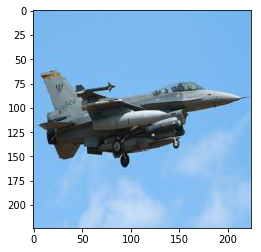

In [97]:
from matplotlib import pyplot as plt
from PIL import Image
t = Image.open(fo.data.filename(789))
plt.imshow(t)

In [107]:
mask = imresize(f[index][unit], im.shape[:2], mode='F')

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


In [105]:
index = 144
unit = 246

In [110]:
f[index][unit] # 7 x 7

memmap([[ 0.02391729,  0.1629944 ,  0.72148997,  1.05834556,  0.95072997,
          0.0174859 ,  0.        ],
        [ 0.18450765,  1.42490733,  3.34160423,  4.29091644,  3.47335935,
          1.10925341,  0.        ],
        [ 0.25225347,  3.25203228,  7.47186136,  9.78822517,  7.87280941,
          3.31191778,  0.5039472 ],
        [ 0.48882431,  4.62197828, 10.70927906, 14.05287075, 11.3443985 ,
          5.30286789,  1.14987183],
        [ 0.56485409,  4.71952295, 10.95147419, 14.6942997 , 11.87312412,
          5.65501499,  1.27259612],
        [ 0.76340818,  4.01260471,  8.449049  , 11.14150906,  8.94795513,
          4.22264624,  1.24510217],
        [ 0.61349785,  2.05048943,  3.81446552,  5.06664467,  4.050179  ,
          2.04905701,  0.70316613]])

In [108]:
mask  # 224 x 224

array([[0.02391729, 0.02391729, 0.02391729, ..., 0.        , 0.        ,
        0.        ],
       [0.02391729, 0.02391729, 0.02391729, ..., 0.        , 0.        ,
        0.        ],
       [0.02391729, 0.02391729, 0.02391729, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.61349785, 0.61349785, 0.61349785, ..., 0.7031661 , 0.7031661 ,
        0.7031661 ],
       [0.61349785, 0.61349785, 0.61349785, ..., 0.7031661 , 0.7031661 ,
        0.7031661 ],
       [0.61349785, 0.61349785, 0.61349785, ..., 0.7031661 , 0.7031661 ,
        0.7031661 ]], dtype=float32)

In [111]:
mask = mask > thresholds[unit]

In [116]:
print(thresholds[unit])
mask

4.64689938379028


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [160]:
im[0, :, :]

array([[ 81, 104, 156],
       [ 81, 104, 156],
       [ 81, 104, 156],
       [ 82, 105, 157],
       [ 82, 105, 157],
       [ 83, 106, 158],
       [ 83, 106, 158],
       [ 83, 106, 158],
       [ 82, 105, 157],
       [ 82, 105, 157],
       [ 82, 105, 157],
       [ 83, 106, 158],
       [ 83, 106, 158],
       [ 84, 107, 159],
       [ 84, 107, 159],
       [ 84, 107, 159],
       [ 82, 107, 163],
       [ 82, 107, 163],
       [ 82, 107, 163],
       [ 83, 108, 164],
       [ 83, 108, 164],
       [ 84, 109, 165],
       [ 84, 109, 165],
       [ 84, 109, 165],
       [ 85, 110, 166],
       [ 85, 110, 166],
       [ 85, 110, 166],
       [ 85, 110, 166],
       [ 85, 110, 166],
       [ 85, 110, 166],
       [ 85, 110, 166],
       [ 85, 110, 166],
       [ 84, 109, 165],
       [ 84, 109, 165],
       [ 84, 109, 165],
       [ 85, 110, 166],
       [ 85, 110, 166],
       [ 86, 111, 167],
       [ 86, 111, 167],
       [ 86, 111, 167],
       [ 86, 111, 167],
       [ 86, 111

In [159]:
((mask[:, :, numpy.newaxis] * 0.8 + 0.2) * im)[0, :, :]  #  1 * image RGB if > threshold; 0.2 * image RGB if < threshold

array([[16.2, 20.8, 31.2],
       [16.2, 20.8, 31.2],
       [16.2, 20.8, 31.2],
       [16.4, 21. , 31.4],
       [16.4, 21. , 31.4],
       [16.6, 21.2, 31.6],
       [16.6, 21.2, 31.6],
       [16.6, 21.2, 31.6],
       [16.4, 21. , 31.4],
       [16.4, 21. , 31.4],
       [16.4, 21. , 31.4],
       [16.6, 21.2, 31.6],
       [16.6, 21.2, 31.6],
       [16.8, 21.4, 31.8],
       [16.8, 21.4, 31.8],
       [16.8, 21.4, 31.8],
       [16.4, 21.4, 32.6],
       [16.4, 21.4, 32.6],
       [16.4, 21.4, 32.6],
       [16.6, 21.6, 32.8],
       [16.6, 21.6, 32.8],
       [16.8, 21.8, 33. ],
       [16.8, 21.8, 33. ],
       [16.8, 21.8, 33. ],
       [17. , 22. , 33.2],
       [17. , 22. , 33.2],
       [17. , 22. , 33.2],
       [17. , 22. , 33.2],
       [17. , 22. , 33.2],
       [17. , 22. , 33.2],
       [17. , 22. , 33.2],
       [17. , 22. , 33.2],
       [16.8, 21.8, 33. ],
       [16.8, 21.8, 33. ],
       [16.8, 21.8, 33. ],
       [17. , 22. , 33.2],
       [17. , 22. , 33.2],
 

In [126]:
vis = (mask[:, :, numpy.newaxis] * 0.8 + 0.2) * im

In [153]:
gap = 3
tiled = numpy.full(
                ((imsize + gap) * gridheight - gap,
                 (imsize + gap) * gridwidth - gap, 3), 255, dtype='uint8')  # all 255 of shape 224 x 2267 x 3

In [132]:
tiled.shape

(224, 2267, 3)

In [154]:
row = 0
col = 0
tiled[row*(imsize+gap):row*(imsize+gap)+imsize,
                    col*(imsize+gap):col*(imsize+gap)+imsize,:] = vis

In [148]:
row, col

(0, 0)

In [158]:
tiled[0, :, :] # int

array([[ 16,  20,  31],
       [ 16,  20,  31],
       [ 16,  20,  31],
       ...,
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

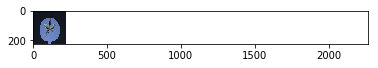

In [156]:
plt.imshow(tiled)

In [87]:
for label_order, record in enumerate(rendered_order):
    unit = int(record['unit']) - 1 # zero-based unit indexing
    #imfn = 'image/%s%s-%04d.jpg' % (
                #fn_safe(layer), gridname, unit)  # generate an image for each unit
    for x, index in enumerate(top[unit]):  # get top images for the unit
        row = x // gridwidth
        col = x % gridwidth
        image = imread(fo.data.filename(index))
        mask = imresize(f[index][unit], image.shape[:2], mode='F')
        mask = mask > thresholds[unit]
        vis = (mask[:, :, numpy.newaxis] * 0.8 + 0.2) * image
        tiled[row*(imsize+gap):row*(imsize+gap)+imsize,
                      col*(imsize+gap):col*(imsize+gap)+imsize,:] = vis

0 144
1 789
2 1073
3 1967
4 294
5 204
6 562
7 1988
8 493
9 1902
